In [ ]:
#@title Imports
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.colheader_justify', 'center')
import numpy as np
import random
import time
import re

import scipy.stats
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

from inspect import signature

def someMethod(self, arg1, kwarg1=None):
    pass

nba_possession_data_seasons = np.arange(1974, 2024, 1)
play_by_play_data_seasons = np.arange(1997, 2024, 1)
nba_pre_possession_data_seasons = np.arange(1952, 1974, 1)
aba_possession_data_seasons = np.arange(1974, 1977, 1)
aba_pre_possession_data_seasons = np.arange(1968, 1974, 1)

all_nba_seasons = np.arange(1952, 2024, 1)
all_aba_seasons = np.arange(1968, 1977, 1)

# plot
import seaborn as sns
import ast
from matplotlib.lines import Line2D
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
sns.set_style('darkgrid')        # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
      #if i % 2 == 0:
      ax.text(point['x']+0.12, point['y']+.25, str(point['val']))
      #else:
      #ax.text(point['x']+0.30, point['y'], str(point['val']))
      #ax.text(point['x']+0.05, point['y'], str(point['val']))

def label_point_year(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
      #if i % 2 == 0:
      ax.text(point['x']+0.12, point['y'], int(point['val']))
      #else:
      #ax.text(point['x']+0.30, point['y'], str(point['val']))
      #ax.text(point['x']+0.05, point['y'], str(point['val']))

plot_colors_set_list = ["#FF0000", "#D3A6D6", "#916613", "#00A4A0", "#FF7F00", "#ABFFD2", "#610077", "#173E4C", "#00A54C", "#FF00A1", "#FFFE00", "#0B1ADD"]

In [ ]:
#@title Import Selenium
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium

In [ ]:
#@title Start Webdriver and VirtualDisplay
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service

service = Service(executable_path=r'/usr/bin/chromedriver')
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome(service=service, options=options)

#options = Options()
#options.add_argument("--headless")
#options.add_argument("--no-sandbox")
#options.headless = True

#wd = webdriver.Chrome("/usr/bin/chromedriver", options=options)

!pip install pyvirtualdisplay
!apt-get install xvfb
from pyvirtualdisplay import Display
display = Display(visible=0, size=(800, 800))
display.start()

**IMPORT RAW DATA**

In [ ]:
#@title Manually Add Team Abbrev and Colors

team_colors = {"ATL": "#E03A3E", "BOS": "#007A33", "BRK": "#000000", "BUF": "#ff6314", "CAP": "#E31837", "CHA": "#00788C",
               "CHI": "#CE1141", "CHO": "#f26631", "CLE": "#860038", "DAL": "#00538C", "DEN": "#0E2240", "DET": "#1D42BA",
               "GSW": "#FFC72C", "HOU": "#CE1141", "IND": "#002D62", "KCO": "#5A2D81", "KCK": "#5A2D81", "LAC": "#C8102E",
               "LAL": "#552583", "MEM": "#5D76A9", "MIA": "#98002E", "MIL": "#00471B", "MIN": "#78BE20", "NOH": "#008fc5",
               "NOP": "#85714D", "NOJ": "#00471B", "NJN": "#00275d", "NYK": "#006BB6", "OKC": "#007AC1", "ORL": "#0077C0",
               "PHI": "#006BB6", "PHO": "#1D1160", "POR": "#E03A3E", "SAC": "#5A2D81", "SAS": "#C4CED4", "SEA": "#00653A",
               "TOR": "#CE1141", "TOT": "pink", "UTA": "#00471B", "WAS": "#E31837", "WSB": "#E31837"}

team_abbrev = {"Atlanta Hawks" : "ATL",       "Boston Celtics": "BOS",        "Brooklyn Nets": "BRK",         "Charlotte Bobcats": "CHA",
               "Chicago Bulls": "CHI",      "Charlotte Hornets": "CHO",      "Cleveland Cavaliers": "CLE",     "Dallas Mavericks": "DAL",
               "Denver Nuggets": "DEN",     "Detroit Pistons": "DET",       "Golden State Warriors": "GSW",     "Houston Rockets": "HOU",
               "Indiana Pacers": "IND",     "Los Angeles Clippers": "LAC",  "Los Angeles Lakers": "LAL",      "Memphis Grizzlies": "MEM",
               "Miami Heat": "MIA",         "Milwaukee Bucks": "MIL",     "Minnesota Timberwolves": "MIN",  "New Orleans Hornets": "NOH",
               "New Orleans Pelicans": "NOP", "New Orleans Jazz": "NOJ", "New Jersey Nets": "NJN",     "New York Knicks": "NYK",     "Oklahoma City Thunder": "OKC",
               "Orlando Magic": "ORL",     "Philadelphia 76ers": "PHI",      "Phoenix Suns": "PHO",       "Portland Trail Blazers": "POR",
               "Sacramento Kings": "SAC",    "San Antonio Spurs": "SAS", "San Diego Clippers": "SDC",       "Toronto Raptors": "TOR",               "Utah Jazz": "UTA",
               "Washington Wizards": "WAS", "Capital Bullets": "CAP", "Buffalo Braves": "BUF", "Seattle Supersonics": "SEA", "Seattle SuperSonics": "SEA", "Washington Bullets": "WSB",
               "Kansas City-Omaha Kings": "KCO", "Kansas City Kings": "KCK", "Charlotte Hornets": "CHH", "Vancouver Grizzlies": "VAN"}

team_abbrev_2015 = {"Atlanta Hawks" : "ATL",       "Boston Celtics": "BOS",        "Brooklyn Nets": "BRK",         "Charlotte Bobcats": "CHA",
              "Chicago Bulls": "CHI",      "Charlotte Hornets": "CHO",      "Cleveland Cavaliers": "CLE",     "Dallas Mavericks": "DAL",
              "Denver Nuggets": "DEN",     "Detroit Pistons": "DET",       "Golden State Warriors": "GSW",     "Houston Rockets": "HOU",
              "Indiana Pacers": "IND",     "Los Angeles Clippers": "LAC",  "Los Angeles Lakers": "LAL",      "Memphis Grizzlies": "MEM",
              "Miami Heat": "MIA",         "Milwaukee Bucks": "MIL",     "Minnesota Timberwolves": "MIN",  "New Orleans Hornets": "NOH",
              "New Orleans Pelicans": "NOP", "New Jersey Nets": "NJN",     "New York Knicks": "NYK",     "Oklahoma City Thunder": "OKC",
              "Orlando Magic": "ORL",     "Philadelphia 76ers": "PHI",      "Phoenix Suns": "PHO",       "Portland Trail Blazers": "POR",
              "Sacramento Kings": "SAC",    "San Antonio Spurs": "SAS",       "Toronto Raptors": "TOR",               "Utah Jazz": "UTA",
              "Washington Wizards": "WAS", "Capital Bullets": "CAP", "Buffalo Braves": "BUF", "Seattle Supersonics": "SEA", "Washington Bullets": "WSB",
              "Kansas City-Omaha Kings": "KCO", "Kansas City Kings": "KCK", "Charlotte Hornets": "CHO"}

aba_abbrev = {"Denver Nuggets": "DNA", "Indiana Pacers": "INA", "New York Nets": "NYA", "San Antonio Spurs": "SAA",
              "Virginia Squires": "VIR", "Carolina Cougars": "CAR", "San Diego Conquistadors": "SDA", "Kentucky Colonels": "KEN",
              "Utah Stars": "UTS", "Carolina Cougars": "CAR", "San Diego Sails": "SDS", "Spirits of St. Louis": "SSL",
              "Memphis Sounds": "MMS", "Denver Rockets": "DNR", "Memphis Tams": "MMT"}

aba_pre_poss_abbrev = {"Denver Nuggets": "DNA", "Indiana Pacers": "INA", "New York Nets": "NYA", "San Antonio Spurs": "SAA",
              "Virginia Squires": "VIR", "Carolina Cougars": "CAR", "San Diego Conquistadors": "SDA", "Kentucky Colonels": "KEN",
              "Utah Stars": "UTS", "Carolina Cougars": "CAR", "San Diego Sails": "SDS", "Spirits of St. Louis": "SSL",
              "Memphis Sounds": "MMS", "Denver Rockets": "DNR", "Pittsburgh Pipers": "PTP", "Minnesota Muskies": "MNM",
              "New Orleans Buccaneers": "NOB", "Dallas Chaparrals": "DLC", "Texas Chaparrals": "TEX", "Houston Mavericks": "HSM",
              "Oakland Oaks": "OAK", "Miami Floridians": "MMF", "Minnesota Pipers": "MNP", "Washington Capitols": "WSA",
              "Los Angeles Stars": "LAS", "The Floridians": "FLO", "Memphis Pros": "MMP", "New Jersey Americans": "NJA",
              "Anaheim Amigos": "ANA", "Pittsburgh Condors": "PTC", "Memphis Tams": "MMT"}

team_52_73_abbrev = {"Milwaukee Hawks" : "MLH",  "Syracuse Nationals": "SYR",        "Minneapolis Lakers": "MNL",         "Rochester Royals": "ROC",
               "Chicago Bulls": "CHI",      "Boston Celtics": "BOS",      "Cleveland Cavaliers": "CLE",     "Fort Wayne Pistons": "FTW",
               "Indianapolis Olympians": "INO",     "Detroit Pistons": "DET",       "Golden State Warriors": "GSW",     "Houston Rockets": "HOU",
               "St. Louis Hawks": "STL",  "Los Angeles Lakers": "LAL",      "Philadelphia Warriors": "PHW",
               "Cincinnati Royals": "CIN",         "Milwaukee Bucks": "MIL", "San Diego Rockets": "SDR",
               "New York Knicks": "NYK",   "Philadelphia 76ers": "PHI",      "Phoenix Suns": "PHO",       "Portland Trail Blazers": "POR",
               "Baltimore Bullets": "BAL", "Buffalo Braves": "BUF", "Seattle Supersonics": "SEA", "Washington Bullets": "WSB",
               "Kansas City-Omaha Kings": "KCO", "Kansas City Kings": "KCK", "San Francisco Warriors": "SFW", "Atlanta Hawks": "ATL",
               "Chicago Packers": "CHP", "Chicago Zephyrs": "CHZ"}

In [ ]:
#@title Import Primary Data

# era/opponent adjusted scoring
era_adj_reg_per_75_df = pd.read_csv('/content/era_adjusted_reg_per75_data.csv')
era_opponent_adj_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

# aba/nba league avg ts percentages
aba_league_avg = pd.read_csv('/content/aba_player_ts_data.csv')
league_avg_df = pd.read_csv('/content/nba_player_ts_data.csv')
league_avg_df['Year'] = league_avg_df['Year'].astype(str)
aba_league_avg['Year'] = aba_league_avg['Year'].astype(str)

In [ ]:
#@title Create ABA Scoring Coefficients

# create rDefRtg's
try:
  aba_pre_df = pd.read_csv("aba_68-73_Avg_DefRtg.csv", index_col=False, encoding='utf8')
  aba_df = pd.read_csv("aba_74-76_Avg_DefRtg.csv", index_col=False, encoding='utf8')
  aba_df = pd.concat([aba_df, aba_pre_df], ignore_index=True)
  aba_df = aba_df.sort_values('Year', ascending=True)
  outfile = f"aba_Avg_DefRtg_68-76.csv"
  aba_df.to_csv(outfile, index=False)
except:
  pass



# concatenate pre-possession era's estimated team DefRtgs with definite possession era's team DefRtg's
try:
  aba_poss_team_def_rtg = pd.read_csv('aba_Team_DefRtg_Allowed_74-76_df.csv', index_col=False, encoding='utf8')
  aba_estimated_pace_data_68_73 = pd.read_csv('aba_Team_Estimated_Pace_68-73_df.csv', index_col=False, encoding='utf8')
  aba_poss_team_pre_poss_def_rtg = pd.DataFrame()
  aba_poss_team_pre_poss_def_rtg['Year'] = aba_estimated_pace_data_68_73['Year']
  aba_poss_team_pre_poss_def_rtg['Team'] = aba_estimated_pace_data_68_73['Team']
  aba_poss_team_pre_poss_def_rtg['DefRtg'] = aba_estimated_pace_data_68_73['DefRtg']

  aba_poss_team_def_rtg = pd.concat([aba_poss_team_def_rtg, aba_poss_team_pre_poss_def_rtg], ignore_index=True)
  aba_poss_team_def_rtg = aba_poss_team_def_rtg.sort_values('Year', ascending=True)
  aba_poss_team_def_rtg.to_csv('aba_Team_DefRtg_Allowed_df.csv', index=False)
except:
  pass



# create opponent PTS coefficient
opponent_adj_pts_coeff = pd.DataFrame(columns = ['Year', 'Team', 'PTS_coeff'])

team_def_rtg = pd.read_csv('aba_Team_DefRtg_Allowed_df.csv', index_col=False, encoding='utf8')
league_avg_def_rtg = pd.read_csv('aba_Avg_DefRtg_68-76.csv', index_col=False, encoding='utf8')
for idx, row in team_def_rtg.iterrows():
        match_df = league_avg_def_rtg[(league_avg_def_rtg['Year'] == row['Year'])]
        avg = match_df['Avg DefRtg']
        avg = float(avg)
        coeff = avg / row['DefRtg']

        new_row = pd.DataFrame(np.array([[row['Year'], row['Team'], coeff]]), columns=['Year', 'Team', 'PTS_coeff'])
        opponent_adj_pts_coeff['Year'] = opponent_adj_pts_coeff['Year'].astype(int)
        opponent_adj_pts_coeff = pd.concat([opponent_adj_pts_coeff, new_row], ignore_index=True)


outfile = f"aba_opponent_adj_pts_coeff.csv"
opponent_adj_pts_coeff['Year'] = opponent_adj_pts_coeff['Year'].astype(int)
opponent_adj_pts_coeff = opponent_adj_pts_coeff.sort_values(['Year', 'Team'], ascending=[True, True])
opponent_adj_pts_coeff.to_csv(outfile, index=False)



# combine pre and post possession data league AVG PP75 data
try:
  aba_68_per75_coeff = pd.read_csv('aba_68-73_Avg_PP75.csv', index_col=False, encoding='utf8')
  aba_74_per75_coeff = pd.read_csv('aba_74-76_Avg_PP75.csv', index_col=False, encoding='utf8')
  both_pre_post_possession_aba_avg_pp75 = pd.concat([aba_68_per75_coeff, aba_74_per75_coeff], ignore_index=True)
  both_pre_post_possession_aba_avg_pp75.to_csv('Avg_ABA_Reg_PP75.csv', index=False)
except:
  pass

In [ ]:
#@title Create NBA Scoring Coefficients

# create rDefRtg's
try:
  nba_pre_df = pd.read_csv("nba_52-73_Avg_DefRtg.csv", index_col=False, encoding='utf8')
  nba_df = pd.read_csv("nba_74-23_Avg_DefRtg.csv", index_col=False, encoding='utf8')
  nba_df = pd.concat([nba_df, nba_pre_df], ignore_index=True)
  nba_df = nba_df.sort_values('Year', ascending=True)
  outfile = f"nba_Avg_DefRtg_52-23.csv"
  nba_df.to_csv(outfile, index=False)
except:
  pass



# concatenate pre-possession era's estimated team DefRtgs with definite possession era's team DefRtg's
try:
  nba_poss_team_def_rtg = pd.read_csv('nba_Team_DefRtg_Allowed_74-23_df.csv', index_col=False, encoding='utf8')
  nba_estimated_pace_data_52_73 = pd.read_csv('nba_Team_Estimated_Pace_52-73_df.csv', index_col=False, encoding='utf8')
  nba_poss_team_pre_poss_def_rtg = pd.DataFrame()
  nba_poss_team_pre_poss_def_rtg['Year'] = nba_estimated_pace_data_52_73['Year']
  nba_poss_team_pre_poss_def_rtg['Team'] = nba_estimated_pace_data_52_73['Team']
  nba_poss_team_pre_poss_def_rtg['DefRtg'] = nba_estimated_pace_data_52_73['DefRtg']

  nba_poss_team_def_rtg = pd.concat([nba_poss_team_def_rtg, nba_poss_team_pre_poss_def_rtg], ignore_index=True)
  nba_poss_team_def_rtg = nba_poss_team_def_rtg.sort_values('Year', ascending=True)
  nba_poss_team_def_rtg.to_csv('nba_Team_DefRtg_Allowed_df.csv', index=False)
except:
  pass



# create opponent PTS coefficient
opponent_adj_pts_coeff = pd.DataFrame(columns = ['Year', 'Team', 'PTS_coeff'])

team_def_rtg = pd.read_csv('nba_Team_DefRtg_Allowed_df.csv', index_col=False, encoding='utf8')
league_avg_def_rtg = pd.read_csv('nba_Avg_DefRtg_52-23.csv', index_col=False, encoding='utf8')
for idx, row in team_def_rtg.iterrows():
        match_df = league_avg_def_rtg[(league_avg_def_rtg['Year'] == row['Year'])]
        avg = match_df['Avg DefRtg']
        avg = float(avg)
        coeff = avg / row['DefRtg']

        new_row = pd.DataFrame(np.array([[row['Year'], row['Team'], coeff]]), columns=['Year', 'Team', 'PTS_coeff'])
        opponent_adj_pts_coeff = pd.concat([opponent_adj_pts_coeff, new_row], ignore_index=True)


outfile = f"nba_opponent_adj_pts_coeff.csv"
opponent_adj_pts_coeff['Year'] = opponent_adj_pts_coeff['Year'].astype(int)
opponent_adj_pts_coeff = opponent_adj_pts_coeff.sort_values(['Year', 'Team'], ascending=[True, True])
opponent_adj_pts_coeff.to_csv(outfile, index=False)



# combine pre and post possession data league AVG PP75 data
try:
  nba_52_per75_coeff = pd.read_csv('nba_52-73_Avg_PP75.csv', index_col=False, encoding='utf8')
  nba_74_per75_coeff = pd.read_csv('nba_74-23_Avg_PP75.csv', index_col=False, encoding='utf8')
  both_pre_post_possession_nba_avg_pp75 = pd.concat([nba_52_per75_coeff, nba_74_per75_coeff], ignore_index=True)
  both_pre_post_possession_nba_avg_pp75.to_csv('Avg_NBA_Reg_PP75.csv', index=False)
except:
  pass

In [ ]:
#@title Create Era PTS Coefficients
aba_per75_coeff = pd.read_csv('/content/Avg_ABA_Reg_PP75.csv', index_col=False, encoding='utf8')
nba_per75_coeff = pd.read_csv('/content/Avg_NBA_Reg_PP75.csv', index_col=False, encoding='utf8')

both_nba_and_aba = pd.concat([aba_per75_coeff, nba_per75_coeff], ignore_index=True)
max = both_nba_and_aba['Average PP75'].max()
nba_per75_coeff = pd.read_csv('/content/Avg_NBA_Reg_PP75.csv', index_col=False, encoding='utf8')
aba_per75_coeff['Coefficient'] = max / aba_per75_coeff['Average PP75']
nba_per75_coeff['Coefficient'] = max / nba_per75_coeff['Average PP75']

In [ ]:
#@title Import Supplementary Data

# advanced
import_player_since74_advanced_df = pd.read_csv('nba_player_since74_advanced_data.csv', encoding='utf8')
import_player_since74playoffs_advanced_df = pd.read_csv('nba_player_since74playoffs_advanced_data.csv', encoding='utf8')

# play-by-play
import_player_regular_playbyplay_df = pd.read_csv('nba_player_regular_playbyplay_data.csv', encoding='utf8')
import_player_regular_playbyplay_df['TeamColor'] = import_player_regular_playbyplay_df['Tm'].map(team_colors)

# play-by-play playoffs
import_player_playoff_playbyplay_df = pd.read_csv('nba_player_playoff_playbyplay_data.csv', encoding='utf8')
import_player_playoff_playbyplay_df['TeamColor'] = import_player_playoff_playbyplay_df['Tm'].map(team_colors)

# per 75 posssessions (non era-adjusted)
import_player_since74_per75_df = pd.read_csv('/content/nba_74-23_per75_reg_data.csv')
import_player_since74_per75_df['TeamColor'] = import_player_since74_per75_df['Tm'].map(team_colors)

# per 75 playoff posssessions (non era-adjusted)
import_player_since74playoffs_per75_df = pd.read_csv('/content/nba_74-23_per75_playoff_data.csv')
import_player_since74playoffs_per75_df['TeamColor'] = import_player_since74playoffs_per75_df['Tm'].map(team_colors)

**ABA**

In [ ]:
#@title ABA Scrape League Average TS% (1968 - 1976)
def scrape_aba_ts_data(years):

    league_avg_ts_df = pd.DataFrame(columns = ['Year', 'TS%'])

    for year in years:
        league_stats_url = f"https://www.basketball-reference.com/leagues/ABA_{year}.html"

        wd.get(league_stats_url)
        html = wd.page_source
        soup = BeautifulSoup(html)
        time.sleep(10)

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_advanced_team'})
          first_table = second_div.find('table', attrs={'id': 'advanced-team'})
          foot = first_table.find('tfoot')

        headers = [th.getText() for th in first_table.findAll('tr', limit=2)[1].findAll('th')]
        rows = [td.getText() for td in foot.findAll('tr', limit=2)[0].findAll('td')]
        rows.insert(0, year)

        all_stats_frivolous_included_df = pd.DataFrame(np.array(rows).reshape(-1,len(rows)), columns = headers)


        tmp_year_and_ts_df = pd.DataFrame()

        tmp_year_and_ts_df['Year'] = all_stats_frivolous_included_df['Rk']
        tmp_year_and_ts_df['TS%'] = all_stats_frivolous_included_df['TS%']

        league_avg_ts_df = pd.concat([league_avg_ts_df, tmp_year_and_ts_df], ignore_index=False)
        league_avg_ts_df.to_csv("aba_player_ts_data.csv", index=False)

    # print final_df
    print(league_avg_ts_df.info)

scrape_aba_ts_data(all_aba_seasons)

**1968-1973 (estimated) DATA**

In [ ]:
#scrape_aba_team_estimated_playoff_pace_data(aba_pre_possession_data_seasons)
#scrape_aba_team_estimated_pace_data(aba_pre_possession_data_seasons)
#scrape_aba_player_changed_teams_per75_data(aba_pre_possession_data_seasons)
#scrape_aba_player_advanced_data(aba_pre_possession_data_seasons)
#scrape_aba_player_reg_pergame_data(aba_pre_possession_data_seasons)
#scrape_aba_player_playoff_pergame_data(aba_pre_possession_data_seasons)
#scrape_aba_player_total_mp_data(aba_pre_possession_data_seasons)

In [ ]:
#@title ABA 1968-73 Scrape Functions
def scrape_aba_team_estimated_playoff_pace_data(years):

    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team', 'Pace/G', 'OffRtg', 'DefRtg'])

    for year in years:

        wd.get(f"https://www.basketball-reference.com/playoffs/ABA_{year}.html")
        html = wd.page_source
        soup = BeautifulSoup(html)
        time.sleep(10)

        #Find table body of team stats
        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'switcher_per_game_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_game-team'})
          body = first_table.find('tbody')

        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year and pace column to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
             team_allowed_stats[i].insert(1, 0)
        headers.insert(0, "Year")
        headers.insert(1, "Pace/G")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)
        each_years_teams = each_years_teams.sort_values('Team', ascending=True)

        each_years_teams['PTS'] = each_years_teams['PTS'].astype(float)
        each_years_teams['FGA'] = each_years_teams['FGA'].astype(float)
        each_years_teams['FTA'] = each_years_teams['FTA'].astype(float)
        each_years_teams['FG'] = each_years_teams['FG'].astype(float)
        each_years_teams['FG'] = each_years_teams['FG'].astype(float)
        each_years_teams['G'] = each_years_teams['G'].astype(float)


        ORB_percent = 0.321
        if year == 1971:
          TOV_percent = 0.158
          each_years_teams['Pace/G'] = (each_years_teams['FGA'] + (0.4 * each_years_teams['FTA']) - ORB_percent * (each_years_teams['FGA'] - each_years_teams['FG']) + (-TOV_percent * (each_years_teams['FGA'] + 0.44 * each_years_teams['FTA']) / (TOV_percent - 1)))
          each_years_teams['OffRtg'] = (each_years_teams['PTS'] / each_years_teams['Pace/G']) * 100
        else:
          each_years_teams['TOV'] = each_years_teams['TOV'].astype(float)
          each_years_teams['Pace/G'] = (each_years_teams['FGA'] + (0.4 * each_years_teams['FTA']) - ORB_percent * (each_years_teams['FGA'] - each_years_teams['FG']) + each_years_teams['TOV'])
          each_years_teams['OffRtg'] = (each_years_teams['PTS'] / each_years_teams['Pace/G']) * 100


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'], axis=1, inplace=True)



        #Find table body of opponent stats
        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'switcher_per_game_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_game-opponent'})
          body = first_table.find('tbody')

        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each row
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
        headers.insert(0, "Year")
        def_rtg_df = pd.DataFrame(team_allowed_stats, columns = headers)
        def_rtg_df = def_rtg_df.sort_values('Team', ascending=True)

        def_rtg_df['PTS'] = def_rtg_df['PTS'].astype(float)
        each_years_teams['DefRtg'] = (def_rtg_df['PTS'] / each_years_teams['Pace/G']) * 100
        each_years_teams['Team'] = each_years_teams['Team'].str.replace(r"[*]", '', regex=True)
        each_years_teams['Team'] = each_years_teams['Team'].map(aba_pre_poss_abbrev)
        print(each_years_teams)

        final_team_data_df = pd.concat([final_team_data_df, each_years_teams], ignore_index=True)

    # print final_df
    print(final_team_data_df.info)
    final_team_data_df.to_csv("aba_Team_Estimated_Playoff_Pace_68-73_df.csv", index=False)

# ABA Scrape reg pace
def scrape_aba_team_estimated_pace_data(years):

    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team', 'Pace/G', 'OffRtg', 'DefRtg'])

    for year in years:

        wd.get(f"https://www.basketball-reference.com/leagues/ABA_{year}.html")
        html = wd.page_source
        soup = BeautifulSoup(html)
        time.sleep(10)

        #Find table body of team stats
        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'switcher_per_game_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_game-team'})
          body = first_table.find('tbody')

        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year and pace column to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
             team_allowed_stats[i].insert(1, 0)
        headers.insert(0, "Year")
        headers.insert(1, "Pace/G")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)
        each_years_teams = each_years_teams.sort_values('Team', ascending=True)

        each_years_teams['PTS'] = each_years_teams['PTS'].astype(float)
        each_years_teams['FGA'] = each_years_teams['FGA'].astype(float)
        each_years_teams['FTA'] = each_years_teams['FTA'].astype(float)
        each_years_teams['FG'] = each_years_teams['FG'].astype(float)
        each_years_teams['FG'] = each_years_teams['FG'].astype(float)
        each_years_teams['G'] = each_years_teams['G'].astype(float)


        ORB_percent = 0.321
        each_years_teams['TOV'] = each_years_teams['TOV'].astype(float)
        each_years_teams['Pace/G'] = (each_years_teams['FGA'] + (0.4 * each_years_teams['FTA']) - ORB_percent * (each_years_teams['FGA'] - each_years_teams['FG']) + each_years_teams['TOV'])
        each_years_teams['OffRtg'] = (each_years_teams['PTS'] / each_years_teams['Pace/G']) * 100


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'], axis=1, inplace=True)



        #Find table body of opponent stats
        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'switcher_per_game_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_game-opponent'})
          body = first_table.find('tbody')

        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each row
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
        headers.insert(0, "Year")
        def_rtg_df = pd.DataFrame(team_allowed_stats, columns = headers)
        def_rtg_df = def_rtg_df.sort_values('Team', ascending=True)

        def_rtg_df['PTS'] = def_rtg_df['PTS'].astype(float)
        each_years_teams['DefRtg'] = (def_rtg_df['PTS'] / each_years_teams['Pace/G']) * 100
        each_years_teams['Team'] = each_years_teams['Team'].str.replace(r"[*]", '', regex=True)
        each_years_teams['Team'] = each_years_teams['Team'].map(aba_pre_poss_abbrev)
        print(each_years_teams)

        final_team_data_df = pd.concat([final_team_data_df, each_years_teams], ignore_index=True)

    # print final_df
    print(final_team_data_df.info)
    final_team_data_df.to_csv("aba_Team_Estimated_Pace_68-73_df.csv", index=False)


# Scrape ABA regular season per 75 (1968-73)
def scrape_aba_player_reg_per75_data(years):

    fin_changed_teams_df = pd.DataFrame()
    fin_same_team_df = pd.DataFrame()
    pace_sup = pd.read_csv('/content/aba_Team_Estimated_Pace_68-73_df.csv', encoding='utf8', index_col=False)
    for year in years:

        final_players_pergame_df = pd.DataFrame()
        player_base_url = f"https://www.basketball-reference.com/leagues/ABA_{year}_per_game.html"


        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")

        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("PTS")+1]
        time.sleep(6)

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
             player_base_stats[i].insert(33, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS+")
        headers.insert(2, "TeamColor")
        headers.insert(33, "Possessions")


        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # append to final df
        final_players_pergame_df = pd.concat([final_players_pergame_df, each_year], ignore_index=True)

        # remove apostrophes from name
        final_players_pergame_df['Player'] = final_players_pergame_df['Player'].str.replace(r"[*]", '', regex=True)

        # remove any Na
        final_players_pergame_df = final_players_pergame_df.dropna()

        cols = ['FG','FGA','2P','2PA','FT','FTA','TRB','AST','PF','PTS']
        final_players_pergame_df[cols] = final_players_pergame_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)
        final_players_pergame_df['PTS'] = final_players_pergame_df['PTS'].astype(float)
        final_players_pergame_df['MP'] = final_players_pergame_df['MP'].astype(float)
        final_players_pergame_df['G'] = final_players_pergame_df['G'].astype(int)

        final_players_pergame_df_first_row = final_players_pergame_df.drop_duplicates(subset =['Player', 'Year'], keep="first")
        final_players_pergame_df_same_team_df = final_players_pergame_df_first_row[(final_players_pergame_df_first_row['Tm'] != 'TOT')]

        final_players_pergame_df_changed_team_tot_df = final_players_pergame_df[(final_players_pergame_df['Tm'] == 'TOT')]

        player_changed_teams_names = final_players_pergame_df_changed_team_tot_df['Player'].tolist()
        player_changed_teams_names = list(set(player_changed_teams_names))

        final_players_pergame_df_changed_team_all_team_rows_df = final_players_pergame_df[(final_players_pergame_df['Player'].isin(player_changed_teams_names))]
        final_players_pergame_df_changed_team_all_team_rows_df = final_players_pergame_df_changed_team_all_team_rows_df[(final_players_pergame_df_changed_team_all_team_rows_df['Tm'] != 'TOT')]

        # Players that changed teams need pace of all their teams accounted for
        final_players_pergame_df_changed_team_all_team_rows_df['total_MP'] = final_players_pergame_df_changed_team_all_team_rows_df['MP'] * final_players_pergame_df_changed_team_all_team_rows_df['G']
        #final_players_pergame_df_changed_team_all_team_rows_df = final_players_pergame_df_changed_team_all_team_rows_df.reset_index(drop=True)
        pace_sup['Pace/G'] = pace_sup['Pace/G'].astype(float)






        for player_name in player_changed_teams_names:
          mp_list = []
          player_teams_df = final_players_pergame_df_changed_team_all_team_rows_df[(final_players_pergame_df_changed_team_all_team_rows_df['Player'] == player_name)]
          player_teams_df = player_teams_df.reset_index(drop=True)

          for idx, row in player_teams_df.iterrows():
            team = pace_sup[(pace_sup['Year'] == row['Year']) & (pace_sup['Team'] == row['Tm'])]
            team_pace = float(team['Pace/G'])
            # team folded and didn't play for another team that season.
            teams_count = idx+1
            player_teams_df.loc[idx, 'Possessions'] = float(team_pace) * (player_teams_df.loc[idx, 'MP']/48)
            player_teams_df.loc[idx, 'Possessions'] = player_teams_df.loc[idx, 'Possessions'].astype(float)
            ind_poss_coeff = player_teams_df.loc[idx, 'Possessions'] / 75
            player_teams_df.loc[idx, 'PTS'] = player_teams_df.loc[idx, 'PTS']  / ind_poss_coeff
            player_teams_df.loc[idx, 'TRB'] = player_teams_df.loc[idx, 'TRB']  / ind_poss_coeff
            player_teams_df.loc[idx, 'AST'] = player_teams_df.loc[idx, 'AST']  / ind_poss_coeff
            mp_list.append(row['total_MP'])




          player_tot_df = final_players_pergame_df_changed_team_tot_df[(final_players_pergame_df_changed_team_tot_df['Player'] == player_name)]
          player_tot_df = player_tot_df.reset_index()

          i = 0
          total_per_75_pts = 0
          total_reb = 0
          total_ast = 0
          total_pace = 0
          total_mp = sum(mp_list)
          while i < teams_count:
            total_per_75_pts+= float(player_teams_df.loc[i, 'PTS']) * (mp_list[i] / total_mp)
            total_reb+= float(player_teams_df.loc[i, 'TRB']) * (mp_list[i] / total_mp)
            total_ast+= float(player_teams_df.loc[i, 'AST']) * (mp_list[i] / total_mp)
            total_pace+= player_teams_df.loc[i,'Possessions'] * (mp_list[i] / total_mp)
            i = i + 1
          player_tot_df.loc[0, 'PTS'] = total_per_75_pts
          player_tot_df.loc[0, 'TRB'] = total_reb
          player_tot_df.loc[0, 'AST'] = total_ast
          player_tot_df.loc[0, 'Possessions'] = total_pace

          fin_changed_teams_df = pd.concat([fin_changed_teams_df, player_tot_df], ignore_index=True)
          fin_changed_teams_df= fin_changed_teams_df.reset_index(drop=True)


        # players who remained on one team
        player_same_team_names = final_players_pergame_df_same_team_df['Player'].tolist()
        player_same_team_names = list(set(player_same_team_names))

        for player_name in player_same_team_names:

          player_teams_df = final_players_pergame_df_same_team_df[(final_players_pergame_df_same_team_df['Player'] == player_name)]
          player_teams_df = player_teams_df.reset_index(drop=True)

          for idx, row in player_teams_df.iterrows():
            team = pace_sup[(pace_sup['Year'] == row['Year']) & (pace_sup['Team'] == row['Tm'])]
            team_pace = float(team['Pace/G'])
            # team folded and didn't play for another team that season.
            teams_count = idx+1
            player_teams_df.loc[idx, 'Possessions'] = float(team_pace) * (player_teams_df.loc[idx, 'MP']/48)
            player_teams_df.loc[idx, 'Possessions'] = player_teams_df.loc[idx, 'Possessions'].astype(float)
            ind_poss_coeff = player_teams_df.loc[idx, 'Possessions'] / 75
            player_teams_df.loc[idx, 'PTS'] = player_teams_df.loc[idx, 'PTS']  / ind_poss_coeff
            player_teams_df.loc[idx, 'TRB'] = player_teams_df.loc[idx, 'TRB']  / ind_poss_coeff
            player_teams_df.loc[idx, 'AST'] = player_teams_df.loc[idx, 'AST']  / ind_poss_coeff
          fin_same_team_df = pd.concat([fin_same_team_df, player_teams_df], ignore_index=True)
          fin_same_team_df= fin_same_team_df.reset_index(drop=True)
    fin_changed_teams_df = fin_changed_teams_df.drop(columns=['index'])

    fin_df = pd.DataFrame()
    fin_df = pd.concat([fin_same_team_df, fin_changed_teams_df], ignore_index=True)
    fin_df = fin_df.sort_values(['Year', 'Player'], ascending=[True, True])
    fin_df= fin_df.reset_index(drop=True)
    fin_df['PTS'] = fin_df['PTS'].round(2)
    fin_df['TRB'] = fin_df['TRB'].round(2)
    fin_df['AST'] = fin_df['AST'].round(2)
    fin_df['Possessions'] = fin_df['Possessions'].round(2)
    print(fin_df.info)
    fin_df.to_csv("aba_68-73_reg_per75_data.csv", index=False)


    reg_per_75 = pd.read_csv('/content/aba_68-73_reg_per75_data.csv', index_col=False, encoding='utf8')
    reg_ts = pd.read_csv('/content/aba_68-73_reg_advanced_data.csv', index_col=False, encoding='utf8')
    reg_ts = reg_ts[reg_ts['Player'].notna()]
    reg_ts = reg_ts.sort_values(['Year', 'Player'], ascending=[True, True])
    reg_ts= reg_ts.reset_index(drop=True)

    # Add TS+ and Era-Adjust PTS
    reg_per_75['Year'] = reg_per_75['Year'].astype(int)

    new_df = pd.DataFrame()
    for yearloop in range(1968, 1974):
      yearloop = int(yearloop)
      aba_league_avg['Year'] = aba_league_avg['Year'].astype(int)

      year_df = aba_per75_coeff[(aba_per75_coeff['Year'] == yearloop)]
      advanced_data_df = reg_ts[(reg_ts['Year'] == yearloop)]

      year_league_avg_df = aba_league_avg[(aba_league_avg['Year'] == yearloop)]
      year_league_avg_df = year_league_avg_df.reset_index(drop=True)
      for idx, player_advanced_df in advanced_data_df.iterrows():
        player_per75_df = reg_per_75[(reg_per_75['Player'] == player_advanced_df['Player']) & (reg_per_75['Year'] == player_advanced_df['Year'])]
        player_per75_df['TS+'] = float( ( float(player_advanced_df['TS%']) / year_league_avg_df['TS%'].astype(float) ) * 100 )
        player_per75_df['PTS'] = float(float(player_per75_df['PTS']) * year_df['Coefficient'].astype(float))
        player_per75_df['Year'] = yearloop
        new_df = pd.concat([new_df, player_per75_df], ignore_index=True)

    new_df['PTS'] = new_df['PTS'].round(2)
    new_df['TS+'] = new_df['TS+'].round(2)
    new_df['Year'] = new_df['Year'].astype(int)
    print(new_df)

    outfile = f"aba_68-73_era_adjusted_reg_per75_data.csv"
    new_df.to_csv(outfile, index=False)


# Scrape NBA regular season advanced (1968-73)
def scrape_aba_player_advanced_data(years):

    final_players_advanced_df = pd.DataFrame()
    for year in years:
        print(year)
        player_base_url = f"https://www.basketball-reference.com/leagues/ABA_{year}_advanced.html"

        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        time.sleep(5)

        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("VORP")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS+")


        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # append to final df
        final_players_advanced_df = pd.concat([final_players_advanced_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_advanced_df = final_players_advanced_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_advanced_df['Player'] = final_players_advanced_df['Player'].str.replace(r"[*]", '', regex=True)

        # remove any Na
        final_players_advanced_df = final_players_advanced_df.dropna()

    # print final_df
    print(final_players_advanced_df.info)
    final_players_advanced_df.to_csv("aba_68-73_reg_advanced_data.csv", index=False)

# Scrape ABA playoff per 75 (1968-73)
def scrape_aba_player_playoff_75_data(years):

    final_players_pergame_df = pd.DataFrame(columns = ['Year',  'TS+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm',
                                                    'G', 'GS', 'MP', 'FG', 'FGA',
                                                    'FG%', '3P', '3PA', '3P%', '2P',
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%',
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL',
                                                    'BLK', 'TOV', 'PF', 'PTS']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/playoffs/ABA_{year}_per_game.html"

        html = urlopen(player_base_url)
        time.sleep(6)
        soup = BeautifulSoup(html, features="lxml")

        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("PTS")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
             player_base_stats[i].insert(3, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS+")
        headers.insert(2, "TeamColor")
        headers.insert(3, "Possessions")


        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # append to final df
        final_players_pergame_df = pd.concat([final_players_pergame_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_pergame_df = final_players_pergame_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_pergame_df['Player'] = final_players_pergame_df['Player'].str.replace(r"[*]", '', regex=True)

        # remove any Na
        final_players_pergame_df = final_players_pergame_df.dropna()

    final_players_pergame_df.to_csv("aba_68-73_playoff_pergame_data.csv", index=False)
    pergame = pd.read_csv('aba_68-73_playoff_pergame_data.csv', encoding='utf8', index_col=False)
    pace_sup = pd.read_csv('aba_Team_Estimated_Playoff_Pace_68-73_df.csv', encoding='utf8', index_col=False)

    pergame['PTS'] = pergame['PTS'].astype(float)
    pergame['MP'] = pergame['MP'].astype(float)
    pace_sup['Pace/G'] = pace_sup['Pace/G'].astype(float)

    cols = ['FG','FGA','2P','2PA','FT','FTA','TRB','AST','PF','PTS']
    pergame[cols] = pergame[cols].apply(pd.to_numeric, errors='coerce', axis=1)


    for idx, row in pergame.iterrows():
      team = pace_sup[(pace_sup['Year'] == row['Year']) & (pace_sup['Team'] == row['Tm'])]
      team_pace = team['Pace/G']
      pergame.loc[idx, 'Possessions'] = float(team_pace) * (pergame.loc[idx, 'MP']/48)
      pergame.loc[idx, 'Possessions'] = pergame.loc[idx, 'Possessions'].astype(float)
      ind_poss_coeff = pergame.loc[idx, 'Possessions'] / 75
      pergame.loc[idx, 'PTS'] = pergame.loc[idx, 'PTS']  / ind_poss_coeff
      pergame.loc[idx, 'TRB'] = pergame.loc[idx, 'TRB']  / ind_poss_coeff
      pergame.loc[idx, 'AST'] = pergame.loc[idx, 'AST']  / ind_poss_coeff

    pergame[cols] = pergame[cols].apply(lambda x : x.round(2), axis=1)
    pergame.to_csv("aba_68-73_playoff_per75_data.csv", index=False)

    # Replace Per 75 'MPG' with total 'MP'
    per75 = pd.read_csv('aba_68-73_playoff_per75_data.csv', encoding='utf8', index_col=False)
    total_mp = pd.read_csv('aba_68-73_total_mp_playoff_data.csv', encoding='utf8', index_col=False)

    # Remove 'Walter Roger Brown' for ease (played less than 200 MP in playoffs; not relevant in this context)
    total_mp = total_mp[((total_mp['Player'] != 'Roger Brown') | (total_mp['Tm'] != 'CAR'))]

    for idx, mp_player in per75.iterrows():
      total_mp_df = total_mp[(total_mp['Player'] == mp_player['Player']) & (total_mp['Year'] == mp_player['Year'])]
      per75.loc[idx, 'MP'] = int(total_mp_df['MP'])
    per75['PTS'] = per75['PTS'].round(2)
    per75['TRB'] = per75['TRB'].round(2)
    per75['AST'] = per75['AST'].round(2)
    per75['Possessions'] = per75['Possessions'].round(2)
    per75['MP'] = per75['MP'].astype(int)

    per75.to_csv("aba_68-73_playoff_per75_data.csv", index=False)
    print(per75.info)


# Scrape ABA playoff totals (1968-73)
def scrape_aba_player_total_mp_data(years):

    final_players_pergame_df = pd.DataFrame(columns = ['Year',  'TS+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm',
                                                    'G', 'GS', 'MP', 'FG', 'FGA',
                                                    'FG%', '3P', '3PA', '3P%', '2P',
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%',
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL',
                                                    'BLK', 'TOV', 'PF', 'PTS']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/playoffs/ABA_{year}_totals.html"

        html = urlopen(player_base_url)
        time.sleep(5)
        time.sleep(5)
        soup = BeautifulSoup(html, features="lxml")

        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("PTS")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
             player_base_stats[i].insert(3, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS+")
        headers.insert(2, "TeamColor")
        headers.insert(3, "Possessions")


        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # append to final df
        final_players_pergame_df = pd.concat([final_players_pergame_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_pergame_df = final_players_pergame_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_pergame_df['Player'] = final_players_pergame_df['Player'].str.replace(r"[*]", '', regex=True)

        # remove any Na
        final_players_pergame_df = final_players_pergame_df.dropna()

    # print final_df
    print(final_players_pergame_df.info)
    final_players_pergame_df.to_csv("aba_68-73_total_mp_playoff_data.csv", index=False)

In [ ]:
#@title ABA 1968-73 Ancillary Calculations

# Calculate average PTS per 75 (1968-73)
# year by year find what the league average PTS per 75 possessions was. Each row (player)'s points scaled for minutes.
avg_pts_per_75 = pd.read_csv('/content/aba_68-73_reg_per_75_data.csv', index_col=False, encoding='utf8')
avg_pts_per_75 = avg_pts_per_75[(avg_pts_per_75['Tm'] != "TOT")]
total_mp = 0
running_pts_avg = []
year_list = []
final_df = pd.DataFrame()
for year in aba_pre_possession_data_seasons:
  year_list.append(year)
  this_years_players = avg_pts_per_75[(avg_pts_per_75['Year']) == year]
  this_years_players['MP'] = this_years_players['MP'].astype(float)
  total_mp = this_years_players['MP'].sum()
  this_years_players['AdjPts'] = (this_years_players['PTS'].astype(float)) * (this_years_players['MP'].astype(float) / total_mp)
  running_pts_avg.append(this_years_players['AdjPts'].sum())

final_df['Year'] = year_list
final_df['Average PP75'] = running_pts_avg

final_df.to_csv("aba_68-73_Avg_PP75.csv", index=False)

# Calculate average DefRtg (1968-73)
# year by year find what the league average DefRtg was.
avg_DefRtg = pd.read_csv('aba_Team_Estimated_Pace_68-73_df.csv', index_col=False, encoding='utf8')
running_pts_avg = []
year_list = []
final_df = pd.DataFrame()
for year in aba_pre_possession_data_seasons:
  year_list.append(year)
  this_years_players = avg_DefRtg[(avg_DefRtg['Year']) == year]
  running_pts_avg.append(this_years_players['DefRtg'].mean())

final_df['Year'] = year_list
final_df['Avg DefRtg'] = running_pts_avg

final_df.to_csv("aba_68-73_Avg_DefRtg.csv", index=False)

**1974-1976 DATA**

In [ ]:
#scrape_aba_advanced_data(aba_possession_data_seasons)
#scrape_aba_team_ts_allowed_data(aba_possession_data_seasons)
#scrape_aba_player_reg_avg_per_75(aba_possession_data_seasons)
#scrape_aba_player_per75_playoff_data(aba_possession_data_seasons)
#scrape_aba_player_per75_reg_data(aba_possession_data_seasons)
#scrape_aba_team_defrtg_allowed_data(aba_possession_data_seasons)
#scrape_aba_avg_defrtg(aba_possession_data_seasons)
#scrape_aba_team_playoff_OffRtg_data(aba_possession_data_seasons)

In [ ]:
#@title ABA 1974-76 Scrape Functions
# Scrape ABA regular season per 75
def scrape_aba_player_per75_reg_data(years):

    final_players_per75_df = pd.DataFrame(columns = ['Year',  'TS+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm',
                                                    'G', 'GS', 'MP', 'FG', 'FGA',
                                                    'FG%', '3P', '3PA', '3P%', '2P',
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%',
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL',
                                                    'BLK', 'TOV', 'PF', 'PTS',
                                                    'ORtg', 'DRtg']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/leagues/ABA_{year}_per_poss.html"

        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")

        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS+")
        headers.insert(2, "TeamColor")


        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # remove blank columns
        each_year = each_year.drop('', axis=1)

        # append to final df
        final_players_per75_df = pd.concat([final_players_per75_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_per75_df = final_players_per75_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_per75_df['Player'] = final_players_per75_df['Player'].str.replace(r"[*]", '', regex=True)

        # remove any Na
        final_players_per75_df = final_players_per75_df.dropna()

    # print final_df
    cols = ['FG','FGA','3P','3PA','2P','2PA','FT','FTA','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS']
    final_players_per75_df[cols] = final_players_per75_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)
    final_players_per75_df[cols] = final_players_per75_df[cols].apply(lambda x : x * .75, axis=1)
    final_players_per75_df[cols] = final_players_per75_df[cols].apply(lambda x : x.round(2), axis=1)
    print(final_players_per75_df.info)
    final_players_per75_df.to_csv("aba_74-76_per75_reg_data.csv", index=False)

# Scrape ABA playoffs per 75
def scrape_aba_player_per75_playoff_data(years):

    final_players_per75_df = pd.DataFrame(columns = ['Year',  'TS+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm',
                                                    'G', 'GS', 'MP', 'FG', 'FGA',
                                                    'FG%', '3P', '3PA', '3P%', '2P',
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%',
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL',
                                                    'BLK', 'TOV', 'PF', 'PTS',
                                                    'ORtg', 'DRtg']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/playoffs/ABA_{year}_per_poss.html"

        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")

        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS+")
        headers.insert(2, "TeamColor")


        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # remove blank columns
        each_year = each_year.drop('', axis=1)

        # append to final df
        final_players_per75_df = pd.concat([final_players_per75_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_per75_df = final_players_per75_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_per75_df['Player'] = final_players_per75_df['Player'].str.replace(r"[*]", '', regex=True)
        # remove any Na
        final_players_per75_df = final_players_per75_df.dropna()

    # print final_df
    cols = ['FG','FGA','3P','3PA','2P','2PA','FT','FTA','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS']
    final_players_per75_df[cols] = final_players_per75_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)
    final_players_per75_df[cols] = final_players_per75_df[cols].apply(lambda x : x * .75, axis=1)
    final_players_per75_df[cols] = final_players_per75_df[cols].apply(lambda x : x.round(2), axis=1)
    print(final_players_per75_df.info)
    final_players_per75_df.to_csv("aba_74-76_per75_playoff_data.csv", index=False)

# Scrape ABA regular season advanced
def scrape_aba_advanced_data(years):

    final_players_advanced_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age',
                                                        'Tm', 'TeamColor', 'G', 'MP', 'PER', 'TS%',
                                                        '3PAr', 'FTr', 'ORB%', 'DRB%',
                                                        'TRB%', 'AST%', 'STL%', 'BLK%',
                                                        'TOV%', 'USG%', 'OWS', 'DWS',
                                                        'WS', 'WS/48', 'OBPM', 'DBPM',
                                                        'BPM', 'VORP'
                                                        ])
    for year in years:
        player_advanced_url = f"https://www.basketball-reference.com/leagues/ABA_{year}_advanced.html"

        html = urlopen(player_advanced_url)
        soup = BeautifulSoup(html, features="lxml")

        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("VORP")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_advanced_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_advanced_stats = [e for e in player_advanced_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_advanced_stats)):
             player_advanced_stats[i].insert(0, year)
             player_advanced_stats[i].insert(5, 0)
        headers.insert(0, "Year")
        headers.insert(5, "TeamColor")

        each_year = pd.DataFrame(player_advanced_stats, columns = headers)

        # remove blank columns
        each_year = each_year.drop('\xa0',axis=1)

        # append dataframe
        final_players_advanced_df = pd.concat([final_players_advanced_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_advanced_df = final_players_advanced_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_advanced_df['Player'] = final_players_advanced_df['Player'].str.replace(r"[*]", '')
        #final_players_advanced_df['Player'] = final_players_advanced_df['Player'].apply(ast.literal_eval).str.decode("utf-8")
        #final_players_advanced_df['Player'] = unidecode(final_players_advanced_df['Player'])

        # remove any Na
        final_players_advanced_df = final_players_advanced_df.dropna()

    # print final_df
    print(final_players_advanced_df.info)
    final_players_advanced_df.to_csv("aba_player_since74_advanced_data.csv", index=False)

# Scrape ABA Teams' TS% Allowed
def scrape_aba_team_ts_allowed_data(years):

    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team' 'TS% Allowed'])

    for year in years:

        wd.get(f"https://www.basketball-reference.com/leagues/ABA_{year}.html")
        html = wd.page_source
        soup = BeautifulSoup(html)


        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_totals_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'totals-opponent'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
        headers.insert(0, "Year")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)

        # remove non-playoff teams
        each_years_teams = each_years_teams[each_years_teams.Team.str.contains("\*", na=False)]

        # add TS% allowed
        each_years_teams['PTS'] = each_years_teams['PTS'].astype(float)
        each_years_teams['FTA'] = each_years_teams['FTA'].astype(float)
        each_years_teams['FGA'] = each_years_teams['FGA'].astype(float)
        each_years_teams['TS% Allowed'] = each_years_teams['PTS'] / ( ( (each_years_teams['FTA'] * .44) + (each_years_teams['FGA']) ) * 2)


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS'], axis=1, inplace=True)



        # remove apostrophes from name
        each_years_teams['Team'] = each_years_teams['Team'].str.replace(r"[*]", '')

        each_years_teams['Team'] = each_years_teams['Team'].map(aba_abbrev)

        print(each_years_teams)

        final_team_data_df = pd.concat([final_team_data_df, each_years_teams], ignore_index=True)

    # print final_df
    print(final_team_data_df.info)
    final_team_data_df.to_csv("aba_Team_TS_Percentage_Allowed_df.csv", index=False)

# Scrape ABA Reg Avg Per 75 Scoring
def scrape_aba_player_reg_avg_per_75(years):

    final_df = pd.DataFrame(columns = ['Year', 'Average PP75'])
    for year in years:
        total_mp = 0
        running_pts_avg = 0
        player_base_url = f"https://www.basketball-reference.com/leagues/ABA_{year}_per_poss.html"

        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")

        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
        headers.insert(0, "Year")


        each_year = pd.DataFrame(player_base_stats, columns = headers)
        each_year = each_year[each_year['MP'] != '0']

        each_year['PTS'] = each_year['PTS'].astype(float)
        each_year['MP'] = each_year['MP'].astype(float)

        total_mp = each_year['MP'].sum()
        each_year['AdjPts'] = (each_year['PTS'].astype(float) * .75) * (each_year['MP'].astype(float) / total_mp)
        running_pts_avg = each_year['AdjPts'].sum()
        new_row = pd.DataFrame(np.array([[year, running_pts_avg]]), columns=['Year',  'Average PP75'])
        final_df = pd.concat([final_df, new_row], ignore_index=True)

    # print final_df
    final_df['Year'] = final_df['Year'].astype(int)
    print(final_df.info)
    final_df.to_csv("aba_74-76_Avg_PP75.csv", index=False)

# Scrape ABA Teams' DefRtg
def scrape_aba_team_defrtg_allowed_data(years):

    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team', 'PTS'])

    for year in years:

        time.sleep(5)
        wd.get(f"https://www.basketball-reference.com/leagues/ABA_{year}.html")
        html = wd.page_source
        soup = BeautifulSoup(html)


        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_poss_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_poss-opponent'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
        headers.insert(0, "Year")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF'], axis=1, inplace=True)



        # remove apostrophes from name
        each_years_teams['Team'] = each_years_teams['Team'].str.replace(r"[*]", '')

        each_years_teams['Team'] = each_years_teams['Team'].map(aba_abbrev)

        print(each_years_teams)

        final_team_data_df = pd.concat([final_team_data_df, each_years_teams], ignore_index=True)

    # print final_df
    final_team_data_df = final_team_data_df.rename(columns={"Year": "Year", "Team": "Team", "PTS": "DefRtg"})
    print(final_team_data_df.info)
    final_team_data_df.to_csv("aba_Team_DefRtg_Allowed_74-76_df.csv", index=False)

# Scrape ABA League Avg DefRtg
def scrape_aba_avg_defrtg(years):

  final_team_data_df = pd.DataFrame(columns = ['Year', 'Avg DefRtg'])

  for year in years:

        wd.get(f"https://www.basketball-reference.com/leagues/ABA_{year}.html")
        html = wd.page_source
        soup = BeautifulSoup(html)
        time.sleep(10)


        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_poss_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_poss-opponent'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
        headers.insert(0, "Year")


        each_year = pd.DataFrame(team_allowed_stats, columns = headers)

        each_year['PTS'] = each_year['PTS'].astype(float)
        avg_def_rtg = each_year['PTS'].mean()



        new_row = pd.DataFrame(np.array([[year, avg_def_rtg]]), columns=['Year',  'Avg DefRtg'])
        final_team_data_df = pd.concat([final_team_data_df, new_row], ignore_index=True)
        final_team_data_df['Year'] = final_team_data_df['Year'].astype(int)


  # print final_df
  print(final_team_data_df)
  final_team_data_df.to_csv("aba_74-76_Avg_DefRtg.csv", index=False)


# Scrape ABA Teams' OffRtg
def scrape_aba_team_playoff_OffRtg_data(years):

    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team', 'OffRtg'])

    for year in years:

        time.sleep(5)
        wd.get(f"https://www.basketball-reference.com/playoffs/ABA_{year}.html")
        html = wd.page_source
        soup = BeautifulSoup(html)


        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_poss_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_poss-team'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
        headers.insert(0, "Year")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)

        each_years_teams['OffRtg'] = each_years_teams['PTS'].astype(float)


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'], axis=1, inplace=True)

        # remove apostrophes from name
        each_years_teams['Team'] = each_years_teams['Team'].str.replace(r"[*]", '', regex=True)

        each_years_teams['Team'] = each_years_teams['Team'].map(aba_abbrev)

        print(each_years_teams)

        final_team_data_df = pd.concat([final_team_data_df, each_years_teams], ignore_index=True)
        final_team_data_df.to_csv("aba_Team_OffRtg_74-76_df.csv", index=False)

    # print final_df
    print(final_team_data_df.info)

In [ ]:
#@title Era Adjust for reg data from 1974-76
reg_per_75 = pd.read_csv('/content/aba_74-76_per75_reg_data.csv', index_col=False, encoding='utf8')
reg_per_75_concat_copy = pd.read_csv('/content/aba_player_since74_advanced_data.csv', index_col=False, encoding='utf8')

# Add TS+
reg_per_75['Year'] = reg_per_75['Year'].astype(int)

new_df = pd.DataFrame()
for yearloop in range(1974, 1977):
  yearloop = int(yearloop)

  year_df = aba_per75_coeff[(aba_per75_coeff['Year'] == yearloop)]
  tmp_reg_df = reg_per_75[(reg_per_75['Year'] == yearloop)]

  year_league_avg_df = aba_league_avg[(aba_league_avg['Year'] == yearloop)]
  year_league_avg_df = year_league_avg_df.reset_index(drop=True)

  for idx, player_df in tmp_reg_df.iterrows():
    player_concat_df = reg_per_75_concat_copy[(reg_per_75_concat_copy['Player'] == player_df['Player']) & (reg_per_75_concat_copy['Year'] == player_df['Year'])]
    player_concat_df = player_concat_df.reset_index(drop=True)
    player_concat_df['TS+'] = float((player_concat_df['TS%'].astype(float) / year_league_avg_df['TS%'].astype(float)) * 100)
    player_concat_df['PTS'] = float(player_df['PTS'] * year_df['Coefficient'].astype(float))
    player_concat_df['Year'] = yearloop
    new_df = pd.concat([new_df, player_concat_df], ignore_index=True)

new_df['PTS'] = new_df['PTS'].round(2)
new_df['TS+'] = new_df['TS+'].round(2)
new_df['Year'] = new_df['Year'].astype(int)
new_df = new_df.drop(columns=['TeamColor'])
print(new_df)

outfile = f"74-76_era_adjusted_reg_per75_data.csv"
new_df.to_csv(outfile, index=False)

**NBA**

In [ ]:
#@title NBA Player Totals
# Scrape NBA playoff totals (1952-2023)
def scrape_nba_player_total_data(years):

    final_players_total_df = pd.DataFrame(columns = ['Year',  'TS+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm',
                                                    'G', 'GS', 'MP', 'FG', 'FGA',
                                                    'FG%', '3P', '3PA', '3P%', '2P',
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%',
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL',
                                                    'BLK', 'TOV', 'PF', 'PTS']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_totals.html"

        html = urlopen(player_base_url)
        time.sleep(7)
        soup = BeautifulSoup(html, features="lxml")

        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("PTS")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
        headers.insert(0, "Year")


        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # append to final df
        final_players_total_df = pd.concat([final_players_total_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_total_df = final_players_total_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_total_df['Player'] = final_players_total_df['Player'].str.replace(r"[*]", '', regex=True)

        # remove any Na
        final_players_total_df = final_players_total_df.dropna()
        final_players_total_df.to_csv("nba_total_reg_data.csv", index=False)
        print(year)

    # print final_df
    print(final_players_total_df.info)

In [ ]:
#@title NBA Scrape League Average TS% (1952 - 2023)
def scrape_nba_ts_data(years):

    league_avg_ts_df = pd.DataFrame(columns = ['Year', 'TS%'])

    for year in years:
        league_stats_url = f"https://www.basketball-reference.com/leagues/NBA_{year}.html"

        wd.get(league_stats_url)
        html = wd.page_source
        soup = BeautifulSoup(html)
        time.sleep(10)

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_advanced_team'})
          first_table = second_div.find('table', attrs={'id': 'advanced-team'})
          foot = first_table.find('tfoot')

        headers = [th.getText() for th in first_table.findAll('tr', limit=2)[1].findAll('th')]
        rows = [td.getText() for td in foot.findAll('tr', limit=2)[0].findAll('td')]
        rows.insert(0, year)

        all_stats_frivolous_included_df = pd.DataFrame(np.array(rows).reshape(-1,len(rows)), columns = headers)


        tmp_year_and_ts_df = pd.DataFrame()

        tmp_year_and_ts_df['Year'] = all_stats_frivolous_included_df['Rk']
        tmp_year_and_ts_df['TS%'] = all_stats_frivolous_included_df['TS%']

        league_avg_ts_df = pd.concat([league_avg_ts_df, tmp_year_and_ts_df], ignore_index=False)
        league_avg_ts_df.to_csv("nba_player_ts_data.csv", index=False)

    # print final_df
    print(league_avg_ts_df.info)

scrape_nba_ts_data(all_nba_seasons)

**1952-1973 (estimated) DATA**

In [ ]:
#scrape_nba_team_estimated_playoff_pace_data(nba_pre_possession_data_seasons)
#scrape_nba_player_reg_per75_data(nba_pre_possession_data_seasons)
#scrape_nba_player_advanced_data(nba_pre_possession_data_seasons)
#scrape_nba_player_playoff_per75_data(nba_pre_possession_data_seasons)
#scrape_nba_player_total_mp_data(nba_pre_possession_data_seasons)
#scrape_nba_player_changed_teams_per75_data(nba_pre_possession_data_seasons)

In [ ]:
#@title NBA 1952-73 Scrape Functions

# Scrape NBA Teams' Playoff Pace (1952-73 [estimated])
# Grab Team and Opponent Total stats to estimate pace of play for each NBA team from 1952-73
def scrape_nba_team_estimated_playoff_pace_data(years):

    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team', 'Pace/G', 'OffRtg', 'DefRtg'])

    for year in years:

        wd.get(f"https://www.basketball-reference.com/playoffs/NBA_{year}.html")
        html = wd.page_source
        soup = BeautifulSoup(html)
        time.sleep(7)

        #Find table body of team stats
        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'switcher_per_game_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_game-team'})
          body = first_table.find('tbody')

        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year and pace column to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
             team_allowed_stats[i].insert(1, 0)
        headers.insert(0, "Year")
        headers.insert(1, "Pace/G")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)
        each_years_teams = each_years_teams.sort_values('Team', ascending=True)

        # estimate pace
        if year >= 1971:
          ORB_percent = 0.319
        else:
          ORB_percent = 0.303
        if year >= 1971:
          TOV_percent = 0.158
        else:
          TOV_percent = 0.161
        each_years_teams['PTS'] = each_years_teams['PTS'].astype(float)
        each_years_teams['FGA'] = each_years_teams['FGA'].astype(float)
        each_years_teams['FTA'] = each_years_teams['FTA'].astype(float)
        each_years_teams['FG'] = each_years_teams['FG'].astype(float)
        each_years_teams['G'] = each_years_teams['G'].astype(float)
        each_years_teams['Pace/G'] = (each_years_teams['FGA'] + (0.4 * each_years_teams['FTA']) - ORB_percent * (each_years_teams['FGA'] - each_years_teams['FG']) + (-TOV_percent * (each_years_teams['FGA'] + 0.44 * each_years_teams['FTA']) / (TOV_percent - 1)))
        each_years_teams['OffRtg'] = (each_years_teams['PTS'] / each_years_teams['Pace/G']) * 100


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'], axis=1, inplace=True)



        #Find table body of opponent stats
        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'switcher_per_game_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_game-opponent'})
          body = first_table.find('tbody')

        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each row
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
        headers.insert(0, "Year")
        def_rtg_df = pd.DataFrame(team_allowed_stats, columns = headers)
        def_rtg_df = def_rtg_df.sort_values('Team', ascending=True)

        def_rtg_df['PTS'] = def_rtg_df['PTS'].astype(float)
        each_years_teams['DefRtg'] = (def_rtg_df['PTS'] / each_years_teams['Pace/G']) * 100
        print(each_years_teams)

        final_team_data_df = pd.concat([final_team_data_df, each_years_teams], ignore_index=True)
        final_team_data_df.to_csv("nba_Team_Estimated_Playoff_Pace_52-73_df.csv", index=False)

    # print final_df
    print(final_team_data_df.info)


# Scrape NBA regular season per 75 (1952-73)
def scrape_nba_player_reg_per75_data(years):

    fin_changed_teams_df = pd.DataFrame()
    fin_same_team_df = pd.DataFrame()
    pace_sup = pd.read_csv('nba_Team_Estimated_Pace_52-73_df.csv', encoding='utf8', index_col=False)
    for year in years:

        final_players_pergame_df = pd.DataFrame()
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_per_game.html"


        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        time.sleep(5)

        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("PTS")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
             player_base_stats[i].insert(32, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS+")
        headers.insert(2, "TeamColor")
        headers.insert(32, "Possessions")


        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # append to final df
        final_players_pergame_df = pd.concat([final_players_pergame_df, each_year], ignore_index=True)

        # remove apostrophes from name
        final_players_pergame_df['Player'] = final_players_pergame_df['Player'].str.replace(r"[*]", '', regex=True)

        # remove any Na
        final_players_pergame_df = final_players_pergame_df.dropna()

        # remove players who played with Baltimore Bullets in 1955
        if year == 1955:
          folded_bullets_df = final_players_pergame_df[(final_players_pergame_df['Tm'] == 'BLB')]
          bullets_55_player_names = folded_bullets_df['Player'].tolist()
          bullets_55_player_names = list(set(bullets_55_player_names))

        cols = ['FG','FGA','2P','2PA','FT','FTA','TRB','AST','PF','PTS']
        final_players_pergame_df[cols] = final_players_pergame_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)
        final_players_pergame_df['PTS'] = final_players_pergame_df['PTS'].astype(float)
        final_players_pergame_df['MP'] = final_players_pergame_df['MP'].astype(float)
        final_players_pergame_df['G'] = final_players_pergame_df['G'].astype(int)

        final_players_pergame_df_first_row = final_players_pergame_df.drop_duplicates(subset =['Player', 'Year'], keep="first")
        final_players_pergame_df_same_team_df = final_players_pergame_df_first_row[(final_players_pergame_df_first_row['Tm'] != 'TOT')]
        if year == 1955:
          final_players_pergame_df_same_team_df = final_players_pergame_df_same_team_df[(final_players_pergame_df_same_team_df['Tm'] != 'BLB')]

        final_players_pergame_df_changed_team_tot_df = final_players_pergame_df[(final_players_pergame_df['Tm'] == 'TOT')]
        if year == 1955:
          final_players_pergame_df_changed_team_tot_df = final_players_pergame_df_changed_team_tot_df[(final_players_pergame_df_changed_team_tot_df['Tm'] != 'BLB')]

        player_changed_teams_names = final_players_pergame_df_changed_team_tot_df['Player'].tolist()
        player_changed_teams_names = list(set(player_changed_teams_names))

        final_players_pergame_df_changed_team_all_team_rows_df = final_players_pergame_df[(final_players_pergame_df['Player'].isin(player_changed_teams_names))]
        final_players_pergame_df_changed_team_all_team_rows_df = final_players_pergame_df_changed_team_all_team_rows_df[(final_players_pergame_df_changed_team_all_team_rows_df['Tm'] != 'TOT')]
        if year == 1955:
          final_players_pergame_df_changed_team_all_team_rows_df = final_players_pergame_df_changed_team_all_team_rows_df[(final_players_pergame_df_changed_team_all_team_rows_df['Tm'] != 'BLB')]

        # Players that changed teams need pace of all their teams accounted for
        final_players_pergame_df_changed_team_all_team_rows_df['total_MP'] = final_players_pergame_df_changed_team_all_team_rows_df['MP'] * final_players_pergame_df_changed_team_all_team_rows_df['G']
        pace_sup['Pace/G'] = pace_sup['Pace/G'].astype(float)

        if year == 1955:

          new_bullets_tot_df = pd.DataFrame()
          folded_bullets_tot_df = final_players_pergame_df[(final_players_pergame_df['Tm'] == 'TOT')]
          folded_bullets_tot_df = folded_bullets_tot_df[(folded_bullets_tot_df['Player'].isin(bullets_55_player_names))]

          folded_bullets_team_dfs = final_players_pergame_df[(final_players_pergame_df['Tm'] != 'BLB')]
          folded_bullets_team_dfs = folded_bullets_team_dfs[(folded_bullets_team_dfs['Tm'] != 'TOT')]
          folded_bullets_team_dfs = folded_bullets_team_dfs[(folded_bullets_team_dfs['Player'].isin(bullets_55_player_names))]
          folded_bullets_team_dfs['total_MP'] = folded_bullets_team_dfs['MP'] * folded_bullets_team_dfs['G']

          for player_name in bullets_55_player_names:

            mp_list = []
            player_teams_df = folded_bullets_team_dfs[(folded_bullets_team_dfs['Player'] == player_name)]
            if player_teams_df.empty:
              continue
            player_teams_df = player_teams_df.reset_index(drop=True)

            for idx, row in player_teams_df.iterrows():
              team = pace_sup[(pace_sup['Year'] == row['Year']) & (pace_sup['Team'] == row['Tm'])]
              team_pace = float(team['Pace/G'])

              teams_count = idx+1
              player_teams_df.loc[idx, 'Possessions'] = float(team_pace) * (player_teams_df.loc[idx, 'MP']/48)
              player_teams_df.loc[idx, 'Possessions'] = player_teams_df.loc[idx, 'Possessions'].astype(float)
              ind_poss_coeff = player_teams_df.loc[idx, 'Possessions'] / 75
              player_teams_df.loc[idx, 'PTS'] = player_teams_df.loc[idx, 'PTS']  / ind_poss_coeff
              player_teams_df.loc[idx, 'TRB'] = player_teams_df.loc[idx, 'TRB']  / ind_poss_coeff
              player_teams_df.loc[idx, 'AST'] = player_teams_df.loc[idx, 'AST']  / ind_poss_coeff
              mp_list.append(row['total_MP'])




            player_tot_df = folded_bullets_tot_df[(folded_bullets_tot_df['Player'] == player_name)]
            player_tot_df = player_tot_df.reset_index()

            i = 0
            total_per_75_pts = 0
            total_reb = 0
            total_ast = 0
            total_pace = 0
            total_mp = sum(mp_list)
            while i < teams_count:
              total_per_75_pts+= float(player_teams_df.loc[i, 'PTS']) * (mp_list[i] / total_mp)
              total_reb+= float(player_teams_df.loc[i, 'TRB']) * (mp_list[i] / total_mp)
              total_ast+= float(player_teams_df.loc[i, 'AST']) * (mp_list[i] / total_mp)
              total_pace+= player_teams_df.loc[i,'Possessions'] * (mp_list[i] / total_mp)
              i = i + 1
            player_tot_df.loc[0, 'PTS'] = total_per_75_pts
            player_tot_df.loc[0, 'TRB'] = total_reb
            player_tot_df.loc[0, 'AST'] = total_ast
            player_tot_df.loc[0, 'Possessions'] = total_pace

            new_bullets_tot_df = pd.concat([new_bullets_tot_df, player_tot_df], ignore_index=True)
            new_bullets_tot_df = new_bullets_tot_df.reset_index(drop=True)


        for player_name in player_changed_teams_names:
          mp_list = []
          player_teams_df = final_players_pergame_df_changed_team_all_team_rows_df[(final_players_pergame_df_changed_team_all_team_rows_df['Player'] == player_name)]
          player_teams_df = player_teams_df.reset_index(drop=True)

          for idx, row in player_teams_df.iterrows():
            team = pace_sup[(pace_sup['Year'] == row['Year']) & (pace_sup['Team'] == row['Tm'])]
            team_pace = float(team['Pace/G'])

            teams_count = idx+1
            player_teams_df.loc[idx, 'Possessions'] = float(team_pace) * (player_teams_df.loc[idx, 'MP']/48)
            player_teams_df.loc[idx, 'Possessions'] = player_teams_df.loc[idx, 'Possessions'].astype(float)
            ind_poss_coeff = player_teams_df.loc[idx, 'Possessions'] / 75
            player_teams_df.loc[idx, 'PTS'] = player_teams_df.loc[idx, 'PTS']  / ind_poss_coeff
            player_teams_df.loc[idx, 'TRB'] = player_teams_df.loc[idx, 'TRB']  / ind_poss_coeff
            player_teams_df.loc[idx, 'AST'] = player_teams_df.loc[idx, 'AST']  / ind_poss_coeff
            mp_list.append(row['total_MP'])

          player_tot_df = final_players_pergame_df_changed_team_tot_df[(final_players_pergame_df_changed_team_tot_df['Player'] == player_name)]
          player_tot_df = player_tot_df.reset_index()

          i = 0
          total_per_75_pts = 0
          total_reb = 0
          total_ast = 0
          total_pace = 0
          total_mp = sum(mp_list)
          while i < teams_count:
            total_per_75_pts+= float(player_teams_df.loc[i, 'PTS']) * (mp_list[i] / total_mp)
            total_reb+= float(player_teams_df.loc[i, 'TRB']) * (mp_list[i] / total_mp)
            total_ast+= float(player_teams_df.loc[i, 'AST']) * (mp_list[i] / total_mp)
            total_pace+= player_teams_df.loc[i,'Possessions'] * (mp_list[i] / total_mp)
            i = i + 1
          player_tot_df.loc[0, 'PTS'] = total_per_75_pts
          player_tot_df.loc[0, 'TRB'] = total_reb
          player_tot_df.loc[0, 'AST'] = total_ast
          player_tot_df.loc[0, 'Possessions'] = total_pace

          fin_changed_teams_df = pd.concat([fin_changed_teams_df, player_tot_df], ignore_index=True)
          fin_changed_teams_df= fin_changed_teams_df.reset_index(drop=True)


        # players who remained on one team
        player_same_team_names = final_players_pergame_df_same_team_df['Player'].tolist()
        player_same_team_names = list(set(player_same_team_names))

        for player_name in player_same_team_names:

          player_teams_df = final_players_pergame_df_same_team_df[(final_players_pergame_df_same_team_df['Player'] == player_name)]
          player_teams_df = player_teams_df.reset_index(drop=True)

          for idx, row in player_teams_df.iterrows():
            team = pace_sup[(pace_sup['Year'] == row['Year']) & (pace_sup['Team'] == row['Tm'])]
            team_pace = float(team['Pace/G'])
            teams_count = idx+1
            player_teams_df.loc[idx, 'Possessions'] = float(team_pace) * (player_teams_df.loc[idx, 'MP']/48)
            player_teams_df.loc[idx, 'Possessions'] = player_teams_df.loc[idx, 'Possessions'].astype(float)
            ind_poss_coeff = player_teams_df.loc[idx, 'Possessions'] / 75
            player_teams_df.loc[idx, 'PTS'] = player_teams_df.loc[idx, 'PTS']  / ind_poss_coeff
            player_teams_df.loc[idx, 'TRB'] = player_teams_df.loc[idx, 'TRB']  / ind_poss_coeff
            player_teams_df.loc[idx, 'AST'] = player_teams_df.loc[idx, 'AST']  / ind_poss_coeff
          fin_same_team_df = pd.concat([fin_same_team_df, player_teams_df], ignore_index=True)
          fin_same_team_df = fin_same_team_df.reset_index(drop=True)

    fin_df = pd.DataFrame()
    fin_df = pd.concat([fin_same_team_df, fin_changed_teams_df], ignore_index=True)
    fin_df = pd.concat([fin_df, new_bullets_tot_df], ignore_index=True)
    fin_df = fin_df.drop_duplicates(subset=['Player', 'Year'], keep='last')
    fin_df = fin_df.sort_values(['Year', 'Player'], ascending=[True, True])
    fin_df = fin_df.reset_index(drop=True)
    fin_df['PTS'] = fin_df['PTS'].round(2)
    fin_df['TRB'] = fin_df['TRB'].round(2)
    fin_df['AST'] = fin_df['AST'].round(2)
    fin_df['Possessions'] = fin_df['Possessions'].round(2)
    fin_df = fin_df.drop(columns=['index'])

    print(fin_df.info)
    fin_df.to_csv("nba_52-73_reg_per75_data.csv", index=False)


    reg_per_75 = pd.read_csv('/content/nba_52-73_reg_per75_data.csv', index_col=False, encoding='utf8')
    reg_ts = pd.read_csv('/content/nba_52-73_reg_advanced_data.csv', index_col=False, encoding='utf8')
    reg_ts = reg_ts[reg_ts['Player'].notna()]
    reg_ts = reg_ts.sort_values(['Year', 'Player'], ascending=[True, True])
    reg_ts= reg_ts.reset_index(drop=True)

    # Add TS+ and Era-Adjust PTS
    reg_per_75['Year'] = reg_per_75['Year'].astype(int)

    new_df = pd.DataFrame()
    for yearloop in range(1952, 1974):
      if yearloop == 1954:
        continue
      yearloop = int(yearloop)
      league_avg_df['Year'] = league_avg_df['Year'].astype(int)

      year_df = per_75_coeff[(per_75_coeff['Year'] == yearloop)]
      advanced_data_df = reg_ts[(reg_ts['Year'] == yearloop)]

      year_league_avg_df = league_avg_df[(league_avg_df['Year'] == yearloop)]
      year_league_avg_df = year_league_avg_df.reset_index(drop=True)
      for idx, player_advanced_df in advanced_data_df.iterrows():
        if player_advanced_df['Tm'] == 'BLB' and player_advanced_df['Year'] == 1955:
          continue
        player_per75_df = reg_per_75[(reg_per_75['Player'] == player_advanced_df['Player']) & (reg_per_75['Year'] == player_advanced_df['Year'])]
        player_per75_df['TS+'] = float( ( float(player_advanced_df['TS%']) / year_league_avg_df['TS%'].astype(float) ) * 100 )
        player_per75_df['PTS'] = float(float(player_per75_df['PTS']) * year_df['Coefficient'].astype(float))
        player_per75_df['Year'] = yearloop
        new_df = pd.concat([new_df, player_per75_df], ignore_index=True)

    new_df['PTS'] = new_df['PTS'].round(2)
    new_df['TS+'] = new_df['TS+'].round(2)
    new_df['Year'] = new_df['Year'].astype(int)
    print(new_df)

    outfile = f"nba_52-73_era_adjusted_reg_per75_data.csv"
    new_df.to_csv(outfile, index=False)

# Scrape NBA regular season advanced (1952-73)
def scrape_nba_player_advanced_data(years):

    final_players_advanced_df = pd.DataFrame()

    for year in years:
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html"

        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        time.sleep(5)

        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("VORP")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS+")
        headers.insert(2, "TeamColor")


        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # append to final df
        final_players_advanced_df = pd.concat([final_players_advanced_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_advanced_df = final_players_advanced_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_advanced_df['Player'] = final_players_advanced_df['Player'].str.replace(r"[*]", '', regex=True)

        # remove any Na
        final_players_advanced_df = final_players_advanced_df.dropna()

    # print final_df
    print(final_players_advanced_df.info)
    final_players_advanced_df.to_csv("nba_52-73_reg_advanced_data.csv", index=False)

# Scrape NBA playoff per 75 (1952-73)
def scrape_nba_player_playoff_per75_data(years):

    final_players_pergame_df = pd.DataFrame(columns = ['Year',  'TS+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm',
                                                    'G', 'GS', 'MP', 'FG', 'FGA',
                                                    'FG%', '3P', '3PA', '3P%', '2P',
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%',
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL',
                                                    'BLK', 'TOV', 'PF', 'PTS']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_per_game.html"

        html = urlopen(player_base_url)
        time.sleep(6)
        soup = BeautifulSoup(html, features="lxml")

        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("PTS")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
             player_base_stats[i].insert(3, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS+")
        headers.insert(2, "TeamColor")
        headers.insert(3, "Possessions")


        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # append to final df
        final_players_pergame_df = pd.concat([final_players_pergame_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_pergame_df = final_players_pergame_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_pergame_df['Player'] = final_players_pergame_df['Player'].str.replace(r"[*]", '', regex=True)

        # remove any Na
        final_players_pergame_df = final_players_pergame_df.dropna()

    final_players_pergame_df.to_csv("nba_52-73_playoff_pergame_data.csv", index=False)
    pergame = pd.read_csv('nba_52-73_playoff_pergame_data.csv', encoding='utf8', index_col=False)
    pace_sup = pd.read_csv('nba_Team_Estimated_Playoff_Pace_52-73_df.csv', encoding='utf8', index_col=False)

    pergame['PTS'] = pergame['PTS'].astype(float)
    pergame['MP'] = pergame['MP'].astype(float)
    pace_sup['Pace/G'] = pace_sup['Pace/G'].astype(float)

    cols = ['FG','FGA','2P','2PA','FT','FTA','TRB','AST','PF','PTS']
    pergame[cols] = pergame[cols].apply(pd.to_numeric, errors='coerce', axis=1)


    for idx, row in pergame.iterrows():
      team = pace_sup[(pace_sup['Year'] == row['Year']) & (pace_sup['Team'] == row['Tm'])]
      team_pace = team['Pace/G']
      pergame.loc[idx, 'Possessions'] = float(team_pace) * (pergame.loc[idx, 'MP']/48)
      pergame.loc[idx, 'Possessions'] = pergame.loc[idx, 'Possessions'].astype(float)
      ind_poss_coeff = pergame.loc[idx, 'Possessions'] / 75
      pergame.loc[idx, 'PTS'] = pergame.loc[idx, 'PTS']  / ind_poss_coeff
      pergame.loc[idx, 'TRB'] = pergame.loc[idx, 'TRB']  / ind_poss_coeff
      pergame.loc[idx, 'AST'] = pergame.loc[idx, 'AST']  / ind_poss_coeff

    pergame[cols] = pergame[cols].apply(lambda x : x.round(2), axis=1)
    pergame.to_csv("nba_52-73_playoff_per75_data.csv", index=False)

    # Replace Per 75 'MPG' with total 'MP'
    per75 = pd.read_csv('nba_52-73_playoff_per75_data.csv', encoding='utf8', index_col=False)
    total_mp = pd.read_csv('nba_52-73_total_mp_playoff_data.csv', encoding='utf8', index_col=False)

    for idx, mp_player in per75.iterrows():
      total_mp_df = total_mp[(total_mp['Player'] == mp_player['Player']) & (total_mp['Year'] == mp_player['Year'])]
      per75.loc[idx, 'MP'] = int(total_mp_df['MP'])
    per75['PTS'] = per75['PTS'].round(2)
    per75['TRB'] = per75['TRB'].round(2)
    per75['AST'] = per75['AST'].round(2)
    per75['Possessions'] = per75['Possessions'].round(2)
    per75['MP'] = per75['MP'].astype(int)

    per75.to_csv("nba_52-73_playoff_per75_data.csv", index=False)
    print(per75.info)

# Scrape NBA playoff totals (1952-73)
def scrape_nba_player_total_mp_data(years):

    final_players_pergame_df = pd.DataFrame(columns = ['Year',  'TS+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm',
                                                    'G', 'GS', 'MP', 'FG', 'FGA',
                                                    'FG%', '3P', '3PA', '3P%', '2P',
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%',
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL',
                                                    'BLK', 'TOV', 'PF', 'PTS']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_totals.html"

        html = urlopen(player_base_url)
        time.sleep(5)
        time.sleep(5)
        soup = BeautifulSoup(html, features="lxml")

        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("PTS")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
             player_base_stats[i].insert(3, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS+")
        headers.insert(2, "TeamColor")
        headers.insert(3, "Possessions")


        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # append to final df
        final_players_pergame_df = pd.concat([final_players_pergame_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_pergame_df = final_players_pergame_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_pergame_df['Player'] = final_players_pergame_df['Player'].str.replace(r"[*]", '', regex=True)

        # remove any Na
        final_players_pergame_df = final_players_pergame_df.dropna()

    # print final_df
    print(final_players_pergame_df.info)
    final_players_pergame_df.to_csv("nba_52-73_total_mp_playoff_data.csv", index=False)

In [ ]:
#@title NBA 1952-73 Ancillary Calculations

# Calculate average PTS per 75 (1952-73)
# year by year find what the league average PTS per 75 possessions was. Each row (player)'s points scaled for minutes.
avg_pts_per_75 = pd.read_csv('/content/nba_52-73_reg_per_75_data.csv', index_col=False, encoding='utf8')
total_mp = 0
running_pts_avg = []
year_list = []
final_df = pd.DataFrame()
for year in nba_pre_possesson_data_seasons:
  year_list.append(year)
  this_years_players = avg_pts_per_75[(avg_pts_per_75['Year']) == year]
  this_years_players['MP'] = this_years_players['MP'].astype(float)
  total_mp = this_years_players['MP'].sum()
  this_years_players['AdjPts'] = (this_years_players['PTS'].astype(float)) * (this_years_players['MP'].astype(float) / total_mp)
  running_pts_avg.append(this_years_players['AdjPts'].sum())

final_df['Year'] = year_list
final_df['Average PP75'] = running_pts_avg

final_df.to_csv("nba_52-73_Avg_PP75.csv", index=False)


# Calculate average DefRtg (1952-73)
# year by year find what the league average DefRtg was.
avg_DefRtg = pd.read_csv('/content/nba_Team_Estimated_Pace_52-73_df.csv', index_col=False, encoding='utf8')
running_pts_avg = []
year_list = []
final_df = pd.DataFrame()
for year in nba_pre_possesson_data_seasons:
  year_list.append(year)
  this_years_players = avg_DefRtg[(avg_DefRtg['Year']) == year]
  running_pts_avg.append(this_years_players['DefRtg'].mean())

final_df['Year'] = year_list
final_df['Avg DefRtg'] = running_pts_avg

final_df.to_csv("nba_52-73_Avg_DefRtg.csv", index=False)

# Replace Per 75 'MPG' with total 'MP'
per75 = pd.read_csv('nba_52-73_playoff_per_75_data.csv', encoding='utf8', index_col=False)
total_mp = pd.read_csv('nba_52-73_total_mp_playoff_data.csv', encoding='utf8', index_col=False)


per75['MP'] = total_mp['MP'].astype(int)
per75.to_csv("nba_52-73_playoff_per_75_data.csv", index=False)

**1974-2023 DATA**

In [ ]:
#scrape_nba_player_reg_per75_data(nba_possession_data_seasons)
#scrape_nba_player_post_per75_data(nba_possession_data_seasons)
#scrape_nba_reg_advanced_data(nba_possession_data_seasons)
#scrape_nba_advanced_post_data(nba_possession_data_seasons)
#scrape_nba_reg_playbyplay_data(play_by_play_data_seasons)
#scrape_nba_post_playbyplay_data(play_by_play_data_seasons)
#scrape_nba_leaguestats_data(nba_possession_data_seasons)
#scrape_nba_player_reg_avg_per_75(nba_possession_data_seasons)
#scrape_nba_player_playoff_avg_per_75(nba_possession_data_seasons)
#scrape_nba_player_reg_bpm_avg(nba_possession_data_seasons)
#scrape_nba_team_ts_allowed_data(nba_possession_data_seasons)
#scrape_nba_team_defrtg_allowed_data(nba_possession_data_seasons)
#scrape_nba_avg_defrtg(nba_possession_data_seasons)
#scrape_playoff_rOffRtg_rDefRtg(nba_possession_data_seasons)

In [ ]:
#@title NBA 1974-2023 Scrape Functions

# Scrape NBA regular season per 75
def scrape_nba_player_reg_per75_data(years):

    final_players_per75_df = pd.DataFrame(columns = ['Year',  'TS+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm',
                                                    'G', 'GS', 'MP', 'FG', 'FGA',
                                                    'FG%', '3P', '3PA', '3P%', '2P',
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%',
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL',
                                                    'BLK', 'TOV', 'PF', 'PTS',
                                                    'ORtg', 'DRtg']
                                         )
    for year in years:
        time.sleep(6)
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_per_poss.html"

        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")

        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS+")
        headers.insert(2, "TeamColor")


        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # remove blank columns
        each_year = each_year.drop('', axis=1)

        # append to final df
        final_players_per75_df = pd.concat([final_players_per75_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_per75_df = final_players_per75_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_per75_df['Player'] = final_players_per75_df['Player'].str.replace(r"[*]", '', regex=True)

        # remove any Na
        final_players_per75_df = final_players_per75_df.dropna()

    # print final_df
    cols = ['FG','FGA','3P','3PA','2P','2PA','FT','FTA','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS']
    final_players_per75_df[cols] = final_players_per75_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)
    final_players_per75_df[cols] = final_players_per75_df[cols].apply(lambda x : x * .75, axis=1)
    final_players_per75_df[cols] = final_players_per75_df[cols].apply(lambda x : x.round(2), axis=1)
    print(final_players_per75_df.info)
    final_players_per75_df.to_csv("nba_74-23_per75_reg_data.csv", index=False)

# Scrape NBA playoffs per 75
def scrape_nba_player_post_per75_data(years):

    final_players_per75_df = pd.DataFrame(columns = ['Year',  'TS+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm',
                                                    'G', 'GS', 'MP', 'FG', 'FGA',
                                                    'FG%', '3P', '3PA', '3P%', '2P',
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%',
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL',
                                                    'BLK', 'TOV', 'PF', 'PTS',
                                                    'ORtg', 'DRtg']
                                         )
    for year in years:
        time.sleep(6)
        player_base_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_per_poss.html"

        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")

        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS+")
        headers.insert(2, "TeamColor")


        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # remove blank columns
        each_year = each_year.drop('', axis=1)

        # append to final df
        final_players_per75_df = pd.concat([final_players_per75_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_per75_df = final_players_per75_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_per75_df['Player'] = final_players_per75_df['Player'].str.replace(r"[*]", '', regex=True)

        # remove any Na
        final_players_per75_df = final_players_per75_df.dropna()

    # print final_df
    cols = ['FG','FGA','3P','3PA','2P','2PA','FT','FTA','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS']
    final_players_per75_df[cols] = final_players_per75_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)
    final_players_per75_df[cols] = final_players_per75_df[cols].apply(lambda x : x * .75, axis=1)
    final_players_per75_df[cols] = final_players_per75_df[cols].apply(lambda x : x.round(2), axis=1)
    print(final_players_per75_df.info)
    final_players_per75_df.to_csv("nba_74-23_per75_playoff_data.csv", index=False)

# Scrape NBA regular season advanced
def scrape_nba_reg_advanced_data(years):

    final_players_advanced_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age',
                                                        'Tm', 'TeamColor', 'G', 'MP', 'PER', 'TS%',
                                                        '3PAr', 'FTr', 'ORB%', 'DRB%',
                                                        'TRB%', 'AST%', 'STL%', 'BLK%',
                                                        'TOV%', 'USG%', 'OWS', 'DWS',
                                                        'WS', 'WS/48', 'OBPM', 'DBPM',
                                                        'BPM', 'VORP'
                                                        ])
    for year in years:
        player_advanced_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html"

        html = urlopen(player_advanced_url)
        soup = BeautifulSoup(html, features="lxml")

        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("VORP")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_advanced_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_advanced_stats = [e for e in player_advanced_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_advanced_stats)):
             player_advanced_stats[i].insert(0, year)
             player_advanced_stats[i].insert(5, 0)
        headers.insert(0, "Year")
        headers.insert(5, "TeamColor")

        each_year = pd.DataFrame(player_advanced_stats, columns = headers)

        # remove blank columns
        each_year = each_year.drop('\xa0',axis=1)

        # append dataframe
        final_players_advanced_df = pd.concat([final_players_advanced_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_advanced_df = final_players_advanced_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_advanced_df['Player'] = final_players_advanced_df['Player'].str.replace(r"[*]", '')
        #final_players_advanced_df['Player'] = final_players_advanced_df['Player'].apply(ast.literal_eval).str.decode("utf-8")
        #final_players_advanced_df['Player'] = unidecode(final_players_advanced_df['Player'])

        # remove any Na
        final_players_advanced_df = final_players_advanced_df.dropna()

    # print final_df
    print(final_players_advanced_df.info)
    final_players_advanced_df.to_csv("nba_player_since74_advanced_data.csv", index=False)

# Scrape NBA playoffs advanced
def scrape_nba_post_advanced_data(years):

    final_players_advanced_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age',
                                                        'Tm', 'TeamColor', 'G', 'MP', 'PER', 'TS%',
                                                        '3PAr', 'FTr', 'ORB%', 'DRB%',
                                                        'TRB%', 'AST%', 'STL%', 'BLK%',
                                                        'TOV%', 'USG%', 'OWS', 'DWS',
                                                        'WS', 'WS/48', 'OBPM', 'DBPM',
                                                        'BPM', 'VORP'
                                                        ])
    for year in years:
        player_advanced_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_advanced.html"

        html = urlopen(player_advanced_url)
        soup = BeautifulSoup(html, features="lxml")

        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("VORP")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_advanced_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_advanced_stats = [e for e in player_advanced_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_advanced_stats)):
             player_advanced_stats[i].insert(0, year)
             player_advanced_stats[i].insert(5, 0)
        headers.insert(0, "Year")
        headers.insert(5, "TeamColor")

        each_year = pd.DataFrame(player_advanced_stats, columns = headers)

        # remove blank columns
        each_year = each_year.drop('\xa0',axis=1)

        # append dataframe
        final_players_advanced_df = pd.concat([final_players_advanced_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_advanced_df = final_players_advanced_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_advanced_df['Player'] = final_players_advanced_df['Player'].str.replace(r"[*]", '')
        #final_players_advanced_df['Player'] = final_players_advanced_df['Player'].apply(ast.literal_eval).str.decode("utf-8")
        #final_players_advanced_df['Player'] = unidecode(final_players_advanced_df['Player'])

        # remove any Na
        final_players_advanced_df = final_players_advanced_df.dropna()

    # print final_df
    print(final_players_advanced_df.info)
    final_players_advanced_df.to_csv("nba_player_since74playoffs_advanced_data.csv", index=False)

# Scrape NBA regular season play-by-play
def scrape_nba_reg_playbyplay_data(years):

    final_players_playbyplay_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age',
                                                          'Tm', 'G', 'MP','OnCourt', 'On-Off', 'BadPass', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1'
                                                         ])

    for year in years:
        player_playbyplay_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_play-by-play.html"

        html = urlopen(player_playbyplay_url)
        soup = BeautifulSoup(html, features="lxml")

        # grab tr[1], as tr[0] is populated with categorical headers. Not headers for each columns of data (which are in tr[1])
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
        headers = headers[1:headers.index("Blkd")+1]


        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_playbyplay_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_playbyplay_stats = [e for e in player_playbyplay_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_playbyplay_stats)):
             player_playbyplay_stats[i].insert(0, year)
        headers.insert(0, "Year")

        each_year = pd.DataFrame(player_playbyplay_stats, columns = headers)

        #rename some columns for less ambiguity
        each_year.columns=['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP','PG%', 'SG%', 'SF%', 'PF%', 'C%',
                            'OnCourt', 'On-Off', 'BadPass', 'LostBall', 'ShootCommit', 'OffCommit', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1', 'Blkd']
        # drop irrelevant columns
        each_year = each_year.drop(['PG%', 'SG%', 'SF%', 'PF%', 'C%', 'LostBall', 'ShootCommit', 'OffCommit', 'Blkd'], axis=1)

        # append dataframe
        final_players_playbyplay_df = pd.concat([final_players_playbyplay_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_playbyplay_df = final_players_playbyplay_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_playbyplay_df['Player'] = final_players_playbyplay_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_playbyplay_df = final_players_playbyplay_df.dropna()

    # print final_df
    print(final_players_playbyplay_df.info)
    final_players_playbyplay_df.to_csv("nba_player_regular_playbyplay_data.csv", index=False)

# Scrape NBA playoffs play-by-play
# import needed libraries
def scrape_nba_post_playbyplay_data(years):

    final_players_playbyplay_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age',
                                                          'Tm', 'G', 'MP','OnCourt', 'On-Off', 'BadPass', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1'
                                                         ])

    for year in years:
        player_playbyplay_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_play-by-play.html"

        html = urlopen(player_playbyplay_url)
        soup = BeautifulSoup(html, features="lxml")

        # grab tr[1], as tr[0] is populated with categorical headers. Not headers for each columns of data (which are in tr[1])
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
        headers = headers[1:headers.index("Blkd")+1]


        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_playbyplay_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_playbyplay_stats = [e for e in player_playbyplay_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_playbyplay_stats)):
             player_playbyplay_stats[i].insert(0, year)
        headers.insert(0, "Year")

        each_year = pd.DataFrame(player_playbyplay_stats, columns = headers)

        #rename some columns for less ambiguity
        each_year.columns=['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP','PG%', 'SG%', 'SF%', 'PF%', 'C%',
                            'OnCourt', 'On-Off', 'BadPass', 'LostBall', 'ShootCommit', 'OffCommit', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1', 'Blkd']
        # drop irrelevant columns
        each_year = each_year.drop(['PG%', 'SG%', 'SF%', 'PF%', 'C%', 'LostBall', 'ShootCommit', 'OffCommit', 'Blkd'], axis=1)

        # append dataframe
        final_players_playbyplay_df = pd.concat([final_players_playbyplay_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_playbyplay_df = final_players_playbyplay_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_playbyplay_df['Player'] = final_players_playbyplay_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_playbyplay_df = final_players_playbyplay_df.dropna()

    # print final_df
    print(final_players_playbyplay_df.info)
    final_players_playbyplay_df.to_csv("nba_player_playoff_playbyplay_data.csv", index=False)

# Scrape NBA regular season league average
def scrape_nba_leaguestats_data():

        final_leaguestats_df = pd.DataFrame(columns = ['Year',	'Lg',	'Age',	'Ht',	'Wt',	'G',	'MP',	'FG',	'FGA',	'3P',
                                                      '3PA',	'FT',	'FTA',	'ORB',	'DRB',	'TRB',	'AST',	'STL',	'BLK',	'TOV',
                                                      'PF',	'PTS',	'FG%',	'3P%',	'FT%',	'Pace',	'eFG%',	'TOV%',	'ORB%',
                                                      'FT/FGA',	'ORtg', 'TS%'])

        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_stats_per_game.html"

        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")

        headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
        headers = headers[1:headers.index("ORtg")+1]
        headers.insert(32, "TS%")
        print(headers)

        # grab rows (excluding first empty row 0)
        #rows = soup.findAll('tr', class=None)[1:]
        rows = soup.findAll('tr', class_=None)[1:]


        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]
        for i in range(0, len(player_base_stats)):
          player_base_stats[i].insert(32, 0)

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        final_leaguestats_df = pd.DataFrame(player_base_stats, columns = headers)

        final_leaguestats_df = final_leaguestats_df.drop(['Lg'], axis=1)

        final_leaguestats_df = final_leaguestats_df.iloc[1: , :]

        final_leaguestats_df.drop(final_leaguestats_df.index[20])
        final_leaguestats_df.drop(final_leaguestats_df.index[21])

        # print final_df
        print(final_leaguestats_df.info)
        final_leaguestats_df.to_csv("nba_leaguestats_data.csv", index=False)

# Scrape Reg Avg Per 75 Scoring
def scrape_nba_player_reg_avg_per_75(years):

    final_df = pd.DataFrame(columns = ['Year', 'Average PP75'])
    for year in years:
        total_mp = 0
        running_pts_avg = 0
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_per_poss.html"

        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")

        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
        headers.insert(0, "Year")


        each_year = pd.DataFrame(player_base_stats, columns = headers)
        each_year = each_year[each_year['MP'] != '0']

        each_year['PTS'] = each_year['PTS'].astype(float)
        each_year['MP'] = each_year['MP'].astype(float)

        total_mp = each_year['MP'].sum()
        each_year['AdjPts'] = (each_year['PTS'].astype(float) * .75) * (each_year['MP'].astype(float) / total_mp)
        running_pts_avg = each_year['AdjPts'].sum()
        year = int(year)
        new_row = pd.DataFrame(np.array([[year, running_pts_avg]]), columns=['Year',  'Average PP75'])
        final_df = pd.concat([final_df, new_row], ignore_index=True)

    # print final_df
    print(final_df.info)
    final_df.to_csv("nba_74-23_Avg_PP75.csv", index=False)

# Scrape Playoff Avg Per 75 Scoring
def scrape_nba_player_playoff_avg_per_75(years):

    final_df = pd.DataFrame(columns = ['Year', 'Average PP75'])
    for year in years:
        total_mp = 0
        running_pts_avg = 0
        player_base_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_per_poss.html"

        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")

        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
        headers.insert(0, "Year")


        each_year = pd.DataFrame(player_base_stats, columns = headers)
        each_year = each_year[each_year['MP'] != '0']

        each_year['PTS'] = each_year['PTS'].astype(float)
        each_year['MP'] = each_year['MP'].astype(float)

        total_mp = each_year['MP'].sum()
        each_year['AdjPts'] = (each_year['PTS'].astype(float) * .75) * (each_year['MP'].astype(float) / total_mp)
        running_pts_avg = each_year['AdjPts'].sum()
        new_row = pd.DataFrame(np.array([[year, running_pts_avg]]), columns=['Year',  'Average PP75'])
        final_df = pd.concat([final_df, new_row], ignore_index=True)

    # print final_df
    final_df['Year'] = final_df['Year'].astype(int)
    print(final_df.info)
    final_df.to_csv("nba_74-23_Avg_Playoff_PP75.csv", index=False)

# Scrape Reg Avg BPM
def scrape_nba_player_reg_bpm_avg(years):

    final_df = pd.DataFrame(columns = ['Year', 'Average BPM', 'Average OBPM'])
    for year in years:
        total_mp = 0
        running_bpm_avg = 0
        running_obpm_avg = 0
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html"

        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")

        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("VORP")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
        headers.insert(0, "Year")


        each_year = pd.DataFrame(player_base_stats, columns = headers)
        each_year = each_year[each_year['MP'] != '0']

        each_year['BPM'] = each_year['BPM'].astype(float)
        each_year['OBPM'] = each_year['OBPM'].astype(float)
        each_year['MP'] = each_year['MP'].astype(float)

        total_mp = each_year['MP'].sum()
        each_year['adjBPM'] = each_year['BPM'].astype(float) * (each_year['MP'].astype(float) / total_mp)
        each_year['adjOBPM'] = each_year['OBPM'].astype(float) * (each_year['MP'].astype(float) / total_mp)
        running_bpm_avg = each_year['adjBPM'].sum()
        running_obpm_avg = each_year['adjOBPM'].sum()

        running_bpm_avg = running_bpm_avg + 1
        running_obpm_avg = running_obpm_avg + 1


        new_row = {'Year':year, 'Average BPM':running_bpm_avg, 'Average OBPM':running_obpm_avg}
        new_row = pd.DataFrame(np.array([[year, running_pts_avg]]), columns=['Year',  'Average PP75'])
        final_df = pd.concat([final_df, new_row], ignore_index=True)
        final_df['Year'] = final_df['Year'].astype(int)

    # print final_df
    final_df.to_csv("nba_74-23_Avg_BPM.csv", index=False)

# Scrape NBA Teams' TS% Allowed
def scrape_nba_team_ts_allowed_data(years):

    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team' 'TS% Allowed'])

    for year in years:

        wd.get(f"https://www.basketball-reference.com/leagues/NBA_{year}.html")
        html = wd.page_source
        soup = BeautifulSoup(html)


        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_totals_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'totals-opponent'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
        headers.insert(0, "Year")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)

        # remove non-playoff teams
        each_years_teams = each_years_teams[each_years_teams.Team.str.contains("\*", na=False)]

        # add TS% allowed
        each_years_teams['PTS'] = each_years_teams['PTS'].astype(float)
        each_years_teams['FTA'] = each_years_teams['FTA'].astype(float)
        each_years_teams['FGA'] = each_years_teams['FGA'].astype(float)
        each_years_teams['TS% Allowed'] = each_years_teams['PTS'] / ( ( (each_years_teams['FTA'] * .44) + (each_years_teams['FGA']) ) * 2)


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS'], axis=1, inplace=True)



        # remove apostrophes from name
        each_years_teams['Team'] = each_years_teams['Team'].str.replace(r"[*]", '')

        if year < 2015:
          each_years_teams['Team'] = each_years_teams['Team'].map(team_abbrev)
        if year >= 2015:
          each_years_teams['Team'] = each_years_teams['Team'].map(team_abbrev_2015)
        print(each_years_teams)

        final_team_data_df = final_team_data_df.append(each_years_teams)
        final_players_per100_df = pd.concat([final_players_per100_df, each_years_teams], ignore_index=True)

    # print final_df
    print(final_team_data_df.info)
    final_team_data_df.to_csv("nba_Team_TS_Percentage_Allowed_df.csv", index=False)

# Scrape NBA Teams' DefRtg
def scrape_nba_team_defrtg_allowed_data(years):

    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team', 'PTS'])

    for year in years:

        time.sleep(5)
        wd.get(f"https://www.basketball-reference.com/leagues/NBA_{year}.html")
        html = wd.page_source
        soup = BeautifulSoup(html)


        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_poss_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_poss-opponent'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
        headers.insert(0, "Year")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)

        # remove non-playoff teams
        each_years_teams = each_years_teams[each_years_teams.Team.str.contains("\*", na=False)]

        # add TS% allowed
        each_years_teams['PTS'] = each_years_teams['PTS'].astype(float)


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF'], axis=1, inplace=True)



        # remove apostrophes from name
        each_years_teams['Team'] = each_years_teams['Team'].str.replace(r"[*]", '')

        if year < 2015:
          each_years_teams['Team'] = each_years_teams['Team'].map(team_abbrev)
        if year >= 2015:
          each_years_teams['Team'] = each_years_teams['Team'].map(team_abbrev_2015)

        print(each_years_teams)

        final_team_data_df = pd.concat([final_team_data_df, each_years_teams], ignore_index=True)

    # print final_df
    final_team_data_df = final_team_data_df.rename(columns={"Year": "Year", "Team": "Team", "PTS": "DefRtg"})
    print(final_team_data_df.info)
    final_team_data_df.to_csv("nba_Team_DefRtg_Allowed_74-23_df.csv", index=False)

# Scrape League Avg DefRtg
def scrape_nba_avg_defrtg(years):

  final_team_data_df = pd.DataFrame(columns = ['Year', 'Avg DefRtg'])

  for year in years:

        time.sleep(5)
        wd.get(f"https://www.basketball-reference.com/leagues/NBA_{year}.html")
        html = wd.page_source
        soup = BeautifulSoup(html)


        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_poss_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_poss-opponent'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
        headers.insert(0, "Year")


        each_year = pd.DataFrame(team_allowed_stats, columns = headers)

        each_year['PTS'] = each_year['PTS'].astype(float)
        avg_def_rtg = each_year['PTS'].mean()



        new_row = pd.DataFrame(np.array([[year, avg_def_rtg]]), columns=['Year',  'Avg DefRtg'])
        final_team_data_df = pd.concat([final_team_data_df, new_row], ignore_index=True)
        final_team_data_df['Year'] = final_team_data_df['Year'].astype(int)


  # print final_df
  print(print(final_team_data_df))
  final_team_data_df.to_csv("nba_74-23_Avg_DefRtg.csv", index=False)



# Scrape NBA Teams' Playoff OffRtg
def scrape_nba_team_playoff_OffRtg_data(years):

    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team', 'OffRtg'])

    for year in years:

        time.sleep(5)
        wd.get(f"https://www.basketball-reference.com/playoffs/NBA_{year}.html")
        html = wd.page_source
        soup = BeautifulSoup(html)


        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_poss_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_poss-team'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
        headers.insert(0, "Year")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)

        each_years_teams['OffRtg'] = each_years_teams['PTS'].astype(float)


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'], axis=1, inplace=True)

        # remove apostrophes from name
        each_years_teams['Team'] = each_years_teams['Team'].str.replace(r"[*]", '', regex=True)

        if year < 2015:
          each_years_teams['Team'] = each_years_teams['Team'].map(team_abbrev)
        if year >= 2015:
          each_years_teams['Team'] = each_years_teams['Team'].map(team_abbrev_2015)

        print(each_years_teams)

        final_team_data_df = pd.concat([final_team_data_df, each_years_teams], ignore_index=True)
        final_team_data_df.to_csv("nba_Team_Playoff_OffRtg_74-23_df.csv", index=False)

    # print final_df
    print(final_team_data_df.info)


# Scrape NBA Teams' Reg OffRtg
def scrape_nba_team_OffRtg_data(years):

    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team', 'OffRtg'])

    for year in years:

        time.sleep(5)
        wd.get(f"https://www.basketball-reference.com/leagues/NBA_{year}.html")
        html = wd.page_source
        soup = BeautifulSoup(html)


        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_poss_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_poss-team'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
        headers.insert(0, "Year")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)

        # add TS% allowed
        each_years_teams['OffRtg'] = each_years_teams['PTS'].astype(float)


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'], axis=1, inplace=True)



        # remove apostrophes from name
        each_years_teams['Team'] = each_years_teams['Team'].str.replace(r"[*]", '', regex=True)

        if year < 2015:
          each_years_teams['Team'] = each_years_teams['Team'].map(team_abbrev)
        if year >= 2015:
          each_years_teams['Team'] = each_years_teams['Team'].map(team_abbrev_2015)

        print(each_years_teams)

        final_team_data_df = pd.concat([final_team_data_df, each_years_teams], ignore_index=True)
        final_team_data_df.to_csv("nba_Team_OffRtg_74-23_df.csv", index=False)

    # print final_df
    print(final_team_data_df.info)


In [ ]:
#@title Era Adjust for reg data from 1974-2023
reg_per_75 = pd.read_csv('/content/nba_74-23_per75_reg_data.csv', index_col=False, encoding='utf8')
reg_per_75_concat_copy = pd.read_csv('/content/nba_player_since74_advanced_data.csv', index_col=False, encoding='utf8')

# Add TS+
reg_per_75['Year'] = reg_per_75['Year'].astype(int)

new_df = pd.DataFrame()
for yearloop in range(1974, 2024):
  yearloop = int(yearloop)

  year_df = per_75_coeff[(per_75_coeff['Year'] == yearloop)]
  tmp_reg_df = reg_per_75[(reg_per_75['Year'] == yearloop)]

  year_league_avg_df = league_avg_df[(league_avg_df['Year'] == yearloop)]
  year_league_avg_df = year_league_avg_df.reset_index(drop=True)

  for idx, player_df in tmp_reg_df.iterrows():
    player_concat_df = reg_per_75_concat_copy[(reg_per_75_concat_copy['Player'] == player_df['Player']) & (reg_per_75_concat_copy['Year'] == player_df['Year'])]
    player_concat_df = player_concat_df.reset_index(drop=True)
    player_concat_df['PTS'] = float(player_df['PTS'] * year_df['Coefficient'].astype(float))
    player_concat_df['TS+'] = float((player_concat_df['TS%'].astype(float) / year_league_avg_df['TS%'].astype(float)) * 100)
    player_concat_df['Year'] = yearloop
    new_df = pd.concat([new_df, player_concat_df], ignore_index=True)

new_df['PTS'] = new_df['PTS'].round(2)
new_df['TS+'] = new_df['TS+'].round(2)
new_df['Year'] = new_df['Year'].astype(int)
new_df = new_df.drop(columns=['TeamColor'])
print(new_df)

outfile = f"nba_74-23_era_adjusted_reg_per75_data.csv"
new_df.to_csv(outfile, index=False)

**SCRAPE URL DATA**

In [ ]:
#scrape_url_data_nba(play_by_play_data_seasons, "97-23")
#scrape_url_data_nba(possession_data_seasons, "74-23")
#scrape_url_data_nba(pre_possesson_data_seasons, "52-73")
#scrape_url_data_aba(aba_seasons, "74-76")
#scrape_url_data_aba(aba_pre_possession_seasons, "68-73")

In [ ]:
#@title Scrape NBA Player URL's
# import needed libraries
def scrape_url_data_nba(years, years_string):

    player_url_df = pd.DataFrame(columns = ['Player', 'URL'])

    for year in years:
        page_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_per_game.html"

        wd.get(page_url)
        html = wd.page_source
        soup = BeautifulSoup(html)
        time.sleep(5)
        print(year)

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_game_stats'})
          first_table = second_div.find('table', attrs={'id': 'per_game_stats'})
          body = first_table.find('tbody')

        rows = body.find_all('tr', attrs={'class': 'full_table'})

        tmp_player_name_data = [[td.getText() for td in rows[i].findAll('td', attrs={'class': 'left'})]
                    for i in range(len(rows))]
        player_name_data = []
        for i in tmp_player_name_data:
          tmp = [j for j in i if len(j) >= 4]
          player_name_data = player_name_data + tmp

        # remove empty rows
        player_name_data = [e for e in player_name_data if e != []]

        player_url_data = [link.get('href') for link in body.findAll('a')]

        player_url_data = [i for i in player_url_data if not ('teams' in i)]

        tmp_df = pd.DataFrame(columns = ['Player', 'URL'])
        for i, j in zip(player_name_data, player_url_data):
            first = pd.DataFrame([[i, j]], columns =['Player', 'URL'])
            tmp_df = pd.concat([tmp_df, first], ignore_index=True)

        # remove apostrophes from name
        tmp_df['Player'] = tmp_df['Player'].astype(str).str.replace(r"[*]", '', regex=True)

        player_url_df = pd.concat([player_url_df, tmp_df], ignore_index=True)


    # remove duplicate rows based on player being traded
    player_url_df = player_url_df.drop_duplicates(subset = ['Player', 'URL'], keep="first")

    # remove any Na
    player_url_df = player_url_df.dropna()

    # print final_df
    print(player_url_df.info)
    player_url_df.to_csv(f"NBA_Player_{years_string}_URL_data.csv", index=False)
#scrape_url_data_nba(pre_possesson_data_seasons)

In [ ]:
#@title Scrape ABA Player URL's
# import needed libraries
def scrape_url_data_aba(years, years_string):

    player_url_df = pd.DataFrame(columns = ['Player', 'URL'])

    for year in years:
        page_url = f"https://www.basketball-reference.com/playoffs/ABA_{year}_per_game.html"

        wd.get(page_url)
        html = wd.page_source
        soup = BeautifulSoup(html)
        time.sleep(10)
        print(year)

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_game_stats'})
          first_table = second_div.find('table', attrs={'id': 'per_game_stats'})
          body = first_table.find('tbody')

        rows = body.find_all('tr', attrs={'class': 'full_table'})

        tmp_player_name_data = [[td.getText() for td in rows[i].findAll('td', attrs={'class': 'left'})]
                    for i in range(len(rows))]
        player_name_data = []
        for i in tmp_player_name_data:
          tmp = [j for j in i if len(j) >= 4]
          player_name_data = player_name_data + tmp

        # remove empty rows
        player_name_data = [e for e in player_name_data if e != []]

        player_url_data = [link.get('href') for link in body.findAll('a')]

        player_url_data = [i for i in player_url_data if not ('teams' in i)]

        tmp_df = pd.DataFrame(columns = ['Player', 'URL'])
        for i, j in zip(player_name_data, player_url_data):
            first = pd.DataFrame([[i, j]], columns =['Player', 'URL'])
            tmp_df = pd.concat([tmp_df, first], ignore_index=True)

        # remove apostrophes from name
        tmp_df['Player'] = tmp_df['Player'].astype(str).str.replace(r"[*]", '', regex=True)

        player_url_df = pd.concat([player_url_df, tmp_df], ignore_index=True)

    # remove duplicate rows based on player being traded
    player_url_df = player_url_df.drop_duplicates(subset = ['Player', 'URL'], keep="first")

    # remove any Na
    player_url_df = player_url_df.dropna()

    # print final_df
    print(player_url_df.info)
    player_url_df.to_csv(f"ABA_Player_{years_string}_URL_data.csv", index=False)
scrape_url_data_aba(aba_pre_possession_seasons)

In [ ]:
#@title Shorten URL list to only players with >x playoff minutes
def nba_shorten_url_list_by_x(url_df, min_requirement):

    new_df = pd.DataFrame(columns = ['Player', 'URL', 'MP'])

    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      og_url = url
      url = "https://www.basketball-reference.com" + url


      wd.get(url)
      html = wd.page_source
      soup = BeautifulSoup(html)
      time.sleep(5)

      # scrape Playoff shooting distribution data
      for first_div in soup.find_all('div', attrs={'id': 'content'}):
        second_div = first_div.find('div', attrs={'id': 'all_advanced-playoffs_advanced'})
        first_table = second_div.find('table', attrs={'id': 'playoffs_advanced'})
        foot = first_table.find('tfoot')

      rows = foot.find('tr')
      only_for_mp = [[td.getText() for td in rows.findAll('td')]]

      # remove empty rows
      only_for_mp = [e for e in only_for_mp if e != []]

      url_data = pd.DataFrame(only_for_mp)

      tmp_df = pd.DataFrame(columns = ['Player', 'URL', 'MP'])


      # took only long mid range FGA
      if int(url_data[5]) <= min_requirement:
        continue
      else:
        mp = int(url_data[5])

      tmp_df.loc[len(tmp_df)] = [player, og_url, mp]
      new_df = pd.concat([new_df, tmp_df], ignore_index=True)
      outfile = f"NBA_Player_URL_List_{min_requirement}_Min_df.csv"
      new_df.to_csv(outfile, index=False)
      print(tmp_df)

**COMBINE ERA-ADJUSTED REGULAR SEASON PER 75 DATAFRAMES**

In [ ]:
#@title Combine Era-Adjusted regular season per 75 possession scoring data

aba_68_73_df = pd.read_csv('/content/aba_68-73_era_adjusted_reg_per75_data.csv', index_col=False, encoding='utf8')
aba_74_76_df = pd.read_csv('/content/aba_74-76_era_adjusted_reg_per75_data.csv', index_col=False, encoding='utf8')
nba_52_73_df = pd.read_csv('/content/nba_52-73_era_adjusted_reg_per75_data.csv', index_col=False, encoding='utf8')
nba_74_23_df = pd.read_csv('/content/nba_74-23_era_adjusted_reg_per75_data.csv', index_col=False, encoding='utf8')

total_df = pd.DataFrame()

tmp_df = pd.DataFrame()
tmp_df['Player'] = aba_68_73_df['Player']
tmp_df['Year'] = aba_68_73_df['Year']
tmp_df['Tm'] = aba_68_73_df['Tm']
tmp_df['PTS'] = aba_68_73_df['PTS']
tmp_df['TS+'] = aba_68_73_df['TS+']
tmp_df['MP'] = aba_68_73_df['MP']
tmp_df['G'] = aba_68_73_df['G']
tmp_df['Year'] = aba_68_73_df['Year'].astype(int)
total_df = pd.concat([total_df, tmp_df], ignore_index=True)

tmp_df = pd.DataFrame()
tmp_df['Player'] = aba_74_76_df['Player']
tmp_df['Year'] = aba_74_76_df['Year']
tmp_df['Tm'] = aba_74_76_df['Tm']
tmp_df['PTS'] = aba_74_76_df['PTS']
tmp_df['TS+'] = aba_74_76_df['TS+']
tmp_df['MP'] = aba_74_76_df['MP']
tmp_df['G'] = aba_74_76_df['G']
tmp_df['Year'] = aba_74_76_df['Year'].astype(int)
total_df = pd.concat([total_df, tmp_df], ignore_index=True)

tmp_df = pd.DataFrame()
tmp_df['Player'] = nba_52_73_df['Player']
tmp_df['Year'] = nba_52_73_df['Year']
tmp_df['Tm'] = nba_52_73_df['Tm']
tmp_df['PTS'] = nba_52_73_df['PTS']
tmp_df['TS+'] = nba_52_73_df['TS+']
tmp_df['MP'] = nba_52_73_df['MP']
tmp_df['G'] = nba_52_73_df['G']
tmp_df['Year'] = nba_52_73_df['Year'].astype(int)
total_df = pd.concat([total_df, tmp_df], ignore_index=True)

tmp_df = pd.DataFrame()
tmp_df['Player'] = nba_74_23_df['Player']
tmp_df['Year'] = nba_74_23_df['Year']
tmp_df['Tm'] = nba_74_23_df['Tm']
tmp_df['PTS'] = nba_74_23_df['PTS']
tmp_df['TS+'] = nba_74_23_df['TS+']
tmp_df['MP'] = nba_74_23_df['MP']
tmp_df['G'] = nba_74_23_df['G']
tmp_df['Year'] = nba_74_23_df['Year'].astype(int)
total_df = pd.concat([total_df, tmp_df], ignore_index=True)

total_df = total_df.sort_values(['Player', 'Year'], ascending=[True, True])
print(total_df)
total_df.to_csv('era_adjusted_reg_per75_data.csv', index=False)

**NBA/ABA 1952-2022 ADJUSTED PLAYOFF TS+**

In [ ]:
#@title (work in progress) NBA/ABA 1952-2022 Opponent Adjusted Playoff Scoring(1954)
def adjust_scoring_efficiency(url_df, nba_league_avg_df, aba_league_avg_df, nba_opp_ts_df, nba_opp_defrtg_df, aba_opp_ts_df, aba_opp_defrtg_df):

    final_season_df = pd.DataFrame(columns = ['Player', 'Year', 'TS+', 'PTS_coeff', 'MP'])
    percent_iteration = 1

    from itertools import chain

    nba_league_avg_df['Year'] = nba_league_avg_df['Year'].astype(int)
    nba_league_avg_df['Year'] = nba_league_avg_df['Year'].astype(str)

    aba_league_avg_df['Year'] = aba_league_avg_df['Year'].astype(int)
    aba_league_avg_df['Year'] = aba_league_avg_df['Year'].astype(str)

    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      url = "https://www.basketball-reference.com" + url
      print(player)
      time.sleep(5)
      wd.get(url)
      html = wd.page_source
      soup = BeautifulSoup(html)





      # scrape Playoff shooting distribution data
      for first_div in soup.find_all('div', attrs={'id': 'content'}):
        second_div = first_div.find('div', attrs={'id': 'all_playoffs-series'})
        first_table = second_div.find('table', attrs={'id': 'playoffs-series'})
        header = first_table.find('thead')
        body = first_table.find('tbody')

      headers = [th.getText() for th in header.findAll('tr', limit=2)[1].findAll('th')]
      rows = body.findAll('tr')[0:]
      series_stats = [[td.getText() for td in rows[i].findAll(['td','th'])] for i in range(len(rows))]

      # remove empty rows
      series_stats = [e for e in series_stats if e != []]
      series_stats = ([i for i in series_stats if i[0] != 'Year'])

      #create df
      series_data = pd.DataFrame(series_stats, columns = headers)
      pts_count = 0
      mp_count = 0
      cols = []
      for column in series_data.columns:
        if column == 'MP':
          if mp_count == 1:
            cols.append(f'MPG')
          else:
            cols.append(f'MP')
          mp_count+=1
          continue
        if column == 'PTS':
          if pts_count == 1:
            cols.append(f'PTS/G')
          else:
            cols.append(f'PTS')
          pts_count+=1
          continue
        cols.append(column)
      series_data.columns = cols


      # remove seasons preceding 1952
      series_data['Year'] = series_data['Year'].replace("1951", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1950", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1949", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1948", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1947", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1946", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1945", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1944", float('NaN'))

       # if age column is blank then replace with NaN to it's easy to drop
      series_data['Age'] = series_data['Age'].replace(r'^s*$', float('NaN'), regex = True)
      series_data.dropna(inplace=True)
      series_data = series_data.reset_index()

      df_new1 = pd.DataFrame({'Year' : ['1954'], 'FGA': [6], 'FTA': [7], 'PTS': [14], 'Opp': ['ROC']})
      tmp = pd.concat([df_new1, series_data], sort=False).reset_index(drop = True).fillna('')

      df_new1 = pd.DataFrame({'Year' : ['1954'], 'FGA': [33], 'FTA': [15], 'PTS': [49], 'Opp': ['FTW']})
      tmp_2 = pd.concat([df_new1, tmp], sort=False).reset_index(drop = True).fillna('')

      series_data = tmp_2

      series_data['PTS'] = series_data['PTS'].astype(float)
      series_data['FTA'] = series_data['FTA'].astype(float)
      nba_opp_ts_df['Team'] = nba_opp_ts_df['Team'].astype(str)
      nba_opp_ts_df['Year'] = nba_opp_ts_df['Year'].astype(str)
      nba_opp_defrtg_df['Year'] = nba_opp_defrtg_df['Year'].astype(str)
      nba_opp_defrtg_df['Year'] = nba_opp_defrtg_df['Year'].astype(str)
      aba_opp_ts_df['Team'] = aba_opp_ts_df['Team'].astype(str)
      aba_opp_ts_df['Year'] = aba_opp_ts_df['Year'].astype(str)
      aba_opp_defrtg_df['Year'] = aba_opp_defrtg_df['Year'].astype(str)
      aba_opp_defrtg_df['Year'] = aba_opp_defrtg_df['Year'].astype(str)
      series_data['Opp'] = series_data['Opp'].astype(str)
      series_data['Year'] = series_data['Year'].astype(str)
      series_data['G'] = series_data['G'].astype(float)


      # may be missing MP data.
      # divide the missing estimated total numbers equally among games w/o MP data.
      missing_mp_data = series_data.copy()
      missing_mp_data = missing_mp_data[(missing_mp_data['MP'] == '')]
      years_list = []

      remaining_mp = []
      missing_index = 0


      for mp_idx, row in missing_mp_data.iterrows():

        g_list = []
        current_year = missing_mp_data.loc[mp_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_mp_data[(missing_mp_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which MP aren't accounted for
          working_missing_year = missing_mp_data[(missing_mp_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # MP accounted for
          accounted_for_mp = series_data[(series_data['Year'] == current_year)]
          accounted_for_mp['MP'] = accounted_for_mp['MP'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_mp.dropna(inplace=True)
          accounted_for_mp = (accounted_for_mp['MP'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total MP
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'


          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_mp = selected_year['MP'].astype(float)


          # remaining MP contains estimated MP for this year's series with missing MP
          remaining_mp.append(total_mp - accounted_for_mp)

          through = 0
          for idx in i_list:
            idx = int(idx)
            if working_missing_year.shape[0]  == 1:
              series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index])
            elif working_missing_year.shape[0]  == 2:
              if through == 0:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0]  == 3:
              if through == 0:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1
      # may be missing FGA data.
      # divide the missing estimated total numbers equally among games w/o FGA data.
      missing_fg_data = series_data.copy()
      missing_fg_data = missing_fg_data[(missing_fg_data['FGA'] == '')]
      years_list = []
      remaining_fg = []
      missing_index = 0

      for fg_idx, row in missing_fg_data.iterrows():

        g_list = []
        current_year = missing_fg_data.loc[fg_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_fg_data[(missing_fg_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which FGA aren't accounted for
          working_missing_year = missing_fg_data[(missing_fg_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # FGA accounted for
          accounted_for_fg = series_data[(series_data['Year'] == current_year)]
          accounted_for_fg['FGA'] = accounted_for_fg['FGA'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_fg.dropna(inplace=True)
          accounted_for_fg = (accounted_for_fg['FGA'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total FGA
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          from itertools import chain
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'

          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_fg = selected_year['FGA'].astype(float)
          selected_year['Tm'] = selected_year['Tm'].astype(str)




          # remaining FGA contains estimated FGA for this year's series with missing FGA
          remaining_fg.append(total_fg - accounted_for_fg)

          through = 0
          for idx in i_list:
            if working_missing_year.shape[0] == 1:
              series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index])
            elif working_missing_year.shape[0] == 2:
              if through == 0:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0] == 3:
              if through == 0:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data['FGA'].iat[idx] = float(remaining_fg[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1
      series_data['FGA'] = series_data['FGA'].astype(float)
      series_data['TS+'] = 0
      years_list = []

      aba_teams = ["DNA", "INA", "NYA", "SAA", "VIR", "CAR", "SDA", "KEN",
             "UTS", "CAR", "SDS", "SSL", "MMS", "DNR", "PTP", "MNM",
             "NOB", "DLC", "TEX", "HSM", "OAK", "MMF", "MNP", "WSA",
             "LAS", "FLO", "MMP", "NJA", "ANA", "PTC", "MMT"]

      for i, row in series_data.iterrows():
        current_opp = series_data.loc[i, 'Opp']
        current_year = series_data.loc[i,'Year']

        if current_opp in aba_teams:
          if current_year <= '1973':

            # get defrtg allowed by opponent
            opponent_def = aba_opp_defrtg_df[(aba_opp_defrtg_df['Team'] == current_opp) & ((aba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            this_year = aba_league_avg_df[(aba_league_avg_df['Year'] == current_year)]
            league_avg_ts_this_year = this_year['TS%']

            league_avg_ts_this_year = float(league_avg_ts_this_year)

            # estimate TS+ allowed
            predicted_TS_plus_allowed = lr.predict([[pts_coeff]])

            #find raw TS% compared to league average
            raw_ts_allowed = league_avg_ts_this_year * predicted_TS_plus_allowed

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(raw_ts_allowed) * 100)
            series_data.loc[i,'TS+'] = tsplus
            series_data.loc[i, 'PTS_coeff'] = pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])
          else:
            # get ts% allowed by opponent
            opponent_ts = aba_opp_ts_df[(aba_opp_ts_df['Team'] == current_opp) & ((aba_opp_ts_df['Year'] == current_year))]
            opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

            # get defrtg allowed by opponent
            opponent_def = aba_opp_defrtg_df[(aba_opp_defrtg_df['Team'] == current_opp) & ((aba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])
            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(opponent_ts['TS% Allowed'])) * 100
            series_data.loc[i,'TS+'] = tsplus
            series_data.loc[i, 'PTS_coeff'] = pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])

        else:
          if current_year <= '1973':

            # get defrtg allowed by opponent
            opponent_def = nba_opp_defrtg_df[(nba_opp_defrtg_df['Team'] == current_opp) & ((nba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            this_year = nba_league_avg_df[(nba_league_avg_df['Year'] == current_year)]
            league_avg_ts_this_year = this_year['TS%']

            league_avg_ts_this_year = float(league_avg_ts_this_year)

            # estimate TS+ allowed
            predicted_TS_plus_allowed = lr.predict([[pts_coeff]])

            #find raw TS% compared to league average
            raw_ts_allowed = league_avg_ts_this_year * predicted_TS_plus_allowed

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(raw_ts_allowed) * 100)
            series_data.loc[i,'TS+'] = tsplus
            series_data.loc[i, 'PTS_coeff'] = pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])
          else:
            # get ts% allowed by opponent
            opponent_ts = nba_opp_ts_df[(nba_opp_ts_df['Team'] == current_opp) & ((nba_opp_ts_df['Year'] == current_year))]
            opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

            # get defrtg allowed by opponent
            opponent_def = nba_opp_defrtg_df[(nba_opp_defrtg_df['Team'] == current_opp) & ((nba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(opponent_ts['TS% Allowed'])) * 100
            series_data.loc[i,'TS+'] = tsplus
            series_data.loc[i, 'PTS_coeff'] = pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])

      tmp_series_df = pd.DataFrame(columns = ['Year', 'OPP', 'MP', 'FGA', 'FTA', 'PTS', 'MPG'])
      for year in years_list:
        tmp_sub_df = series_data[(series_data['Year'] == year)]
        total_ts = 0
        total_mp = 0
        total_coeff = 0
        mp_list = []
        #MP
        for ind_mp in tmp_sub_df['MP']:
          ind_mp = float(ind_mp)
          mp_list.append(ind_mp)
          total_mp += ind_mp
          if total_mp == 0:
            total_mp = 1
        #TS
        iter = 0
        for ind_ts in tmp_sub_df['TS+']:
          ind_ts = float(ind_ts)
          total_ts += float(ind_ts) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1
        iter = 0
        for ind_coeff in tmp_sub_df['PTS_coeff']:
          ind_coeff = float(ind_coeff)
          total_coeff += float(ind_coeff) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1

        total_ts = '%.2f' % round(total_ts, 2)

        new_row = pd.DataFrame(np.array([[player, year, total_ts, total_coeff, int(total_mp)]]), columns=['Player', 'Year', 'TS+', 'PTS_coeff', 'MP'])
        final_season_df = pd.concat([final_season_df, new_row], ignore_index=True)

      # print progress
      percentage = "{:.2%}".format(percent_iteration/url_df.shape[0])
      print(percentage)
      percent_iteration = percent_iteration + 1
      outfile = f"Playoff_Adjusted_TS_df.csv"
      final_season_df.to_csv(outfile, index=False)
    print(final_season_df)

In [ ]:
#@title (work in progress) Remove round robin data
       # remove round robin data
          if current_year == '1954':
            remove_rr_url = url + "/gamelog/1954"
            time.sleep(5)
            wd.get(remove_rr_url)
            html = wd.page_source
            soup = BeautifulSoup(html)
            rr_df
            selected_year = selected_year.sort_index(inplace=True)
            rr_df = rr_df.sort_index(inplace=True)
            print(selected_year['Tm'])

            rr_df['Team'] = rr_df['Team'].astype(str)

            selected_rr = rr_df[(rr_df['Team'] == selected_year['Tm'])]
            rr_games = selected_rr['G']

            # scrape Playoff shooting distribution data
            for first_div in soup.find_all('div', attrs={'id': 'content'}):
              second_div = first_div.find('div', attrs={'id': 'div_pgl_basic_playoffs'})
              first_table = second_div.find('table', attrs={'id': 'pgl_basic_playoffs'})
              header = first_table.find('thead')
              body = first_table.find('tbody')
            headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]
            print(headers)

            # grab total stats
            rows = body.findAll('tr')[0:]
            player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
            player_total_stats = [e for e in player_total_stats if e != []]
            #if player_total_stats[0, ]
            print(player_total_stats)
            print(total_fg)
            total_fg = total_fg - (total_fg * (selected_year['G'] - rr_games))
            print(total_fg)

In [ ]:
#@title NBA/ABA 1952-2022 Opponent Adjusted Playoff Scoring
def adjust_scoring_efficiency(url_df, nba_league_avg_df, aba_league_avg_df, nba_opp_ts_df, nba_opp_defrtg_df, aba_opp_ts_df, aba_opp_defrtg_df):

    final_season_df = pd.DataFrame(columns = ['Player', 'Year', 'TS+', 'PTS_coeff', 'MP'])
    percent_iteration = 1

    from itertools import chain

    nba_league_avg_df['Year'] = nba_league_avg_df['Year'].astype(int)
    nba_league_avg_df['Year'] = nba_league_avg_df['Year'].astype(str)

    aba_league_avg_df['Year'] = aba_league_avg_df['Year'].astype(int)
    aba_league_avg_df['Year'] = aba_league_avg_df['Year'].astype(str)

    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      url = "https://www.basketball-reference.com" + url
      time.sleep(5)
      print(player)
      wd.get(url)
      html = wd.page_source
      soup = BeautifulSoup(html)





      # scrape Playoff  data
      for first_div in soup.find_all('div', attrs={'id': 'content'}):
        second_div = first_div.find('div', attrs={'id': 'all_playoffs-series'})
        first_table = second_div.find('table', attrs={'id': 'playoffs-series'})
        header = first_table.find('thead')
        body = first_table.find('tbody')

      headers = [th.getText() for th in header.findAll('tr', limit=2)[1].findAll('th')]
      rows = body.findAll('tr')[0:]
      series_stats = [[td.getText() for td in rows[i].findAll(['td','th'])] for i in range(len(rows))]

      # remove empty rows
      series_stats = [e for e in series_stats if e != []]
      series_stats = ([i for i in series_stats if i[0] != 'Year'])

      #create df
      series_data = pd.DataFrame(series_stats, columns = headers)
      pts_count = 0
      mp_count = 0
      cols = []
      for column in series_data.columns:
        if column == 'MP':
          if mp_count == 1:
            cols.append(f'MPG')
          else:
            cols.append(f'MP')
          mp_count+=1
          continue
        if column == 'PTS':
          if pts_count == 1:
            cols.append(f'PTS/G')
          else:
            cols.append(f'PTS')
          pts_count+=1
          continue
        cols.append(column)
      series_data.columns = cols


      # remove seasons preceding 1952
      series_data['Year'] = series_data['Year'].replace("1954", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1951", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1950", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1949", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1948", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1947", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1946", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1945", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1944", float('NaN'))

       # if age column is blank then replace with NaN to it's easy to drop
      series_data['Age'] = series_data['Age'].replace(r'^s*$', float('NaN'), regex = True)
      series_data.dropna(inplace=True)
      series_data = series_data.reset_index()

      series_data['PTS'] = series_data['PTS'].astype(float)
      series_data['FTA'] = series_data['FTA'].astype(float)
      nba_opp_ts_df['Team'] = nba_opp_ts_df['Team'].astype(str)
      nba_opp_ts_df['Year'] = nba_opp_ts_df['Year'].astype(str)
      nba_opp_defrtg_df['Year'] = nba_opp_defrtg_df['Year'].astype(str)
      nba_opp_defrtg_df['Year'] = nba_opp_defrtg_df['Year'].astype(str)
      aba_opp_ts_df['Team'] = aba_opp_ts_df['Team'].astype(str)
      aba_opp_ts_df['Year'] = aba_opp_ts_df['Year'].astype(str)
      aba_opp_defrtg_df['Year'] = aba_opp_defrtg_df['Year'].astype(str)
      aba_opp_defrtg_df['Year'] = aba_opp_defrtg_df['Year'].astype(str)
      series_data['Opp'] = series_data['Opp'].astype(str)
      series_data['Year'] = series_data['Year'].astype(str)
      series_data['G'] = series_data['G'].astype(float)


      # may be missing MP data.
      # divide the missing estimated total numbers equally among games w/o MP data.
      missing_mp_data = series_data.copy()
      missing_mp_data = missing_mp_data[(missing_mp_data['MP'] == '')]
      years_list = []

      remaining_mp = []
      missing_index = 0


      for mp_idx, row in missing_mp_data.iterrows():

        g_list = []
        current_year = missing_mp_data.loc[mp_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_mp_data[(missing_mp_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which MP aren't accounted for
          working_missing_year = missing_mp_data[(missing_mp_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # MP accounted for
          accounted_for_mp = series_data[(series_data['Year'] == current_year)]
          accounted_for_mp['MP'] = accounted_for_mp['MP'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_mp.dropna(inplace=True)
          accounted_for_mp = (accounted_for_mp['MP'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total MP
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'


          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_mp = selected_year['MP'].astype(float)


          # remaining MP contains estimated MP for this year's series with missing MP
          remaining_mp.append(total_mp - accounted_for_mp)

          through = 0
          for idx in i_list:
            idx = int(idx)
            if working_missing_year.shape[0]  == 1:
              series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index])
            elif working_missing_year.shape[0]  == 2:
              if through == 0:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0]  == 3:
              if through == 0:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1
      # may be missing FGA data.
      # divide the missing estimated total numbers equally among games w/o FGA data.
      missing_fg_data = series_data.copy()
      missing_fg_data = missing_fg_data[(missing_fg_data['FGA'] == '')]
      years_list = []
      remaining_fg = []
      missing_index = 0

      for fg_idx, row in missing_fg_data.iterrows():

        g_list = []
        current_year = missing_fg_data.loc[fg_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_fg_data[(missing_fg_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which FGA aren't accounted for
          working_missing_year = missing_fg_data[(missing_fg_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # FGA accounted for
          accounted_for_fg = series_data[(series_data['Year'] == current_year)]
          accounted_for_fg['FGA'] = accounted_for_fg['FGA'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_fg.dropna(inplace=True)
          accounted_for_fg = (accounted_for_fg['FGA'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total FGA
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          from itertools import chain
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'

          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_fg = selected_year['FGA'].astype(float)
          selected_year['Tm'] = selected_year['Tm'].astype(str)




          # remaining FGA contains estimated FGA for this year's series with missing FGA
          remaining_fg.append(total_fg - accounted_for_fg)

          through = 0
          for idx in i_list:
            if working_missing_year.shape[0] == 1:
              series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index])
            elif working_missing_year.shape[0] == 2:
              if through == 0:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0] == 3:
              if through == 0:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data['FGA'].iat[idx] = float(remaining_fg[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1
      series_data['FGA'] = series_data['FGA'].astype(float)
      series_data['TS+'] = 0
      years_list = []

      aba_teams = ["DNA", "INA", "NYA", "SAA", "VIR", "CAR", "SDA", "KEN",
             "UTS", "CAR", "SDS", "SSL", "MMS", "DNR", "PTP", "MNM",
             "NOB", "DLC", "TEX", "HSM", "OAK", "MMF", "MNP", "WSA",
             "LAS", "FLO", "MMP", "NJA", "ANA", "PTC", "MMT"]

      for i, row in series_data.iterrows():
        current_opp = series_data.loc[i, 'Opp']
        current_year = series_data.loc[i,'Year']

        if current_opp in aba_teams:
          if current_year <= '1973':

            # get defrtg allowed by opponent
            opponent_def = aba_opp_defrtg_df[(aba_opp_defrtg_df['Team'] == current_opp) & ((aba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            this_year = aba_league_avg_df[(aba_league_avg_df['Year'] == current_year)]
            league_avg_ts_this_year = this_year['TS%']

            league_avg_ts_this_year = float(league_avg_ts_this_year)

            # estimate TS+ allowed
            predicted_TS_plus_allowed = lr.predict([[pts_coeff]])

            #find raw TS% compared to league average
            raw_ts_allowed = league_avg_ts_this_year * predicted_TS_plus_allowed

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(raw_ts_allowed) * 100)
            series_data.loc[i,'TS+'] = tsplus
            series_data.loc[i, 'PTS_coeff'] = pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])
          else:
            # get ts% allowed by opponent
            opponent_ts = aba_opp_ts_df[(aba_opp_ts_df['Team'] == current_opp) & ((aba_opp_ts_df['Year'] == current_year))]
            opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

            # get defrtg allowed by opponent
            opponent_def = aba_opp_defrtg_df[(aba_opp_defrtg_df['Team'] == current_opp) & ((aba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])
            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(opponent_ts['TS% Allowed'])) * 100
            series_data.loc[i,'TS+'] = tsplus
            series_data.loc[i, 'PTS_coeff'] = pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])

        else:
          if current_year <= '1973':

            # get defrtg allowed by opponent
            opponent_def = nba_opp_defrtg_df[(nba_opp_defrtg_df['Team'] == current_opp) & ((nba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            this_year = nba_league_avg_df[(nba_league_avg_df['Year'] == current_year)]
            league_avg_ts_this_year = this_year['TS%']

            league_avg_ts_this_year = float(league_avg_ts_this_year)

            # estimate TS+ allowed
            predicted_TS_plus_allowed = lr.predict([[pts_coeff]])

            #find raw TS% compared to league average
            raw_ts_allowed = league_avg_ts_this_year * predicted_TS_plus_allowed

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(raw_ts_allowed) * 100)
            series_data.loc[i,'TS+'] = tsplus
            series_data.loc[i, 'PTS_coeff'] = pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])
          else:
            # get ts% allowed by opponent
            opponent_ts = nba_opp_ts_df[(nba_opp_ts_df['Team'] == current_opp) & ((nba_opp_ts_df['Year'] == current_year))]
            opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

            # get defrtg allowed by opponent
            opponent_def = nba_opp_defrtg_df[(nba_opp_defrtg_df['Team'] == current_opp) & ((nba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(opponent_ts['TS% Allowed'])) * 100
            series_data.loc[i,'TS+'] = tsplus
            series_data.loc[i, 'PTS_coeff'] = pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])

      tmp_series_df = pd.DataFrame(columns = ['Year', 'OPP', 'MP', 'FGA', 'FTA', 'PTS', 'MPG'])
      for year in years_list:
        tmp_sub_df = series_data[(series_data['Year'] == year)]
        total_ts = 0
        total_mp = 0
        total_coeff = 0
        mp_list = []
        #MP
        for ind_mp in tmp_sub_df['MP']:
          ind_mp = float(ind_mp)
          mp_list.append(ind_mp)
          total_mp += ind_mp
          if total_mp == 0:
            total_mp = 1
        #TS
        iter = 0
        for ind_ts in tmp_sub_df['TS+']:
          ind_ts = float(ind_ts)
          total_ts += float(ind_ts) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1
        iter = 0
        for ind_coeff in tmp_sub_df['PTS_coeff']:
          ind_coeff = float(ind_coeff)
          total_coeff += float(ind_coeff) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1

        total_ts = '%.2f' % round(total_ts, 2)

        new_row = pd.DataFrame(np.array([[player, year, total_ts, total_coeff, int(total_mp)]]), columns=['Player', 'Year', 'TS+', 'PTS_coeff', 'MP'])
        final_season_df = pd.concat([final_season_df, new_row], ignore_index=True)

      # print progress
      percentage = "{:.2%}".format(percent_iteration/url_df.shape[0])
      print(percentage)
      percent_iteration = percent_iteration + 1
      outfile = f"Playoff_Adjusted_TS_df.csv"
      final_season_df.to_csv(outfile, index=False)
    print(final_season_df)

In [ ]:
#@title Create 1974-23 rDefRtrg and rTS% Dataframes

# create 1974-23 rDefRtrg dataframe
opponent_adj_pts_coeff = pd.DataFrame(columns = ['Year', 'Team', 'PTS_coeff'])


nba_defrg = pd.read_csv('/content/nba_Team_DefRtg_Allowed_74-23_df.csv', index_col=False, encoding='utf8')
aba_defrg = pd.read_csv('/content/aba_Team_DefRtg_Allowed_74-76_df.csv', index_col=False, encoding='utf8')
nba_defrg = pd.concat([nba_defrg, aba_defrg], ignore_index=True)
nba_defrg = nba_defrg.sort_values(['Year', 'Team'], ascending=[True, True])

nba_ts = pd.read_csv('/content/nba_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
aba_ts = pd.read_csv('/content/aba_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
nba_ts = pd.concat([nba_ts, aba_ts], ignore_index=True)
nba_ts = nba_ts.sort_values(['Year', 'Team'], ascending=[True, True])


league_avg_def_rtg = pd.read_csv('nba_Avg_DefRtg_52-23.csv', index_col=False, encoding='utf8')
for i_defrtg, defrtg_row in nba_defrg.iterrows():
        match_df = league_avg_def_rtg[(league_avg_def_rtg['Year'] == row['Year'])]
        avg = match_df['Avg DefRtg']
        avg = float(avg)
        coeff = avg / defrtg_row['DefRtg']

        new_row = pd.DataFrame(np.array([[defrtg_row['Year'], defrtg_row['Team'], coeff]]), columns=['Year', 'Team', 'PTS_coeff'])
        opponent_adj_pts_coeff = pd.concat([opponent_adj_pts_coeff, new_row], ignore_index=True)


outfile = f"nba_aba_opponent_adj_pts_coeff_74_23.csv"
opponent_adj_pts_coeff['Year'] = opponent_adj_pts_coeff['Year'].astype(int)
opponent_adj_pts_coeff = opponent_adj_pts_coeff.sort_values(['Year', 'Team'], ascending=[True, True])
opponent_adj_pts_coeff.to_csv(outfile, index=False)

# create 1974-23 rTS dataframe
rdRtg = pd.read_csv('nba_aba_opponent_adj_pts_coeff_74_23.csv', index_col=False, encoding='utf8')
nba_ts = pd.read_csv("/content/nba_Team_TS_Percentage_Allowed_df.csv", index_col=False, encoding='utf8')
aba_ts = pd.read_csv("/content/aba_Team_TS_Percentage_Allowed_df.csv", index_col=False, encoding='utf8')

nba_ts['Year'] = nba_ts['Year'].astype(int)
aba_ts['Year'] = aba_ts['Year'].astype(int)
league_avg_df['Year'] = league_avg_df['Year'].astype(int)
aba_league_avg['Year'] = aba_league_avg['Year'].astype(int)
nba_ts['rTS'] = 0
aba_ts['rTS'] = 0



for idx, row in nba_ts.iterrows():
          match_df = league_avg_df[(league_avg_df['Year'] == row['Year'])]
          nba_ts.iat[idx, 3] = float(nba_ts.iat[idx, 2] / (match_df['TS%']))

for idx, row in aba_ts.iterrows():
          match_df = aba_league_avg[(aba_league_avg['Year'] == row['Year'])]
          aba_ts.iat[idx, 3] = float(aba_ts.iat[idx, 2] / (match_df['TS%']))
rTS = pd.concat([nba_ts, aba_ts], ignore_index=True)

rTS = rTS.sort_values(by = ['Year', 'Team'], ascending = [True, True], na_position = 'first')
rTS.to_csv('nba_aba_rTS_74_23.csv', index=False)

In [ ]:
#@title Run Opponent Adjusted Playoff Scoring


# create correlation between rDefRtg and rTS% from 1974-2023 in order to estimate TS% allowed data from 1952-73
rdRtg = pd.read_csv("/content/nba_aba_opponent_adj_pts_coeff_74_23.csv", index_col=False, encoding='utf8')
rTS = pd.read_csv("/content/nba_aba_rTS_74_23.csv", index_col=False, encoding='utf8')

rTS = rTS.sort_values(by = ['Year', 'Team'], ascending = [True, True], na_position = 'first')
rdRtg = rdRtg.sort_values(by = ['Year', 'Team'], ascending = [True, True], na_position = 'first')

import scipy.stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
x_pred = rdRtg['PTS_coeff']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = rTS['rTS']

lr = linear_model.LinearRegression()
lr.fit(x_pred, y_pred)
pred = lr.predict(x_pred)


# run opponent adjusted TS+ and opponent adjusted PTS function
url_df = pd.read_csv('/content/tmp.csv', index_col=False, encoding='utf8')
#url_df = url_df.drop('MP', axis=1)

nba_opp_ts_allowed_df = pd.read_csv('/content/nba_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
nba_opponent_adj_pts_coeff = pd.read_csv('/content/nba_opponent_adj_pts_coeff.csv', index_col=False, encoding='utf8')
aba_opp_ts_allowed_df = pd.read_csv('/content/aba_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
aba_opponent_adj_pts_coeff = pd.read_csv('/content/aba_opponent_adj_pts_coeff.csv', index_col=False, encoding='utf8')

adjust_scoring_efficiency(url_df, league_avg_df, aba_league_avg, nba_opp_ts_allowed_df, nba_opponent_adj_pts_coeff, aba_opp_ts_allowed_df, aba_opponent_adj_pts_coeff)

In [ ]:
#@title Create Final DataFrame of Era/Opponent Adjusted Data

adj_ts_list = pd.read_csv('/content/Playoff_Adjusted_TS_df.csv', index_col=False, encoding='utf8')

# NBA 1974-2023
nba_74_23 = pd.read_csv('nba_74-23_playoff_per75_data.csv', index_col=False, encoding='utf8')
nba_74_23['Player'] = nba_74_23['Player'].astype(str)
nba_74_23['Year'] = nba_74_23['Year'].astype(str)

# ABA 1974-76
aba_74_76 = pd.read_csv('aba_74-76_playoff_per75_data.csv', index_col=False, encoding='utf8')
aba_74_76['Player'] = aba_74_76['Player'].astype(str)
aba_74_76['Year'] = aba_74_76['Year'].astype(str)

# ABA 1968-73
aba_68_73 = pd.read_csv('aba_68-73_playoff_per75_data.csv', index_col=False, encoding='utf8')
aba_68_73['Player'] = aba_68_73['Player'].astype(str)
aba_68_73['Year'] = aba_68_73['Year'].astype(str)

# NBA 1952-73
nba_52_73 = pd.read_csv('nba_52-73_playoff_per75_data.csv', index_col=False, encoding='utf8')
nba_52_73['Player'] = nba_52_73['Player'].astype(str)
nba_52_73['Year'] = nba_52_73['Year'].astype(str)


# NBA 1974-2022
names = [x for x in nba_74_23.columns]
adjusted_playoff_per_75_df = pd.DataFrame(columns=names)

for index, adj_player_season in adj_ts_list.iterrows():

  adj_player_season['Player'] = str(adj_player_season['Player'])
  adj_player_season['Year'] = str(adj_player_season['Year'])

  current_player = adj_player_season.loc['Player']
  current_year = adj_player_season.loc['Year']
  smaller_start_adj_list = nba_74_23[(nba_74_23['Player'] == current_player) & ((nba_74_23['Year'] == current_year))]
  smaller_start_adj_list['TS+'] = adj_player_season['TS+']
  smaller_start_adj_list['PTS'] = smaller_start_adj_list['PTS'] * adj_player_season['PTS_coeff']
  adjusted_playoff_per_75_df = pd.concat([adjusted_playoff_per_75_df, smaller_start_adj_list], ignore_index=True)

only_needed_columns = pd.DataFrame()
only_needed_columns['Player'] = adjusted_playoff_per_75_df['Player']
only_needed_columns['Year'] = adjusted_playoff_per_75_df['Year']
only_needed_columns['Team'] = adjusted_playoff_per_75_df['Tm']
only_needed_columns['PTS'] = adjusted_playoff_per_75_df['PTS']
only_needed_columns['TS+'] = adjusted_playoff_per_75_df['TS+']
only_needed_columns['MP'] = adjusted_playoff_per_75_df['MP']
only_needed_columns['G'] = adjusted_playoff_per_75_df['G']

print(only_needed_columns)
outfile = f"nba_74_23_opponent_adjusted_per75_data.csv"
only_needed_columns.to_csv(outfile, index=False)


# NBA 1952-73
names = [x for x in nba_52_73.columns]
adjusted_playoff_per_75_df = pd.DataFrame(columns=names)

for outer_index, adj_player_season in adj_ts_list.iterrows():

  adj_player_season['Player'] = str(adj_player_season['Player'])
  adj_player_season['Year'] = str(adj_player_season['Year'])

  current_player = adj_player_season.loc['Player']
  current_year = adj_player_season.loc['Year']
  smaller_start_adj_list = nba_52_73[(nba_52_73['Player'] == current_player) & ((nba_52_73['Year'] == current_year))]
  smaller_start_adj_list['TS+'] = adj_player_season['TS+']
  smaller_start_adj_list['PTS'] = smaller_start_adj_list['PTS'] * adj_player_season['PTS_coeff']
  adjusted_playoff_per_75_df = pd.concat([adjusted_playoff_per_75_df, smaller_start_adj_list], ignore_index=True)

only_needed_columns = pd.DataFrame()
only_needed_columns['Player'] = adjusted_playoff_per_75_df['Player']
only_needed_columns['Year'] = adjusted_playoff_per_75_df['Year']
only_needed_columns['Team'] = adjusted_playoff_per_75_df['Tm']
only_needed_columns['PTS'] = adjusted_playoff_per_75_df['PTS']
only_needed_columns['TS+'] = adjusted_playoff_per_75_df['TS+']
only_needed_columns['MP'] = adjusted_playoff_per_75_df['MP']
only_needed_columns['G'] = adjusted_playoff_per_75_df['G']

print(only_needed_columns)
outfile = f"nba_52_73_opponent_adjusted_per75_data.csv"
only_needed_columns.to_csv(outfile, index=False)

# ABA 1968-73
names = [x for x in aba_68_73.columns]
adjusted_playoff_per_75_df = pd.DataFrame(columns=names)

for outer_index, adj_player_season in adj_ts_list.iterrows():

  adj_player_season['Player'] = str(adj_player_season['Player'])
  adj_player_season['Year'] = str(adj_player_season['Year'])

  current_player = adj_player_season.loc['Player']
  current_year = adj_player_season.loc['Year']
  smaller_start_adj_list = aba_68_73[(aba_68_73['Player'] == current_player) & ((aba_68_73['Year'] == current_year))]
  smaller_start_adj_list['TS+'] = adj_player_season['TS+']
  smaller_start_adj_list['PTS'] = smaller_start_adj_list['PTS'] * adj_player_season['PTS_coeff']
  adjusted_playoff_per_75_df = pd.concat([adjusted_playoff_per_75_df, smaller_start_adj_list], ignore_index=True)

only_needed_columns = pd.DataFrame()
only_needed_columns['Player'] = adjusted_playoff_per_75_df['Player']
only_needed_columns['Year'] = adjusted_playoff_per_75_df['Year']
only_needed_columns['Team'] = adjusted_playoff_per_75_df['Tm']
only_needed_columns['PTS'] = adjusted_playoff_per_75_df['PTS']
only_needed_columns['TS+'] = adjusted_playoff_per_75_df['TS+']
only_needed_columns['MP'] = adjusted_playoff_per_75_df['MP']
only_needed_columns['G'] = adjusted_playoff_per_75_df['G']

print(only_needed_columns)
outfile = f"aba_68_73_opponent_adjusted_per75_data.csv"
only_needed_columns.to_csv(outfile, index=False)

# ABA 1974-76
names = [x for x in aba_74_76.columns]
adjusted_playoff_per_75_df = pd.DataFrame(columns=names)

for outer_index, adj_player_season in adj_ts_list.iterrows():

  adj_player_season['Player'] = str(adj_player_season['Player'])
  adj_player_season['Year'] = str(adj_player_season['Year'])

  current_player = adj_player_season.loc['Player']
  current_year = adj_player_season.loc['Year']
  smaller_start_adj_list = aba_74_76[(aba_74_76['Player'] == current_player) & ((aba_74_76['Year'] == current_year))]
  smaller_start_adj_list['TS+'] = adj_player_season['TS+']
  smaller_start_adj_list['PTS'] = smaller_start_adj_list['PTS'] * adj_player_season['PTS_coeff']
  adjusted_playoff_per_75_df = pd.concat([adjusted_playoff_per_75_df, smaller_start_adj_list], ignore_index=True)

only_needed_columns = pd.DataFrame()
only_needed_columns['Player'] = adjusted_playoff_per_75_df['Player']
only_needed_columns['Year'] = adjusted_playoff_per_75_df['Year']
only_needed_columns['Team'] = adjusted_playoff_per_75_df['Tm']
only_needed_columns['PTS'] = adjusted_playoff_per_75_df['PTS']
only_needed_columns['TS+'] = adjusted_playoff_per_75_df['TS+']
only_needed_columns['MP'] = adjusted_playoff_per_75_df['MP']
only_needed_columns['G'] = adjusted_playoff_per_75_df['G']

print(only_needed_columns)
outfile = f"aba_74_76_opponent_adjusted_per75_data.csv"
only_needed_columns.to_csv(outfile, index=False)



# Era Adjustment
final_dataframe = pd.DataFrame()
playoff_75_data = pd.read_csv('nba_52_73_opponent_adjusted_per75_data.csv')


for i, row in playoff_75_data.iterrows():
  era_adj = nba_per75_coeff[(nba_per75_coeff['Year'] == row['Year'])]
  playoff_75_data.loc[i, 'PTS'] = float(row.loc['PTS']) * float(era_adj['Coefficient'])
outfile = f"52_73_era_opponent_adjusted_per75_data.csv"
playoff_75_data['Year'] = playoff_75_data['Year'].astype(int)
playoff_75_data.to_csv(outfile, index=False)
final_dataframe = pd.concat([final_dataframe, playoff_75_data], ignore_index=True)



# Era Adjustment
playoff_75_data = pd.read_csv('aba_68_73_opponent_adjusted_per75_data.csv')

for i, row in playoff_75_data.iterrows():
  era_adj = aba_per75_coeff[(aba_per75_coeff['Year'] == row['Year'])]
  playoff_75_data.loc[i, 'PTS'] = float(row.loc['PTS']) * float(era_adj['Coefficient'])
outfile = f"68_73_era_opponent_adjusted_per75_data.csv"
playoff_75_data['Year'] = playoff_75_data['Year'].astype(int)
playoff_75_data.to_csv(outfile, index=False)
final_dataframe = pd.concat([final_dataframe, playoff_75_data], ignore_index=True)



# Era Adjustment
playoff_75_data = pd.read_csv('aba_74_76_opponent_adjusted_per75_data.csv')

new_df = pd.DataFrame()
for i, row in playoff_75_data.iterrows():
  era_adj = aba_per75_coeff[(aba_per75_coeff['Year'] == row['Year'])]
  playoff_75_data.loc[i, 'PTS'] = float(row.loc['PTS']) * float(era_adj['Coefficient'])
outfile = f"74_76_era_opponent_adjusted_per75_data.csv"
playoff_75_data['Year'] = playoff_75_data['Year'].astype(int)
playoff_75_data.to_csv(outfile, index=False)
final_dataframe = pd.concat([final_dataframe, playoff_75_data], ignore_index=True)



# Era Adjustment
playoff_75_data = pd.read_csv('nba_74_23_opponent_adjusted_per75_data.csv')

new_df = pd.DataFrame()
for i, row in playoff_75_data.iterrows():
  era_adj = nba_per75_coeff[(nba_per75_coeff['Year'] == row['Year'])]
  playoff_75_data.loc[i, 'PTS'] = float(row.loc['PTS']) * float(era_adj['Coefficient'])
outfile = f"74_23_era_opponent_adjusted_per75_data.csv"
playoff_75_data['Year'] = playoff_75_data['Year'].astype(int)
playoff_75_data.to_csv(outfile, index=False)
final_dataframe = pd.concat([final_dataframe, playoff_75_data], ignore_index=True)
final_dataframe['PTS'] = final_dataframe['PTS'].round(2)
final_dataframe = final_dataframe.sort_values(['Player', 'Year'], ascending=[True, True])

final_dataframe.to_csv("era_opponent_adjusted_per75_data.csv", index=False)

**(SERIES) NBA/ABA 1952-2022 ADJUSTED PLAYOFF TS+**

In [ ]:
#@title (SERIES) NBA/ABA 1952-2023 Opponent Adjusted Playoff Scoring
def adjust_scoring_efficiency_series(url_df, nba_league_avg_df, aba_league_avg_df, nba_opp_ts_df, nba_opp_defrtg_df, aba_opp_ts_df, aba_opp_defrtg_df):

    final_season_df = pd.DataFrame(columns = ['Player', 'Year', 'Opp', 'Round', 'PTS/G', 'TS+', 'MP', 'MPG'])
    percent_iteration = 1

    from itertools import chain

    nba_league_avg_df['Year'] = nba_league_avg_df['Year'].astype(int)
    nba_league_avg_df['Year'] = nba_league_avg_df['Year'].astype(str)

    aba_league_avg_df['Year'] = aba_league_avg_df['Year'].astype(int)
    aba_league_avg_df['Year'] = aba_league_avg_df['Year'].astype(str)

    percent_iteration = 1

    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      url = "https://www.basketball-reference.com" + url
      time.sleep(5)
      print(player)
      wd.get(url)
      html = wd.page_source
      soup = BeautifulSoup(html)

      # scrape Playoff shooting distribution data
      for first_div in soup.find_all('div', attrs={'id': 'content'}):
        second_div = first_div.find('div', attrs={'id': 'all_playoffs-series'})
        first_table = second_div.find('table', attrs={'id': 'playoffs-series'})
        header = first_table.find('thead')
        body = first_table.find('tbody')

      headers = [th.getText() for th in header.findAll('tr', limit=2)[1].findAll('th')]
      rows = body.findAll('tr')[0:]
      series_stats = [[td.getText() for td in rows[i].findAll(['td','th'])] for i in range(len(rows))]

      # remove empty rows
      series_stats = [e for e in series_stats if e != []]
      series_stats = ([i for i in series_stats if i[0] != 'Year'])

      #create df
      series_data = pd.DataFrame(series_stats, columns = headers)
      pts_count = 0
      mp_count = 0
      cols = []
      # replace second PTS column with PTS/G
      # same for MP and MPG
      for column in series_data.columns:
        if column == 'MP':
          if mp_count == 1:
            cols.append(f'MPG')
          else:
            cols.append(f'MP')
          mp_count+=1
          continue
        if column == 'PTS':
          if pts_count == 1:
            cols.append(f'PTS/G')
          else:
            cols.append(f'PTS')
          pts_count+=1
          continue
        cols.append(column)
      series_data.columns = cols

      # remove seasons preceding 1952
      series_data['Year'] = series_data['Year'].replace("1954", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1951", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1950", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1949", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1948", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1947", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1946", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1945", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1944", float('NaN'))

      missing_mp_data = series_data.copy()
      missing_mp_data = missing_mp_data[(missing_mp_data['MP'] == '')]

      # if age column is blank then replace with NaN to it's easy to drop
      # these are rows from missed playoffs
      series_data['Age'] = series_data['Age'].replace(r'^s*$', float('NaN'), regex = True)
      series_data.dropna(inplace=True)
      series_data = series_data.reset_index()
      series_data['G'] = series_data['G'].astype(float)

      series_data['PTS'] = series_data['PTS'].astype(float)
      series_data['PTS/G'] = series_data['PTS/G'].astype(float)
      nba_opp_ts_df['Team'] = nba_opp_ts_df['Team'].astype(str)
      nba_opp_ts_df['Year'] = nba_opp_ts_df['Year'].astype(str)
      nba_opp_defrtg_df['Year'] = nba_opp_defrtg_df['Year'].astype(str)
      nba_opp_defrtg_df['Year'] = nba_opp_defrtg_df['Year'].astype(str)
      aba_opp_ts_df['Team'] = aba_opp_ts_df['Team'].astype(str)
      aba_opp_ts_df['Year'] = aba_opp_ts_df['Year'].astype(str)
      aba_opp_defrtg_df['Year'] = aba_opp_defrtg_df['Year'].astype(str)
      aba_opp_defrtg_df['Year'] = aba_opp_defrtg_df['Year'].astype(str)
      series_data['Opp'] = series_data['Opp'].astype(str)
      series_data['Year'] = series_data['Year'].astype(str)
      series_data['Round'] = series_data['Round'].astype(str)
      series_data['TS+'] = 0




      # may be missing MP data.
      # divide the missing estimated total numbers equally among games w/o MP data.
      missing_mp_data = series_data.copy()
      missing_mp_data = missing_mp_data[(missing_mp_data['MP'] == '')]
      years_list = []

      remaining_mp = []
      missing_index = 0
      for mp_idx, row in missing_mp_data.iterrows():

        g_list = []
        current_year = missing_mp_data.loc[mp_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_mp_data[(missing_mp_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which MP aren't accounted for
          working_missing_year = missing_mp_data[(missing_mp_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # MP accounted for
          accounted_for_mp = series_data[(series_data['Year'] == current_year)]
          accounted_for_mp['MP'] = accounted_for_mp['MP'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_mp.dropna(inplace=True)
          accounted_for_mp = (accounted_for_mp['MP'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total MP
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'

          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_mp = selected_year['MP'].astype(float)

          # remaining MP contains estimated MP for this year's series with missing MP
          remaining_mp.append(total_mp - accounted_for_mp)

          through = 0
          for idx in i_list:
            idx = int(idx)
            if working_missing_year.shape[0]  == 1:
              series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index])
            elif working_missing_year.shape[0]  == 2:
              if through == 0:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0]  == 3:
              if through == 0:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1






      # may be missing FGA data.
      # divide the missing estimated total numbers equally among games w/o FGA data.
      missing_fg_data = series_data.copy()
      missing_fg_data = missing_fg_data[(missing_fg_data['FGA'] == '')]
      years_list = []
      remaining_fg = []
      missing_index = 0

      for fg_idx, row in missing_fg_data.iterrows():

        g_list = []
        current_year = missing_fg_data.loc[fg_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_fg_data[(missing_fg_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which FGA aren't accounted for
          working_missing_year = missing_fg_data[(missing_fg_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # FGA accounted for
          accounted_for_fg = series_data[(series_data['Year'] == current_year)]
          accounted_for_fg['FGA'] = accounted_for_fg['FGA'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_fg.dropna(inplace=True)
          accounted_for_fg = (accounted_for_fg['FGA'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total FGA
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          from itertools import chain
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'

          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_fg = selected_year['FGA'].astype(float)
          selected_year['Tm'] = selected_year['Tm'].astype(str)

          # remaining FGA contains estimated FGA for this year's series with missing FGA
          remaining_fg.append(total_fg - accounted_for_fg)

          through = 0
          for idx in i_list:
            if working_missing_year.shape[0] == 1:
              series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index])
            elif working_missing_year.shape[0] == 2:
              if through == 0:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0] == 3:
              if through == 0:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1

      # may be missing FTA data.
      # divide the missing estimated total numbers equally among games w/o FTA data.
      missing_ft_data = series_data.copy()
      missing_ft_data = missing_ft_data[(missing_ft_data['FTA'] == '')]
      years_list = []
      remaining_ft = []
      missing_index = 0

      for ft_idx, row in missing_ft_data.iterrows():

        g_list = []
        current_year = missing_ft_data.loc[ft_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_ft_data[(missing_ft_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which FTA aren't accounted for
          working_missing_year = missing_ft_data[(missing_ft_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # FTA accounted for
          accounted_for_ft = series_data[(series_data['Year'] == current_year)]
          accounted_for_ft['FTA'] = accounted_for_ft['FTA'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_ft.dropna(inplace=True)
          accounted_for_ft = (accounted_for_ft['FTA'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total FTA
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          from itertools import chain
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'

          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_ft = selected_year['FTA'].astype(float)
          selected_year['Tm'] = selected_year['Tm'].astype(str)

          # remaining FTA contains estimated FTA for this year's series with missing FTA
          remaining_ft.append(total_ft - accounted_for_ft)

          through = 0
          for idx in i_list:
            if working_missing_year.shape[0] == 1:
              series_data.loc[idx, ["FTA"] ] = float(remaining_ft[missing_index])
            elif working_missing_year.shape[0] == 2:
              if through == 0:
                series_data.loc[idx, ["FTA"] ] = float(remaining_ft[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["FTA"] ] = float(remaining_ft[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0] == 3:
              if through == 0:
                series_data.loc[idx, ["FTA"] ] = float(remaining_ft[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["FTA"] ] = float(remaining_ft[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data.loc[idx, ["FTA"] ] = float(remaining_ft[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1



      # may be missing MPG data.
      # divide the missing estimated total numbers equally among games w/o MPG data.
      missing_mpg_data = series_data.copy()
      missing_mpg_data = missing_mpg_data[(missing_mpg_data['MPG'] == '')]
      years_list = []
      remaining_mpg = []
      missing_index = 0

      for mpg_idx, row in missing_mpg_data.iterrows():

        g_list = []
        current_year = missing_mpg_data.loc[mpg_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_mpg_data[(missing_mpg_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which MPG aren't accounted for
          working_missing_year = missing_mpg_data[(missing_mpg_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # MPG accounted for
          accounted_for_mpg = series_data[(series_data['Year'] == current_year)]
          accounted_for_mpg['MPG'] = accounted_for_mpg['MPG'].replace(r'[^<>]+', float('NaN'), regex = True)
          accounted_for_mpg.dropna(inplace=True)
          accounted_for_mpg = (accounted_for_mpg['MP'].astype(float)).sum()

          years_list.append(current_year)

          remaining_mpg.append(accounted_for_mpg)

          through = 0
          for idx in i_list:
            if working_missing_year.shape[0] == 1:
              series_data.loc[idx, ["MPG"] ] = float(remaining_mpg[missing_index]) / series_data.loc[idx, ["G"] ].values
            elif working_missing_year.shape[0] == 2:
              if through == 0:
                series_data.loc[idx, ["MPG"] ] = (float(remaining_mpg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))) / series_data.loc[idx, ["G"] ].values
                through = through + 1
              else:
                series_data.loc[idx, ["MPG"] ] = (float(remaining_mpg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))) / series_data.loc[idx, ["G"] ].values
            elif working_missing_year.shape[0] == 3:
              if through == 0:
                series_data.loc[idx, ["MPG"] ] = (float(remaining_mpg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))) / series_data.loc[idx, ["G"] ].values
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["MPG"] ] = (float(remaining_mpg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))) / series_data.loc[idx, ["G"] ].values
                through = through + 1
              else:
                series_data.loc[idx, ["MPG"] ] = (float(remaining_mpg[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))) / series_data.loc[idx, ["G"] ].values
                through = through + 1
          missing_index = missing_index + 1






      series_data['FGA'] = series_data['FGA'].astype(float)
      series_data['MP'] = series_data['MP'].astype(int)
      series_data['MPG'] = series_data['MPG'].astype(float)
      series_data['FTA'] = series_data['FTA'].astype(float)
      series_data['TS+'] = 0
      years_list = []

      aba_teams = ["DNA", "INA", "NYA", "SAA", "VIR", "CAR", "SDA", "KEN",
             "UTS", "CAR", "SDS", "SSL", "MMS", "DNR", "PTP", "MNM",
             "NOB", "DLC", "TEX", "HSM", "OAK", "MMF", "MNP", "WSA",
             "LAS", "FLO", "MMP", "NJA", "ANA", "PTC", "MMT"]

      for i, row in series_data.iterrows():
        current_opp = series_data.loc[i, 'Opp']
        current_year = series_data.loc[i,'Year']

        if current_opp in aba_teams:
          if current_year <= '1973':

            # get defrtg allowed by opponent
            opponent_def = aba_opp_defrtg_df[(aba_opp_defrtg_df['Team'] == current_opp) & ((aba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            this_year = aba_league_avg_df[(aba_league_avg_df['Year'] == current_year)]
            league_avg_ts_this_year = this_year['TS%']

            league_avg_ts_this_year = float(league_avg_ts_this_year)

            # estimate TS+ allowed
            predicted_TS_plus_allowed = lr.predict([[pts_coeff]])

            #find raw TS% compared to league average
            raw_ts_allowed = league_avg_ts_this_year * predicted_TS_plus_allowed

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(raw_ts_allowed)) * 100
            pts = row['PTS/G']
            tsplus = '%.2f' % round(tsplus, 2)
            pts = pts * pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])
            new_row = pd.DataFrame(np.array([[player, current_year, current_opp, row['Round'], pts, tsplus, int(row['MP']), float(row['MPG'])]]), columns=['Player', 'Year', 'Opp', 'Round', 'PTS/G', 'TS+', 'MP', 'MPG'])
            final_season_df = pd.concat([final_season_df, new_row], ignore_index=True)
          else:
            # get ts% allowed by opponent
            opponent_ts = aba_opp_ts_df[(aba_opp_ts_df['Team'] == current_opp) & ((aba_opp_ts_df['Year'] == current_year))]
            opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

            # get defrtg allowed by opponent
            opponent_def = aba_opp_defrtg_df[(aba_opp_defrtg_df['Team'] == current_opp) & ((aba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            if row['PTS/G'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(opponent_ts['TS% Allowed'])) * 100
            pts = row['PTS/G']
            tsplus = '%.2f' % round(tsplus, 2)
            pts = pts * pts_coeff

            new_row = pd.DataFrame(np.array([[player, current_year, current_opp, row['Round'], pts, tsplus, int(row['MP']), float(row['MPG'])]]), columns=['Player', 'Year', 'Opp', 'Round', 'PTS/G', 'TS+', 'MP', 'MPG'])
            final_season_df = pd.concat([final_season_df, new_row], ignore_index=True)

        else:
          if current_year <= '1973':

            # get defrtg allowed by opponent
            opponent_def = nba_opp_defrtg_df[(nba_opp_defrtg_df['Team'] == current_opp) & ((nba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            this_year = nba_league_avg_df[(nba_league_avg_df['Year'] == current_year)]
            league_avg_ts_this_year = this_year['TS%']

            league_avg_ts_this_year = float(league_avg_ts_this_year)

            # estimate TS+ allowed
            predicted_TS_plus_allowed = lr.predict([[pts_coeff]])

            #find raw TS% compared to league average
            raw_ts_allowed = league_avg_ts_this_year * predicted_TS_plus_allowed

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(raw_ts_allowed)) * 100
            pts = row['PTS/G']
            tsplus = '%.2f' % round(tsplus, 2)
            pts = pts * pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])
            new_row = pd.DataFrame(np.array([[player, current_year, current_opp, row['Round'], pts, tsplus, int(row['MP']), float(row['MPG'])]]), columns=['Player', 'Year', 'Opp', 'Round', 'PTS/G', 'TS+', 'MP', 'MPG'])
            final_season_df = pd.concat([final_season_df, new_row], ignore_index=True)
          else:
            # get ts% allowed by opponent
            opponent_ts = nba_opp_ts_df[(nba_opp_ts_df['Team'] == current_opp) & ((nba_opp_ts_df['Year'] == current_year))]
            opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

            # get defrtg allowed by opponent
            opponent_def = nba_opp_defrtg_df[(nba_opp_defrtg_df['Team'] == current_opp) & ((nba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            if row['PTS/G'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(opponent_ts['TS% Allowed'])) * 100
            pts = row['PTS/G']
            tsplus = '%.2f' % round(tsplus, 2)
            pts = pts * pts_coeff

            new_row = pd.DataFrame(np.array([[player, current_year, current_opp, row['Round'], pts, tsplus, int(row['MP']), float(row['MPG'])]]), columns=['Player', 'Year', 'Opp', 'Round', 'PTS/G', 'TS+', 'MP', 'MPG'])
            final_season_df = pd.concat([final_season_df, new_row], ignore_index=True)

      # print progress
      percentage = "{:.2%}".format(percent_iteration/url_df.shape[0])
      print(percentage)
      percent_iteration = percent_iteration + 1
      outfile = f"Playoff_Series_Adjusted_Scoring_df.csv"
      final_season_df.to_csv(outfile, index=False)

In [ ]:
#@title (SERIES) Run Opponent Adjusted Playoff Scoring Series by Series

# create correlation between rDefRtg and rTS% from 1974-2023 in order to estimate TS% allowed data from 1952-73
rdRtg = pd.read_csv('/content/nba_aba_opponent_adj_pts_coeff_74_23.csv', index_col=False, encoding='utf8')
rTS = pd.read_csv("/content/nba_aba_rTS_74_23.csv", index_col=False, encoding='utf8')

rTS = rTS.sort_values(by = ['Year', 'Team'], ascending = [True, True], na_position = 'first')
rdRtg = rdRtg.sort_values(by = ['Year', 'Team'], ascending = [True, True], na_position = 'first')

import scipy.stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
x_pred = rdRtg['PTS_coeff']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = rTS['rTS']

lr = linear_model.LinearRegression()
lr.fit(x_pred, y_pred)
pred = lr.predict(x_pred)


# run Opponent Adjusted Playoff Scoring
# /content/NBA_Player_52_22_URL_List_1000_Min_df.csv
url_df = pd.read_csv('/content/tmp.csv', index_col=False, encoding='utf8')
url_df = url_df.drop('MP', axis=1)

nba_opp_ts_allowed_df = pd.read_csv('/content/nba_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
nba_opponent_adj_pts_coeff = pd.read_csv('/content/nba_opponent_adj_pts_coeff.csv', index_col=False, encoding='utf8')
aba_opp_ts_allowed_df = pd.read_csv('/content/aba_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
aba_opponent_adj_pts_coeff = pd.read_csv('/content/aba_opponent_adj_pts_coeff.csv', index_col=False, encoding='utf8')

adjust_scoring_efficiency_series(url_df, league_avg_df, aba_league_avg, nba_opp_ts_allowed_df, nba_opponent_adj_pts_coeff, aba_opp_ts_allowed_df, aba_opponent_adj_pts_coeff)

**CAREER PLAYOFF SCORING**

In [ ]:
#@title Run playoff scoring changes (career)
# CAREER



regToPlayoffsProduction(era_adj_reg_per_75_df, era_opponent_adj_playoff_per_75_df)
import_player_scoring_changes_df = pd.read_csv('Career_Playoff_Scoring_Change.csv', encoding='utf8')
import_player_scoring_changes_df = import_player_scoring_changes_df.dropna()



one_thousand_min_filter = import_player_scoring_changes_df[(import_player_scoring_changes_df['MP_post'] >= 2000)]
outfile_1000 = f"Career_Playoff_Scoring_Change_2000min.csv"
one_thousand_min_filter.to_csv(outfile_1000, index=False)

In [ ]:
#@title Functional declaration of playoff scoring (career)
def PlayoffsCareer(playoff_db):

  new_df = pd.DataFrame(columns = ['Player','PTS per 75_post', 'TS+_post', 'MP_post'])
  headers_list = ['Player', 'PTS per 75_post', 'TS+_post', 'MP_post']
  players_finished = []
  used_years = []

  for idx, row in playoff_db.iterrows():
    used_years = []
    if row['Player'] not in players_finished:
      player_playoff_db = playoff_db[(playoff_db.Player == row["Player"])]
      for use_idx, use_row in player_playoff_db.iterrows():
        used_years.append(use_row['Year'])
      (name, pts_post, ts_post, mp_post) = playoffs_functional_use(row["Player"], player_playoff_db)
      new_df.loc[len(new_df)] = [name, pts_post, ts_post, mp_post]
      players_finished.append(row['Player'])
  outfile = f"Career_Playoff_Scoring.csv"
  columns_titles = ['Player','PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('MP_post', ascending=False)

  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)

  new_df.to_csv(outfile, index=False)

# print the change in scoring rate and effieciency for player from regular season, dfa, to postseason, dfb
def playoffs_functional_use(a, dfa):

  player_playoff = dfa[(dfa.Player == a)]


  total_mp_playoff = 0
  pts_list_playoff = []
  ts_list_playoff = []

  mp_list_playoff = []

  total_pts = 0
  total_ts = 0

  i = 0
  for idx, row in player_playoff.iterrows():
    mp_list_playoff.append(row['MP'])
    pts_list_playoff.append(row['PTS'])
    ts_list_playoff.append(row['TS+'])
    total_mp_playoff += row['MP']
    i = i + 1
    j = i

  i = 0
  while i <= j-1:
    if total_mp_playoff == 0:
      total_mp_playoff = 1
    total_pts += (pts_list_playoff[i] * (mp_list_playoff[i] / total_mp_playoff))
    total_ts += (ts_list_playoff[i] * (mp_list_playoff[i] / total_mp_playoff))
    i = i + 1
  return (a, total_pts, total_ts, total_mp_playoff)

def PlayoffsCareerForTeam(playoff_db, team):

  if len(team) == 2:
    playoff_db = playoff_db[(playoff_db['Team'] == team[0]) | (playoff_db['Team'] == team[1])]
  elif len(team) == 1:
    playoff_db = playoff_db[(playoff_db['Team'] == team[0])]
  else:
    playoff_db = playoff_db[(playoff_db['Team'] == team)]

  new_df = pd.DataFrame(columns = ['Player','PTS', 'TS+', 'MP'])
  headers_list = ['Player', 'PTS', 'TS+', 'MP']
  players_finished = []
  used_years = []

  for idx, row in playoff_db.iterrows():
    used_years = []
    if row['Player'] not in players_finished:
      player_playoff_db = playoff_db[(playoff_db.Player == row["Player"])]
      for use_idx, use_row in player_playoff_db.iterrows():
        used_years.append(use_row['Year'])
      (name, pts_post, ts_post, mp_post) = playoffs_functional_use(row["Player"], player_playoff_db)
      new_df.loc[len(new_df)] = [name, pts_post, ts_post, mp_post]
      players_finished.append(row['Player'])
  outfile = f"Career_Playoff_Scoring_{team}.csv"
  new_df = new_df[(new_df['MP'] >= 500)]
  columns_titles = ['Player','PTS', 'TS+', 'MP']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('MP', ascending=False)

  new_df['PTS'] = new_df['PTS'].round(2)
  new_df['TS+'] = new_df['TS+'].round(2)

  new_df.to_csv(outfile, index=False)
  print(new_df)

In [ ]:
#@title Functional declaration of reg scoring (career)
def RegCareer(reg_db):

  new_df = pd.DataFrame(columns = ['Player','PTS per 75', 'TS+', 'MP'])
  headers_list = ['Player', 'PTS per 75', 'TS+', 'MP']
  players_finished = []
  used_years = []

  for idx, row in reg_db.iterrows():
    used_years = []
    if row['Player'] not in players_finished:
      player_reg_db = reg_db[(reg_db.Player == row["Player"])]
      for use_idx, use_row in player_reg_db.iterrows():
        used_years.append(use_row['Year'])
      (name, pts, ts, mp) = reg_functional_use(row["Player"], player_reg_db)
      new_df.loc[len(new_df)] = [name, pts, ts, mp]
      players_finished.append(row['Player'])
  outfile = f"Career_Reg_Scoring.csv"
  columns_titles = ['Player','PTS per 75', 'TS+', 'MP']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('MP', ascending=False)

  new_df['PTS per 75'] = new_df['PTS per 75'].round(2)
  new_df['TS+'] = new_df['TS+'].round(2)

  new_df.to_csv(outfile, index=False)

# print the change in scoring rate and effieciency for player from regular season, dfa, to postseason, dfb
def reg_functional_use(a, dfa):

  player_reg = dfa[(dfa.Player == a)]


  total_mp_reg = 0
  pts_list_reg = []
  ts_list_reg = []

  mp_list_reg = []

  total_pts = 0
  total_ts = 0

  i = 0
  for idx, row in player_reg.iterrows():
    mp_list_reg.append(row['MP'])
    pts_list_reg.append(row['PTS'])
    ts_list_reg.append(row['TS+'])
    total_mp_reg += row['MP']
    i = i + 1
    j = i

  i = 0
  while i <= j-1:
    if total_mp_reg == 0:
      total_mp_reg = 1
    total_pts += (pts_list_reg[i] * (mp_list_reg[i] / total_mp_reg))
    total_ts += (ts_list_reg[i] * (mp_list_reg[i] / total_mp_reg))
    i = i + 1
  return (a, total_pts, total_ts, total_mp_reg)

def RegCareerForTeam(reg_db, team):

  if len(team) == 2:
    reg_db = reg_db[(reg_db['Tm'] == team[0]) | (reg_db['Tm'] == team[1])]
  elif len(team) == 1:
    reg_db = reg_db[(reg_db['Tm'] == team[0])]
  else:
    reg_db = reg_db[(reg_db['Tm'] == team)]

  new_df = pd.DataFrame(columns = ['Player','PTS', 'TS+', 'MP'])
  headers_list = ['Player', 'PTS', 'TS+', 'MP']
  players_finished = []
  used_years = []

  for idx, row in reg_db.iterrows():
    used_years = []
    if row['Player'] not in players_finished:
      player_reg_db = reg_db[(reg_db.Player == row["Player"])]
      for use_idx, use_row in player_reg_db.iterrows():
        used_years.append(use_row['Year'])
      (name, pts_post, ts_post, mp_post) = reg_functional_use(row["Player"], player_reg_db)
      new_df.loc[len(new_df)] = [name, pts_post, ts_post, mp_post]
      players_finished.append(row['Player'])
  outfile = f"Career_Reg_Scoring_{team}.csv"
  new_df = new_df[(new_df['MP'] >= 500)]
  columns_titles = ['Player','PTS', 'TS+', 'MP']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('MP', ascending=False)

  new_df['PTS'] = new_df['PTS'].round(2)
  new_df['TS+'] = new_df['TS+'].round(2)

  new_df.to_csv(outfile, index=False)
  print(new_df)

**WEAK/HARD DEFENSE SCORING SEPERATION**

In [ ]:
#@title NBA/ABA 1952-2022 Adjusted Playoff TS+ (vs Hard/Weak Defense)
def adjust_scoring_efficiency_hard_soft(url_df, nba_league_avg_df, aba_league_avg_df, nba_opp_ts_df, nba_opp_defrtg_df, aba_opp_ts_df, aba_opp_defrtg_df):

    final_season_df = pd.DataFrame(columns = ['Player', 'Year', 'PTS/G v Great Def', 'TS+ v Great Def', 'MP v Great Def', 'PTS/G v Weak Def', 'TS+ v Weak Def', 'MP v Weak Def'])
    percent_iteration = 1

    from itertools import chain

    nba_league_avg_df['Year'] = nba_league_avg_df['Year'].astype(int)
    nba_league_avg_df['Year'] = nba_league_avg_df['Year'].astype(str)

    aba_league_avg_df['Year'] = aba_league_avg_df['Year'].astype(int)
    aba_league_avg_df['Year'] = aba_league_avg_df['Year'].astype(str)

    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      url = "https://www.basketball-reference.com" + url
      time.sleep(15)
      print(player)
      wd.get(url)
      html = wd.page_source
      soup = BeautifulSoup(html)





      # scrape Playoff shooting distribution data
      for first_div in soup.find_all('div', attrs={'id': 'content'}):
        second_div = first_div.find('div', attrs={'id': 'all_playoffs-series'})
        first_table = second_div.find('table', attrs={'id': 'playoffs-series'})
        header = first_table.find('thead')
        body = first_table.find('tbody')

      headers = [th.getText() for th in header.findAll('tr', limit=2)[1].findAll('th')]
      rows = body.findAll('tr')[0:]
      series_stats = [[td.getText() for td in rows[i].findAll(['td','th'])] for i in range(len(rows))]

      # remove empty rows
      series_stats = [e for e in series_stats if e != []]
      series_stats = ([i for i in series_stats if i[0] != 'Year'])

      #create df
      series_data = pd.DataFrame(series_stats, columns = headers)
      pts_count = 0
      mp_count = 0
      cols = []
      for column in series_data.columns:
        if column == 'MP':
          if mp_count == 1:
            cols.append(f'MPG')
          else:
            cols.append(f'MP')
          mp_count+=1
          continue
        if column == 'PTS':
          if pts_count == 1:
            cols.append(f'PTS/G')
          else:
            cols.append(f'PTS')
          pts_count+=1
          continue
        cols.append(column)
      series_data.columns = cols


      # remove seasons preceding 1952
      series_data['Year'] = series_data['Year'].replace("1954", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1951", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1950", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1949", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1948", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1947", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1946", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1945", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1944", float('NaN'))

       # if age column is blank then replace with NaN to it's easy to drop
      series_data['Age'] = series_data['Age'].replace(r'^s*$', float('NaN'), regex = True)
      series_data.dropna(inplace=True)
      series_data = series_data.reset_index()

      series_data['PTS'] = series_data['PTS'].astype(float)
      series_data['FTA'] = series_data['FTA'].astype(float)
      nba_opp_ts_df['Team'] = nba_opp_ts_df['Team'].astype(str)
      nba_opp_ts_df['Year'] = nba_opp_ts_df['Year'].astype(str)
      nba_opp_defrtg_df['Year'] = nba_opp_defrtg_df['Year'].astype(str)
      nba_opp_defrtg_df['Year'] = nba_opp_defrtg_df['Year'].astype(str)
      aba_opp_ts_df['Team'] = aba_opp_ts_df['Team'].astype(str)
      aba_opp_ts_df['Year'] = aba_opp_ts_df['Year'].astype(str)
      aba_opp_defrtg_df['Year'] = aba_opp_defrtg_df['Year'].astype(str)
      aba_opp_defrtg_df['Year'] = aba_opp_defrtg_df['Year'].astype(str)
      series_data['Opp'] = series_data['Opp'].astype(str)
      series_data['Year'] = series_data['Year'].astype(str)
      series_data['G'] = series_data['G'].astype(float)


      # may be missing MP data.
      # divide the missing estimated total numbers equally among games w/o MP data.
      missing_mp_data = series_data.copy()
      missing_mp_data = missing_mp_data[(missing_mp_data['MP'] == '')]
      years_list = []

      remaining_mp = []
      missing_index = 0


      for mp_idx, row in missing_mp_data.iterrows():

        g_list = []
        current_year = missing_mp_data.loc[mp_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_mp_data[(missing_mp_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which MP aren't accounted for
          working_missing_year = missing_mp_data[(missing_mp_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # MP accounted for
          accounted_for_mp = series_data[(series_data['Year'] == current_year)]
          accounted_for_mp['MP'] = accounted_for_mp['MP'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_mp.dropna(inplace=True)
          accounted_for_mp = (accounted_for_mp['MP'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total MP
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'


          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_mp = selected_year['MP'].astype(float)


          # remaining MP contains estimated MP for this year's series with missing MP
          remaining_mp.append(total_mp - accounted_for_mp)

          through = 0
          for idx in i_list:
            idx = int(idx)
            if working_missing_year.shape[0]  == 1:
              series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index])
            elif working_missing_year.shape[0]  == 2:
              if through == 0:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0]  == 3:
              if through == 0:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1
      # may be missing FGA data.
      # divide the missing estimated total numbers equally among games w/o FGA data.
      missing_fg_data = series_data.copy()
      missing_fg_data = missing_fg_data[(missing_fg_data['FGA'] == '')]
      years_list = []
      remaining_fg = []
      missing_index = 0

      for fg_idx, row in missing_fg_data.iterrows():

        g_list = []
        current_year = missing_fg_data.loc[fg_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_fg_data[(missing_fg_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which FGA aren't accounted for
          working_missing_year = missing_fg_data[(missing_fg_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # FGA accounted for
          accounted_for_fg = series_data[(series_data['Year'] == current_year)]
          accounted_for_fg['FGA'] = accounted_for_fg['FGA'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_fg.dropna(inplace=True)
          accounted_for_fg = (accounted_for_fg['FGA'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total FGA
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          from itertools import chain
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'

          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_fg = selected_year['FGA'].astype(float)
          selected_year['Tm'] = selected_year['Tm'].astype(str)




          # remaining FGA contains estimated FGA for this year's series with missing FGA
          remaining_fg.append(total_fg - accounted_for_fg)

          through = 0
          for idx in i_list:
            if working_missing_year.shape[0] == 1:
              series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index])
            elif working_missing_year.shape[0] == 2:
              if through == 0:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0] == 3:
              if through == 0:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data['FGA'].iat[idx] = float(remaining_fg[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1
      series_data['FGA'] = series_data['FGA'].astype(float)
      series_data['PTS/G'] = series_data['PTS/G'].astype(float)
      years_list = []

      aba_teams = ["DNA", "INA", "NYA", "SAA", "VIR", "CAR", "SDA", "KEN",
             "UTS", "CAR", "SDS", "SSL", "MMS", "DNR", "PTP", "MNM",
             "NOB", "DLC", "TEX", "HSM", "OAK", "MMF", "MNP", "WSA",
             "LAS", "FLO", "MMP", "NJA", "ANA", "PTC", "MMT"]

      series_data['PTS/G v Great Def'] = 0
      series_data['TS+ v Great Def'] = 0
      series_data['MP v Great Def'] = 0
      series_data['PTS/G v Weak Def'] = 0
      series_data['TS+ v Weak Def'] = 0
      series_data['MP v Weak Def'] = 0

      for i, row in series_data.iterrows():
        current_opp = series_data.loc[i, 'Opp']
        current_year = series_data.loc[i,'Year']

        if current_opp in aba_teams:
          if current_year <= '1973':

            # get defrtg allowed by opponent
            opponent_def = aba_opp_defrtg_df[(aba_opp_defrtg_df['Team'] == current_opp) & ((aba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])


            this_year = aba_league_avg_df[(aba_league_avg_df['Year'] == current_year)]
            league_avg_ts_this_year = this_year['TS%']

            league_avg_ts_this_year = float(league_avg_ts_this_year)

            # estimate TS+ allowed
            predicted_TS_plus_allowed = lr.predict([[pts_coeff]])

            #find raw TS% compared to league average
            raw_ts_allowed = league_avg_ts_this_year * predicted_TS_plus_allowed

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(raw_ts_allowed) * 100)
            if pts_coeff >= 1.04:
              series_data.loc[i,'TS+ v Great Def'] = tsplus
              series_data.loc[i, 'PTS/G v Great Def'] = series_data.loc[i, 'PTS/G'] * pts_coeff
              series_data.loc[i,'MP v Great Def'] =  series_data.loc[i,'MP']
            elif pts_coeff <= 1.01:
              series_data.loc[i,'TS+ v Weak Def'] = tsplus
              series_data.loc[i, 'PTS/G v Weak Def'] = series_data.loc[i, 'PTS/G'] * pts_coeff
              series_data.loc[i,'MP v Weak Def'] =  series_data.loc[i,'MP']
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])
          else:
            # get ts% allowed by opponent
            opponent_ts = aba_opp_ts_df[(aba_opp_ts_df['Team'] == current_opp) & ((aba_opp_ts_df['Year'] == current_year))]
            opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

            # get defrtg allowed by opponent
            opponent_def = aba_opp_defrtg_df[(aba_opp_defrtg_df['Team'] == current_opp) & ((aba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])
            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(opponent_ts['TS% Allowed'])) * 100
            if pts_coeff >= 1.04:
              series_data.loc[i,'TS+ v Great Def'] = tsplus
              series_data.loc[i, 'PTS/G v Great Def'] = series_data.loc[i, 'PTS/G'] * pts_coeff
              series_data.loc[i,'MP v Great Def'] =  series_data.loc[i,'MP']
            elif pts_coeff <= 1.01:
              series_data.loc[i,'TS+ v Weak Def'] = tsplus
              series_data.loc[i, 'PTS/G v Weak Def'] = series_data.loc[i, 'PTS/G'] * pts_coeff
              series_data.loc[i,'MP v Weak Def'] =  series_data.loc[i,'MP']
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])

        else:
          if current_year <= '1973':

            # get defrtg allowed by opponent
            opponent_def = nba_opp_defrtg_df[(nba_opp_defrtg_df['Team'] == current_opp) & ((nba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            this_year = nba_league_avg_df[(nba_league_avg_df['Year'] == current_year)]
            league_avg_ts_this_year = this_year['TS%']

            league_avg_ts_this_year = float(league_avg_ts_this_year)

            # estimate TS+ allowed
            predicted_TS_plus_allowed = lr.predict([[pts_coeff]])

            #find raw TS% compared to league average
            raw_ts_allowed = league_avg_ts_this_year * predicted_TS_plus_allowed

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(raw_ts_allowed) * 100)
            if pts_coeff >= 1.04:
              series_data.loc[i,'TS+ v Great Def'] = tsplus
              series_data.loc[i, 'PTS/G v Great Def'] = series_data.loc[i, 'PTS/G'] * pts_coeff
              series_data.loc[i,'MP v Great Def'] =  series_data.loc[i,'MP']
            elif pts_coeff <= 1.01:
              series_data.loc[i,'TS+ v Weak Def'] = tsplus
              series_data.loc[i, 'PTS/G v Weak Def'] = series_data.loc[i, 'PTS/G'] * pts_coeff
              series_data.loc[i,'MP v Weak Def'] =  series_data.loc[i,'MP']
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])
          else:
            # get ts% allowed by opponent
            opponent_ts = nba_opp_ts_df[(nba_opp_ts_df['Team'] == current_opp) & ((nba_opp_ts_df['Year'] == current_year))]
            opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

            # get defrtg allowed by opponent
            opponent_def = nba_opp_defrtg_df[(nba_opp_defrtg_df['Team'] == current_opp) & ((nba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(opponent_ts['TS% Allowed'])) * 100
            if pts_coeff >= 1.04:
              series_data.loc[i,'TS+ v Great Def'] = tsplus
              series_data.loc[i, 'PTS/G v Great Def'] = series_data.loc[i, 'PTS/G'] * pts_coeff
              series_data.loc[i,'MP v Great Def'] =  series_data.loc[i,'MP']
            elif pts_coeff <= 1.01:
              series_data.loc[i,'TS+ v Weak Def'] = tsplus
              series_data.loc[i, 'PTS/G v Weak Def'] = series_data.loc[i, 'PTS/G'] * pts_coeff
              series_data.loc[i,'MP v Weak Def'] =  series_data.loc[i,'MP']
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])

      for year in years_list:
        tmp_sub_df = series_data[(series_data['Year'] == year)]
        tough_ts = 0
        weak_ts = 0
        tough_mp = 0
        weak_mp = 0
        tough_pts = 0
        weak_pts = 0

        tough_mp_list = []
        weak_mp_list = []

        for ind_mp in tmp_sub_df['MP v Great Def']:
          ind_mp = float(ind_mp)
          if ind_mp == 0:
            continue
          tough_mp_list.append(ind_mp)
          tough_mp += ind_mp

        for ind_mp in tmp_sub_df['MP v Weak Def']:
          ind_mp = float(ind_mp)
          if ind_mp == 0:
            continue
          weak_mp_list.append(ind_mp)
          weak_mp += ind_mp
        iter = 0
        for ind_ts in tmp_sub_df['TS+ v Great Def']:
          ind_ts = float(ind_ts)
          if ind_ts == 0:
            continue
          tough_ts += float(ind_ts) * (float(tough_mp_list[iter])) / float(tough_mp)
          iter = iter + 1
        iter = 0
        for ind_ts in tmp_sub_df['TS+ v Weak Def']:
          ind_ts = float(ind_ts)
          if ind_ts == 0:
            continue
          weak_ts += float(ind_ts) * (float(weak_mp_list[iter])) / float(weak_mp)
          iter = iter + 1
        iter = 0
        for pts in tmp_sub_df['PTS/G v Great Def']:
          pts = float(pts)
          if pts == 0:
            continue
          tough_pts += float(pts) * (float(tough_mp_list[iter])) / float(tough_mp)
          iter = iter + 1
        iter = 0
        for pts in tmp_sub_df['PTS/G v Weak Def']:
          pts = float(pts)
          if pts == 0:
            continue
          weak_pts += float(pts) * (float(weak_mp_list[iter])) / float(weak_mp)
          iter = iter + 1

        weak_ts = '%.2f' % round(weak_ts, 2)
        tough_ts = '%.2f' % round(tough_ts, 2)
        tough_pts = '%.2f' % round(tough_pts, 2)
        weak_pts = '%.2f' % round(weak_pts, 2)

        new_row = {'Player':player, 'Year':year, 'PTS/G v Great Def': tough_pts, 'TS+ v Great Def': tough_ts, 'MP v Great Def':int(tough_mp), 'PTS/G v Weak Def': weak_pts, 'TS+ v Weak Def': weak_ts, 'MP v Weak Def':int(weak_mp)}
        final_season_df = final_season_df.append(new_row, ignore_index=True)

      # print progress
      percentage = "{:.2%}".format(percent_iteration/url_df.shape[0])
      print(percentage)
      percent_iteration = percent_iteration + 1
      outfile = f"Tough_Weak_Playoff_Scoring_df.csv"
      final_season_df.to_csv(outfile, index=False)
    print(final_season_df)

In [ ]:
#@title Run Adjusted Playoff TS+ Series by Series (vs Hard/Weak Defense)
url_df = pd.read_csv('/content/test.csv', index_col=False, encoding='utf8')
url_df = url_df.drop('MP', axis=1)

nba_opp_ts_allowed_df = pd.read_csv('/content/NBA_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
nba_opponent_adj_pts_coeff = pd.read_csv('/content/opponent_adj_pts_coeff.csv', index_col=False, encoding='utf8')
aba_opp_ts_allowed_df = pd.read_csv('/content/ABA_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
aba_opponent_adj_pts_coeff = pd.read_csv('/content/aba_opponent_adj_pts_coeff.csv', index_col=False, encoding='utf8')


# correlation will be used to estimate TS%'s allowed by teams from 1952-1973
rdRtg = pd.read_csv("/content/remove reg teams.csv", index_col=False, encoding='utf8')
rTS = pd.read_csv("/content/NBA_Team_TS_Percentage_Allowed_df.csv", index_col=False, encoding='utf8')

rTS['Year'] = rTS['Year'].astype(int)
league_avg_df['Year'] = league_avg_df['Year'].astype(float)

rTS['rTS'] = 0

for idx, row in rTS.iterrows():
          match_df = league_avg_df[(league_avg_df['Year'] == row['Year'])]
          rTS.iat[idx, 3] = float(rTS.iat[idx, 2] / (match_df['TS%']))

rTS = rTS.sort_values(by = ['Year', 'Team'], ascending = [True, True], na_position = 'first')
rdRtg = rdRtg.sort_values(by = ['Year', 'Team'], ascending = [True, True], na_position = 'first')

import scipy.stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
x_pred = rdRtg['PTS_coeff']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = rTS['rTS']

lr = linear_model.LinearRegression()
lr.fit(x_pred, y_pred)
pred = lr.predict(x_pred)

adjust_scoring_efficiency_hard_soft(url_df, league_avg_df, aba_league_avg, nba_opp_ts_allowed_df, nba_opponent_adj_pts_coeff, aba_opp_ts_allowed_df, aba_opponent_adj_pts_coeff)

**REG->PLAYOFF SCORING CHANGES FUNCTIONS**

In [ ]:
#@title Reg->Playoffs **Calculation Functions**

# print the change in scoring rate and effieciency for player from regular season to postseason
def reg_playoffs_functional_use(a, reg_df, playoff_df):

  player_reg = reg_df[(reg_df.Player == a)]
  player_playoff = playoff_df[(playoff_df.Player == a)]

  total_mp_reg = 0
  pts_list_reg = []
  ts_list_reg = []

  total_mp_playoff = 0
  pts_list_playoff = []
  ts_list_playoff = []

  mp_list_reg = []
  mp_list_playoff = []

  total_pts_change = 0
  total_ts_change = 0
  total_pts = 0
  total_ts = 0

  i = 0
  for idx, row in player_reg.iterrows():
    pts_list_reg.append(row['PTS'])
    ts_list_reg.append(row['TS+'])
    i = i + 1

  i = 0
  for idx, row in player_playoff.iterrows():
    mp_list_playoff.append(row['MP'])
    pts_list_playoff.append(row['PTS'])
    ts_list_playoff.append(row['TS+'])
    total_mp_playoff += row['MP']
    i = i + 1
    j = i
  if len(pts_list_reg) != len(pts_list_playoff):
    j = j-1

  i = 0
  while i <= j-1:
    total_pts_change += ((pts_list_playoff[i] - pts_list_reg[i]) * (mp_list_playoff[i] / total_mp_playoff))
    total_ts_change += ((ts_list_playoff[i] - ts_list_reg[i]) * (mp_list_playoff[i] / total_mp_playoff))
    total_pts += (pts_list_playoff[i] * (mp_list_playoff[i] / total_mp_playoff))
    total_ts += (ts_list_playoff[i] * (mp_list_playoff[i] / total_mp_playoff))
    i = i + 1
  return (a, total_pts, total_ts, total_pts_change, total_ts_change, total_mp_playoff)


# print the change in BPM and OBPM for player from regular season, dfa, to postseason, dfb
def reg_playoffs_functional_use_bpm(a, dfa, dfb):

  player_reg = dfa[(dfa.Player == a)]
  player_playoff = dfb[(dfb.Player == a)]

  total_mp_reg = 0
  bpm_list_reg = []
  obpm_list_reg = []

  total_mp_playoff = 0
  bpm_list_playoff = []
  obpm_list_playoff = []

  mp_list_reg = []
  mp_list_playoff = []

  total_bpm_change = 0
  total_obpm_change = 0
  total_bpm = 0
  total_obpm = 0

  i = 0
  for idx, row in player_reg.iterrows():
    bpm_list_reg.append(row['BPM'])
    obpm_list_reg.append(row['OBPM'])
    i = i + 1

  i = 0
  # find total playoff minutes
  for idx, row in player_playoff.iterrows():
    mp_list_playoff.append(row['MP'])
    bpm_list_playoff.append(row['BPM'])
    obpm_list_playoff.append(row['OBPM'])
    total_mp_playoff += row['MP']
    i = i + 1
    j = i
  if len(bpm_list_reg) != len(bpm_list_playoff):
    j = j-1

  i = 0
  while i <= j-1:
    total_bpm_change += ((bpm_list_playoff[i] - bpm_list_reg[i]) * (mp_list_playoff[i] / total_mp_playoff))
    total_obpm_change += ((obpm_list_playoff[i] - obpm_list_reg[i]) * (mp_list_playoff[i] / total_mp_playoff))
    total_bpm += (bpm_list_playoff[i] * (mp_list_playoff[i] / total_mp_playoff))
    total_obpm += (obpm_list_playoff[i] * (mp_list_playoff[i] / total_mp_playoff))
    i = i + 1
  return (a, total_bpm, total_obpm, total_bpm_change, total_obpm_change, total_mp_playoff)

def reg_playoffs_functional_use_reb_ast(a, reg_df, playoff_df):

  player_reg = reg_df[(reg_df.Player == a)]
  player_playoff = playoff_df[(playoff_df.Player == a)]

  total_mp_reg = 0
  pts_list_reg = []
  ts_list_reg = []

  total_mp_playoff = 0
  pts_list_playoff = []
  ts_list_playoff = []

  mp_list_reg = []
  mp_list_playoff = []

  total_pts_change = 0
  total_ts_change = 0
  total_pts = 0
  total_ts = 0

  i = 0
  for idx, row in player_reg.iterrows():
    pts_list_reg.append(row['TRB'])
    ts_list_reg.append(row['AST'])
    i = i + 1

  i = 0
  for idx, row in player_playoff.iterrows():
    mp_list_playoff.append(row['MP'])
    pts_list_playoff.append(row['TRB'])
    ts_list_playoff.append(row['AST'])
    total_mp_playoff += row['MP']
    i = i + 1
    j = i
  if len(pts_list_reg) != len(pts_list_playoff):
    j = j-1

  i = 0
  while i <= j-1:
    print()
    total_pts_change += ((pts_list_playoff[i] - pts_list_reg[i]) * (mp_list_playoff[i] / total_mp_playoff))
    total_ts_change += ((ts_list_playoff[i] - ts_list_reg[i]) * (mp_list_playoff[i] / total_mp_playoff))
    total_pts += (pts_list_playoff[i] * (mp_list_playoff[i] / total_mp_playoff))
    total_ts += (ts_list_playoff[i] * (mp_list_playoff[i] / total_mp_playoff))
    i = i + 1
  return (a, total_pts, total_ts, total_pts_change, total_ts_change, total_mp_playoff)

def wrong_way_reg_playoffs_functional_use(a, reg_df, playoff_df):

  player_reg = reg_df[(reg_df.Player == a)]
  player_playoff = playoff_df[(playoff_df.Player == a)]

  total_mp_reg = 0
  pts_list_reg = []
  ts_list_reg = []

  total_mp_playoff = 0
  pts_list_playoff = []
  ts_list_playoff = []

  mp_list_reg = []
  mp_list_playoff = []

  total_pts_change = 0
  total_ts_change = 0
  total_pts = 0
  total_ts = 0

  i = 0
  for idx, row in player_reg.iterrows():
    pts_list_reg.append(row['PTS'])
    ts_list_reg.append(row['TS+'])
    mp_list_reg.append(row['MP'])
    total_mp_reg += row['MP']

    i = i + 1

  i = 0
  for idx, row in player_playoff.iterrows():
    mp_list_playoff.append(row['MP'])
    pts_list_playoff.append(row['PTS'])
    ts_list_playoff.append(row['TS+'])
    total_mp_playoff += row['MP']
    i = i + 1
    j = i
  if len(pts_list_reg) != len(pts_list_playoff):
    j = j-1


  i = 0
  while i <= j-1:
    pts_list_playoff[i] = pts_list_playoff[i]  * (mp_list_playoff[i] / total_mp_playoff)
    ts_list_playoff[i] = ts_list_playoff[i] * (mp_list_playoff[i] / total_mp_playoff)
    pts_list_reg[i] = pts_list_reg[i]  * (mp_list_reg[i] / total_mp_reg)
    ts_list_reg[i] = ts_list_reg[i] * (mp_list_reg[i] / total_mp_reg)

    i = i + 1



  i = 0
  while i <= j-1:
    total_pts_change += pts_list_playoff[i]
    total_ts_change += ts_list_playoff[i]
    total_pts += pts_list_playoff[i]
    total_ts += ts_list_playoff[i]

    i = i + 1
  i = 0
  while i <= j-1:
    total_pts_change -= pts_list_reg[i]
    total_ts_change -= ts_list_reg[i]

    i = i + 1
  return (a, total_pts, total_ts, total_pts_change, total_ts_change, total_mp_playoff)

In [ ]:
#@title **Functions** Reg->Playoff Scoring Changes (x year stretches)

# def oneYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every change in scoring rate and effeciency from regular season to postseason
def oneYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
    player_reg_db = reg_df[(reg_df.Player == row["Player"]) & (reg_df.Year == row['Year'])]
    new_df.loc[len(new_df)] = [row["Player"], row['Year'], row['PTS'], row['TS+'], row['PTS'] - player_reg_db['PTS'], row['TS+'] - player_reg_db['TS+'], row['MP']]
  outfile = f"One_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)

  new_df.to_csv(outfile, index=False)

# def twoYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every two year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def twoYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = years.split()[2]
        year1 = int(year1)
        year2 = int(year2)
        season_list = '{} - {}'.format(year1, year2)
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)
        year2 = years.split()[1]
        year2 = int(year2)
        season_list = '{}, {}'.format(year1, year2)



      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Two_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)

  new_df.to_csv(outfile, index=False)

# def threeYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every three year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def threeYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-1
        year3 = years.split()[2]
        year1 = int(year1)
        year3 = int(year3)
        season_list = '{} - {}'.format(year1, year3)
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)
        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)
        year3 = years.split()[2]
        year3 = int(year3)
        season_list = '{}, {}, {}'.format(year1, year2, year3)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Three_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)

# def fourYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every four year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def fourYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-2
        year3 = int(years.split()[2])-1
        year4 = years.strip().split()[2]

        year1 = int(year1)
        year4 = int(year4)

        season_list = '{} - {}'.format(year1, year4)
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = int(year4)

        season_list = '{}, {}, {}, {}'.format(year1, year2, year3, year4)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3) | (adjusted_playoff_per_75_df.Year == year4))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Four_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)



# def fiveYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every five year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def fiveYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-3
        year3 = int(years.split()[2])-2
        year4 = int(years.split()[2])-1
        year5 = years.strip().split()[2]

        year1 = int(year1)
        year5 = int(year5)

        season_list = '{} - {}'.format(year1, year5)
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = int(year5)

        season_list = '{}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3) | (adjusted_playoff_per_75_df.Year == year4) | (adjusted_playoff_per_75_df.Year == year5))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Five_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)


# def sixYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every seven year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def sixYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-4
        year3 = int(years.split()[2])-3
        year4 = int(years.split()[2])-2
        year5 = int(years.split()[2])-1
        year6 = years.strip().split()[2]

        year1 = int(year1)
        year6 = int(year6)

        season_list = '{} - {}'.format(year1, year6)
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = int(year6)

        season_list = '{}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3) | (adjusted_playoff_per_75_df.Year == year4) | (adjusted_playoff_per_75_df.Year == year5) | (adjusted_playoff_per_75_df.Year == year6))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Six_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)

# def sevenYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every seven year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def sevenYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-5
        year3 = int(years.split()[2])-4
        year4 = int(years.split()[2])-3
        year5 = int(years.split()[2])-2
        year6 = int(years.split()[2])-1
        year7 = years.strip().split()[2]

        year1 = int(year1)
        year7 = int(year7)

        season_list = '{} - {}'.format(year1, year7)
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = int(year7)

        season_list = '{}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3) | (adjusted_playoff_per_75_df.Year == year4) | (adjusted_playoff_per_75_df.Year == year5) | (adjusted_playoff_per_75_df.Year == year6) | (adjusted_playoff_per_75_df.Year == year7))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Seven_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)


# def eightYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every eight year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def eightYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-6
        year3 = int(years.split()[2])-5
        year4 = int(years.split()[2])-4
        year5 = int(years.split()[2])-3
        year6 = int(years.split()[2])-2
        year7 = int(years.split()[2])-1
        year8 = years.strip().split()[2]

        year1 = int(year1)
        year8 = int(year8)

        season_list = '{} - {}'.format(year1, year8)
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = year7.replace(',', '')
        year7 = int(year7)

        year8 = years.split()[7]
        year8 = int(year8)

        season_list = '{}, {}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7, year8)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7) | (reg_df.Year == year8))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3) | (adjusted_playoff_per_75_df.Year == year4) | (adjusted_playoff_per_75_df.Year == year5) | (adjusted_playoff_per_75_df.Year == year6) | (adjusted_playoff_per_75_df.Year == year7) | (adjusted_playoff_per_75_df.Year == year8))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Eight_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)



# def nineYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every nine year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def nineYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-8
        year3 = int(years.split()[2])-7
        year4 = int(years.split()[2])-6
        year5 = int(years.split()[2])-5
        year6 = int(years.split()[2])-4
        year7 = int(years.split()[2])-3
        year8 = int(years.split()[2])-2
        year9 = years.strip().split()[2]

        year1 = int(year1)
        year9 = int(year9)

        season_list = '{} - {}'.format(year1, year9)
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = year7.replace(',', '')
        year7 = int(year7)

        year8 = years.split()[7]
        year8 = year8.replace(',', '')
        year8 = int(year8)

        year9 = years.split()[8]
        year9 = int(year9)

        season_list = '{}, {}, {}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7, year8, year9)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7) | (reg_df.Year == year8) | (reg_df.Year == year9))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3) | (adjusted_playoff_per_75_df.Year == year4) | (adjusted_playoff_per_75_df.Year == year5) | (adjusted_playoff_per_75_df.Year == year6) | (adjusted_playoff_per_75_df.Year == year7) | (adjusted_playoff_per_75_df.Year == year8) | (adjusted_playoff_per_75_df.Year == year9))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Nine_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)


# def tenYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every ten year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def tenYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-8
        year3 = int(years.split()[2])-7
        year4 = int(years.split()[2])-6
        year5 = int(years.split()[2])-5
        year6 = int(years.split()[2])-4
        year7 = int(years.split()[2])-3
        year8 = int(years.split()[2])-2
        year9 = int(years.split()[2])-1
        year10 = years.strip().split()[2]

        year1 = int(year1)
        year10 = int(year10)

        season_list = '{} - {}'.format(year1, year10)
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = year7.replace(',', '')
        year7 = int(year7)

        year8 = years.split()[7]
        year8 = year8.replace(',', '')
        year8 = int(year8)

        year9 = years.split()[8]
        year9 = year9.replace(',', '')
        year9 = int(year9)

        year10 = years.split()[9]
        year10 = int(year10)

        season_list = '{}, {}, {}, {}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7, year8, year9, year10)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7) | (reg_df.Year == year8) | (reg_df.Year == year9) | (reg_df.Year == year10))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3) | (adjusted_playoff_per_75_df.Year == year4) | (adjusted_playoff_per_75_df.Year == year5) | (adjusted_playoff_per_75_df.Year == year6) | (adjusted_playoff_per_75_df.Year == year7) | (adjusted_playoff_per_75_df.Year == year8) | (adjusted_playoff_per_75_df.Year == year9) | (adjusted_playoff_per_75_df.Year == year10))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Ten_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)

In [ ]:
#@title **Run** Reg->Playoff Scoring Changes (x year stretches)
import_player_bpm_playoff10peaks_df = pd.read_csv('/content/Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
tenYearRegToPlayoffsProduction(era_adj_reg_per_75_df, import_player_bpm_playoff10peaks_df)

import_player_bpm_playoff9peaks_df = pd.read_csv('/content/Nine_Year_scoring_Playoff_Peaks_1700min.csv', encoding='utf8')
nineYearRegToPlayoffsProduction(era_adj_reg_per_75_df, import_player_bpm_playoff9peaks_df)

import_player_bpm_playoff8peaks_df = pd.read_csv('/content/Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
eightYearRegToPlayoffsProduction(era_adj_reg_per_75_df, import_player_bpm_playoff8peaks_df)

import_player_bpm_playoff7peaks_df = pd.read_csv('/content/Seven_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
sevenYearRegToPlayoffsProduction(era_adj_reg_per_75_df, import_player_bpm_playoff7peaks_df)

import_player_bpm_playoff6peaks_df = pd.read_csv('/content/Six_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
sixYearRegToPlayoffsProduction(era_adj_reg_per_75_df, import_player_bpm_playoff6peaks_df)

import_player_bpm_playoff5peaks_df = pd.read_csv('/content/Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
fiveYearRegToPlayoffsProduction(era_adj_reg_per_75_df, import_player_bpm_playoff5peaks_df)

import_player_bpm_playoff4peaks_df = pd.read_csv('/content/Four_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
fourYearRegToPlayoffsProduction(era_adj_reg_per_75_df, import_player_bpm_playoff4peaks_df)

import_player_bpm_playoff3peaks_df = pd.read_csv('/content/Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
threeYearRegToPlayoffsProduction(era_adj_reg_per_75_df, import_player_bpm_playoff3peaks_df)

import_player_bpm_playoff2peaks_df = pd.read_csv('/content/Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
twoYearRegToPlayoffsProduction(era_adj_reg_per_75_df, import_player_bpm_playoff2peaks_df)

In [ ]:
#@title Functional declaration of playoff scoring changes (career)
# output file containing change in scoring rate and efficiency from regular season to playoffs (Entire Career)
# use only regular seasons in which a player made the playoffs
def regToPlayoffsProduction(reg_df, playoff_db):

  new_df = pd.DataFrame(columns = ['Player','PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  headers_list = ['Player', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post']
  players_finished = []
  used_years = []

  for idx, row in playoff_db.iterrows():
    used_years = []
    if row['Player'] not in players_finished:
      player_playoff_db = playoff_db[(playoff_db.Player == row["Player"])]
      for use_idx, use_row in player_playoff_db.iterrows():
        used_years.append(use_row['Year'])
      player_reg_db = reg_df[reg_df['Year'].isin(used_years)]
      player_reg_db = player_reg_db[(player_reg_db.Player == row["Player"])]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, pts_post, ts_post, pts_change, ts_change, mp_post]
      players_finished.append(row['Player'])
  outfile = f"Career_Playoff_Scoring_Change.csv"
  columns_titles = ['Player', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)

  new_df.to_csv(outfile, index=False)

In [ ]:
#@title Functional declaration of playoff scoring changes (single season change)
# output file containing change in scoring rate and efficiency from regular season to playoffs (single season)
def regToPlayoffs_Single(reg_df, playoff_db):

  new_df = pd.DataFrame(columns = ['Player', 'Year', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  headers_list = ['Player', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post']

  playoff_db = playoff_db[(playoff_db['MP'] >= 100)]


  for idx, row in playoff_db.iterrows():
      player_reg_db = reg_df[(reg_df['Year'] == row['Year']) & (reg_df['Player'] == row['Player'])]
      player_reg_db = player_reg_db[(player_reg_db.Player == row["Player"])]
      if int(player_reg_db['MP']) <= 1000 or float(player_reg_db['PTS']) < 15:
        continue
      new_df.loc[len(new_df)] = [row['Player'], row['Year'], row['PTS'], row['TS+'], float(row['PTS'] - float(player_reg_db['PTS'])),  float(row['TS+'] - float(player_reg_db['TS+'])), row['MP']]
  outfile = f"Single_Playoff_Scoring_Change.csv"
  columns_titles = ['Player', 'Year', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)

  new_df.to_csv(outfile, index=False)

**PLOT FUNCTIONS**

In [ ]:
# Plot Scoring (Series) Template
  # plotScoringSeries([player_list], [color_list], pts_floor, ts_floor, ts_ceiling, mp_floor)

# Plot Scoring Template
  # plotScoring([player_list], [color_list], pts_floor, ts_floor, ts_ceiling, mp_floor)

# Plot PBP Template
  # plotPBP([player_list], [color_list])

# Plot Scoring Change Template
  # plotScoringChange([player_list], [color_list], pts_floor, mp_floor)

# Plot Scoring Change w Lines Template
  # plotScoringChangeWithLines([player_list], [color_list], pts_floor, ts_floor, ts_ceiling, 1or0, [mp_2year, mp_3year, mp_4year, mp_5year])

# Single Plot Scoring Change w Lines Template
  # plotScoringChangeWithLinesCareer([player_list], [color_list], pts_floor, ts_floor, ts_ceiling):

#D3A6D6 = very light purple
#0B1ADD = dark blue
#916613 = brown
#FFFE00 = yellow
#00A4A0 = cobalt
#FF0000 = red
#173E4C = dark grey/blue/black?
#00A54C = green
#FF7F00 = orange
#ABFFD2 = beautiful mint green
#FF00A1 = dark pink
#610077 = violet

In [ ]:
#@title Scoring Plot (Series)
def plotScoringSeries(player_list, color_list, pts_floor, ts_floor, ts_ceiling, mp_floor):

  graph_data = pd.read_csv('/content/series_data_52_22.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS/G']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= mp_floor]
  graph_data = graph_data.dropna()

  random.shuffle(plot_colors_set_list)
  len_dif = len(player_list) - len (color_list)
  for i in range(0, len_dif):
    color = plot_colors_set_list[i]
    #color = "#%06x" % random.randint(0, 0xFFFFFF)
    color_list.append(color)

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)

  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min() - 150)) / (graph_data['MP'].max() - (graph_data['MP'].min() - 150)))
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="PTS/G", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.9, 'edgecolor':'k'})
  titlestring = f'Playoff Scoring (Series-Level) (1952 - 2022) [min. {mp_floor} MP]'
  ax.set(title=titlestring, xlabel='PTS/G (opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  ax.legend(handles=legend_elements, loc='upper left')

  fig.savefig(f'{player_list}_Scoring_Series', bbox_inches='tight')

In [ ]:
#@title Scoring Plot (Single Playoffs)
def plotScoringSingle(player_list, color_list, pts_floor, ts_floor, ts_ceiling, mp_floor):

  graph_data = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= mp_floor]
  graph_data = graph_data.dropna()

  random.shuffle(plot_colors_set_list)
  len_dif = len(player_list) - len(color_list)
  for i in range(0, len_dif):
    color = plot_colors_set_list[i]
    color_list.append(color)

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)

  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min() - 150)) / (graph_data['MP'].max() - (graph_data['MP'].min() - 150)))
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*5, 'linewidth':0.9, 'edgecolor':'k'})
  titlestring = f'Single Playoff Scoring Peaks (1952 - 2023) [min. {mp_floor} MP]'
  ax.set(title=titlestring, xlabel='PTS per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  ax.legend(handles=legend_elements, loc='upper left')

  fig.savefig(f'{player_list}_Scoring', bbox_inches='tight')

In [ ]:
#@title Scoring Plot (Single)
def plotScoring(player_list, color_list, pts_floor, ts_floor, ts_ceiling, mp_floor):

  graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= mp_floor]
  graph_data = graph_data.dropna()

  random.shuffle(plot_colors_set_list)
  len_dif = len(player_list) - len (color_list)
  for i in range(0, len_dif):
    color = plot_colors_set_list[i]
    #color = "#%06x" % random.randint(0, 0xFFFFFF)
    color_list.append(color)

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)

  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min() - 150)) / (graph_data['MP'].max() - (graph_data['MP'].min() - 150)))
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'})
  titlestring = f'Multi-Year Playoff Scoring Stretches (1952 - 2023) [min. {mp_floor} MP]'
  ax.set(title=titlestring, xlabel='PTS per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  ax.legend(handles=legend_elements, loc='upper left')

  fig.savefig(f'{player_list}_Scoring', bbox_inches='tight')

In [ ]:
#@title Scoring Plot (Multiple)
def plotScoring(player_list, color_list, pts_floor, ts_floor, ts_ceiling, dummy_mp_floor):


  fig, axis = plt.subplots(10)
  fig.set_figheight(85)
  fig.set_figwidth(25)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1,
                      right=0.9,
                      top=0.9,
                      wspace=0.4,
                      hspace=0.4)

  random.shuffle(plot_colors_set_list)
  len_dif = len(player_list) - len (color_list)
  for i in range(0, len_dif):
    color = plot_colors_set_list[i]
    #color = "#%06x" % random.randint(0, 0xFFFFFF)
    color_list.append(color)



  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP']) >= 300]
  graph_data = graph_data.dropna()

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(35,18), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.7, 'edgecolor':'k'}, ax=axis[0])
  axis[0].set(title='2 Year Playoff Scoring (1952-2022) [>300 MP]', xlabel='Pts per 75 (era/opponent adjusted) (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(35,18), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[1])
  axis[1].set(title='3 Year Playoff Scoring (1952-2022) [>500 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[1].legend(handles=legend_elements, loc='upper left')
  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[1].plot(x_pred, pred, color="k", linewidth=3)




  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 600)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(35,18), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[2])
  axis[2].set(title='4 Year Playoff Scoring (1952-2022) [>600 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[2].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1000)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(40,20), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[3])
  axis[3].set(title='5 Year Playoff Scoring (1952-2022) [>1000 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[3].plot(x_pred, pred, color="k", linewidth=3)




  # 6 year
  graph_data =  pd.read_csv('/content/Six_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1200)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(40,20), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[4])
  axis[4].set(title='6 Year Playoff Scoring (1952-2022) [>1200 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[4].plot(x_pred, pred, color="k", linewidth=3)




  # 7 year
  graph_data =  pd.read_csv('/content/Seven_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1400)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(40,20), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[5])
  axis[5].set(title='7 Year Playoff Scoring (1952-2022) [>1400 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[5].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[5].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(40,20), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[6])
  axis[6].set(title='8 Year Playoff Scoring (1952-2022) [>1500 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[6].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[6].plot(x_pred, pred, color="k", linewidth=3)


  # 9 year
  graph_data =  pd.read_csv('/content/Nine_Year_scoring_Playoff_Peaks_1700min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(40,20), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[7])
  axis[7].set(title='9 Year Playoff Scoring (1952-2022) [>1700 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[7].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[6].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)

  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(40,20), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[8])
  axis[8].set(title='10 Year Playoff Scoring (1952-2022) [>2000 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[8].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[8].plot(x_pred, pred, color="k", linewidth=3)



  # 1 year
  graph_data =  pd.read_csv('/content/era_opponent_adjusted_per75_data.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP']) >= 150]
  graph_data = graph_data[(graph_data['TS%+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS%+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(40,20), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS%+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[9])
  axis[9].set(title='1 Year Playoff Scoring (1952-2022) [> 150 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[9].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS%+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[8].plot(x_pred, pred, color="k", linewidth=3)
  plt.show()

  fig.savefig(f'{player_list}_Scoring_Peaks', bbox_inches='tight')

In [ ]:
#@title Scoring **Change** Plot
def plotScoringChange(player_list, color_list, pts_floor, mp_floor):

  graph_data = pd.read_csv('/content/All_Scoring_Changes_500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP_post']) >= mp_floor]
  graph_data = graph_data.dropna()

  random.shuffle(plot_colors_set_list)
  len_dif = len(player_list) - len (color_list)
  for i in range(0, len_dif):
    color = plot_colors_set_list[i]
    #color = "#%06x" % random.randint(0, 0xFFFFFF)
    color_list.append(color)

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP_post', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'})
  titlestring = f"Multi-Year Playoff Scoring Changes from Reg to Post (1952 - 2023) [min. {pts_floor} PTS per 75 Postseason; min. {mp_floor} MP]"
  ax.set(title=titlestring, xlabel='Change in PTS per 75', ylabel='Change in TS+')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  ax.legend(handles=legend_elements, loc='upper left')

  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  ax.hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  ax.axvline(x=0, linewidth=1, color='#8A8D8F')

  fig.savefig(f'{player_list}_Scoring_Changes', bbox_inches='tight')

In [ ]:
#@title Scoring **Change** w Lines Plot
def plotScoringChangeWithLines(player_list, color_list, pts_floor, ts_floor, ts_ceiling, label, mp_floor):


  fig, axis = plt.subplots(4)
  fig.set_figheight(45)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1,
                      right=0.9,
                      top=0.9,
                      wspace=0.4,
                      hspace=0.4)

  random.shuffle(plot_colors_set_list)
  len_dif = len(player_list) - len (color_list)
  for i in range(0, len_dif):
    color = plot_colors_set_list[i]
    #color = "#%06x" % random.randint(0, 0xFFFFFF)
    color_list.append(color)



  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[0])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >=  ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <=  ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP_post', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - (graph_data['MP_post'].min() - (graph_data['MP_post'].min() / 10))) / (graph_data['MP_post'].max() - (graph_data['MP_post'].min() - (graph_data['MP_post'].min() / 10))))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.1, 'edgecolor':'k'}, ax=axis[0])
  titlestring = f"2 Year Playoff Scoring Change from Reg->Post (1952-2023) [>{mp_floor[0]} MP]"
  axis[0].set(title=titlestring, xlabel='PTS per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[0].legend(handles=legend_elements, loc='upper left')

  for player, color in zip(player_list, color_list):
    player_df = graph_data[(graph_data["Player"] == player)]

    point1 = [player_df['PTS per 75_post']-player_df['PTS_change'], player_df['TS+_post']-player_df['TS+_change']]
    point2 = [player_df['PTS per 75_post'], player_df['TS+_post']]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    axis[0].plot(x_values, y_values, color, linestyle="--")

    if label == 1:
      label_point(player_df['PTS per 75_post'], player_df['TS+_post'], player_df['Years'], axis[0])




  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[1])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >=  ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <=  ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP_post', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - (graph_data['MP_post'].min() - (graph_data['MP_post'].min() / 10))) / (graph_data['MP_post'].max() - (graph_data['MP_post'].min() - (graph_data['MP_post'].min() / 10))))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.1, 'edgecolor':'k'}, ax=axis[1])
  titlestring = f"3 Year Playoff Scoring Change from Reg->Post (1952-2023) [>{mp_floor[1]} MP]"
  axis[1].set(title=titlestring, xlabel='PTS per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[1].legend(handles=legend_elements, loc='upper left')

  for player, color in zip(player_list, color_list):
    player_df = graph_data[(graph_data["Player"] == player)]

    point1 = [player_df['PTS per 75_post']-player_df['PTS_change'], player_df['TS+_post']-player_df['TS+_change']]
    point2 = [player_df['PTS per 75_post'], player_df['TS+_post']]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    axis[1].plot(x_values, y_values, color, linestyle="--")

    if label == 1:
      label_point(player_df['PTS per 75_post'], player_df['TS+_post'], player_df['Years'], axis[1])




  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[2])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >=  ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <=  ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP_post', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - (graph_data['MP_post'].min() - (graph_data['MP_post'].min() / 10))) / (graph_data['MP_post'].max() - (graph_data['MP_post'].min() - (graph_data['MP_post'].min() / 10))))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.1, 'edgecolor':'k'}, ax=axis[2])
  titlestring = f"4 Year Playoff Scoring Change from Reg->Post (1952-2023) [>{mp_floor[2]} MP]"
  axis[2].set(title=titlestring, xlabel='PTS per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[2].legend(handles=legend_elements, loc='upper left')

  for player, color in zip(player_list, color_list):
    player_df = graph_data[(graph_data["Player"] == player)]

    point1 = [player_df['PTS per 75_post']-player_df['PTS_change'], player_df['TS+_post']-player_df['TS+_change']]
    point2 = [player_df['PTS per 75_post'], player_df['TS+_post']]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    axis[2].plot(x_values, y_values, color, linestyle="--")

    if label == 1:
      label_point(player_df['PTS per 75_post'], player_df['TS+_post'], player_df['Years'], axis[2])





  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[3])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >=  ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <=  ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP_post', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - (graph_data['MP_post'].min() - (graph_data['MP_post'].min() / 10))) / (graph_data['MP_post'].max() - (graph_data['MP_post'].min() - (graph_data['MP_post'].min() / 10))))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.1, 'edgecolor':'k'}, ax=axis[3])
  titlestring = f"5 Year Playoff Scoring Change from Reg->Post (1952-2023) [>{mp_floor[3]} MP]"
  axis[3].set(title=titlestring, xlabel='PTS per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[3].legend(handles=legend_elements, loc='upper left')

  for player, color in zip(player_list, color_list):
    player_df = graph_data[(graph_data["Player"] == player)]

    point1 = [player_df['PTS per 75_post']-player_df['PTS_change'], player_df['TS+_post']-player_df['TS+_change']]
    point2 = [player_df['PTS per 75_post'], player_df['TS+_post']]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    axis[3].plot(x_values, y_values, color, linestyle="--")

    if label == 1:
      label_point(player_df['PTS per 75_post'], player_df['TS+_post'], player_df['Years'], axis[3])

  fig.savefig(f'{player_list}_Scoring_Changes_With_Lines', bbox_inches='tight')

In [ ]:
#@title **Career** Scoring Change w Lines Plot
def plotScoringChangeWithLinesCareer(player_list, color_list, pts_floor, ts_floor, ts_ceiling):

  graph_data = pd.read_csv('/content/Career_Playoff_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  random.shuffle(plot_colors_set_list)
  len_dif = len(player_list) - len (color_list)
  for i in range(0, len_dif):
    color = plot_colors_set_list[i]
    #color = "#%06x" % random.randint(0, 0xFFFFFF)
    color_list.append(color)

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP_post', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  ax = sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.4, 'edgecolor':'k'})
  ax.set(title='Career Playoff Scoring Change from Reg->Post (1952-2023) [>2000 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  ax.legend(handles=legend_elements, loc='upper left')

  point1 = [graph_data['PTS per 75_post']-graph_data['PTS_change'], graph_data['TS+_post']-graph_data['TS+_change']]
  point2 = [graph_data['PTS per 75_post'], graph_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  ax.plot(x_values, y_values, "#C4CED4", linestyle="--")

  for player, color in zip(player_list, color_list):
    player_df = graph_data[(graph_data["Player"] == player)]

    point1 = [player_df['PTS per 75_post']-player_df['PTS_change'], player_df['TS+_post']-player_df['TS+_change']]
    point2 = [player_df['PTS per 75_post'], player_df['TS+_post']]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax.plot(x_values, y_values, color, linestyle="--")

  fig.savefig(f'{player_list}_Career_Scoring_Changes_With_Lines', bbox_inches='tight')

In [ ]:
#@title **Career** Scoring Change Plot (Single)
def plotScoringChangeCareer(player_list, color_list, pts_floor, mp_floor):

  graph_data = pd.read_csv('/content/Career_Playoff_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP_post']) >= mp_floor]
  graph_data = graph_data.dropna()

  random.shuffle(plot_colors_set_list)
  len_dif = len(player_list) - len (color_list)
  for i in range(0, len_dif):
    color = plot_colors_set_list[i]
    #color = "#%06x" % random.randint(0, 0xFFFFFF)
    color_list.append(color)

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP_post', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'})
  titlestring = f"Career Playoff Scoring Changes from Reg to Post (1952 - 2023) [min. {pts_floor} PTS per 75 Postseason; min. {mp_floor} MP]"
  ax.set(title=titlestring, xlabel='Change in PTS per 75', ylabel='Change in TS+')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  ax.legend(handles=legend_elements, loc='upper left')

  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  ax.hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  ax.axvline(x=0, linewidth=1, color='#8A8D8F')

  fig.savefig(f'{player_list}_Career_Scoring_Change', bbox_inches='tight')

In [ ]:
#@title PBP Plot (Single)
def plotPBP(player_list, color_list, mp_min):

  graph_data = pd.read_csv('/content/All_PBP_Peaks.csv', encoding='utf8')
  graph_data = graph_data.dropna()
  graph_data = graph_data[(graph_data['MP'] >= mp_min)]

  random.shuffle(plot_colors_set_list)
  len_dif = len(player_list) - len (color_list)
  for i in range(0, len_dif):
    color = plot_colors_set_list[i]
    #color = "#%06x" % random.randint(0, 0xFFFFFF)
    color_list.append(color)

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)

  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min() - 150)) / (graph_data['MP'].max() - (graph_data['MP'].min() - 150)))
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'})
  titlestring = f'Multi-Year Playoff PBP Stretches (1997 - 2023) [>{mp_min} MP]'
  ax.set(title=titlestring, xlabel='OnCourt', ylabel='On-Off')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  ax.legend(handles=legend_elements, loc='upper left')

  fig.savefig(f'{player_list}_PBP_Peaks', bbox_inches='tight')

In [ ]:
#@title PBP Plot (Multiple)
def plotPBP(player_list, color_list):
  fig, axis = plt.subplots(8)
  fig.set_figheight(85)
  fig.set_figwidth(25)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1,
                      right=0.9,
                      top=0.9,
                      wspace=0.4,
                      hspace=0.4)

  random.shuffle(plot_colors_set_list)
  len_dif = len(player_list) - len (color_list)
  for i in range(0, len_dif):
    color = plot_colors_set_list[i]
    #color = "#%06x" % random.randint(0, 0xFFFFFF)
    color_list.append(color)

  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_pbp_Peaks_NBA_Playoffs_300_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data.dropna()

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[0])
  axis[0].set(title='3 Year Playoff PBP (1997-2023) [>500 MP]', xlabel='OnCourt', ylabel='On-Off')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_pbp_Peaks_NBA_Playoffs_600_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data.dropna()

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[1])
  axis[1].set(title='4 Year Playoff PBP (1997-2022) [>600 MP]', xlabel='OnCourt', ylabel='On-Off')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[1].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_pbp_Peaks_NBA_Playoffs_1000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[2])
  axis[2].set(title='5 Year Playoff PBP (1997-2022) [>1000 MP]', xlabel='OnCourt', ylabel='On-Off')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[2].plot(x_pred, pred, color="k", linewidth=3)




  # 6 year
  graph_data =  pd.read_csv('/content/Six_Year_pbp_Peaks_NBA_Playoffs_1400_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1400)]
  graph_data = graph_data.dropna()

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[3])
  axis[3].set(title='6 Year Playoff PBP (1997-2022) [>1400 MP]', xlabel='OnCourt', ylabel='On-Off')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[3].plot(x_pred, pred, color="k", linewidth=3)




  # 7 year
  graph_data =  pd.read_csv('/content/Seven_Year_pbp_Peaks_NBA_Playoffs_2000_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data.dropna()

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[4])
  axis[4].set(title='7 Year Playoff PBP (1997-2022) [>2000 MP]', xlabel='OnCourt', ylabel='On-Off')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[4].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Eight_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[5])
  axis[5].set(title='8 Year Playoff PBP (1997-2022) [>3000 MP]', xlabel='OnCourt', ylabel='On-Off')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[5].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[5].plot(x_pred, pred, color="k", linewidth=3)

  # 9 year
  graph_data =  pd.read_csv('/content/Nine_Year_pbp_Playoff_Peaks_3000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[6])
  axis[6].set(title='9 Year Playoff PBP (1997-2022) [>3000 MP]', xlabel='OnCourt', ylabel='On-Off')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[6].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[6].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Ten_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_all_plotted_players_df = pd.DataFrame()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_single_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    tmp_all_plotted_players_df = pd.concat([tmp_all_plotted_players_df, tmp_single_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#C4CED4")
    else:
      continue
    first_loop_check = first_loop_check + 1
  tmp_all_plotted_players_df = tmp_all_plotted_players_df.sort_values('MP', ascending=False)
  graph_data = pd.concat([graph_data, tmp_all_plotted_players_df], ignore_index=False)

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[7])
  axis[7].set(title='10 Year Playoff PBP (1997-2022) [>3000 MP]', xlabel='OnCourt', ylabel='On-Off')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[7].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[7].plot(x_pred, pred, color="k", linewidth=3)

  fig.savefig(f'{player_list}_PBP_Peaks', bbox_inches='tight')

Manu Ginóbili

In [ ]:
plotPBP(["Manu Ginóbili"], ["#FF00A1"], 1000)

In [ ]:
plotScoringChange(["Jerry West"], ["y"], 30, 2000)

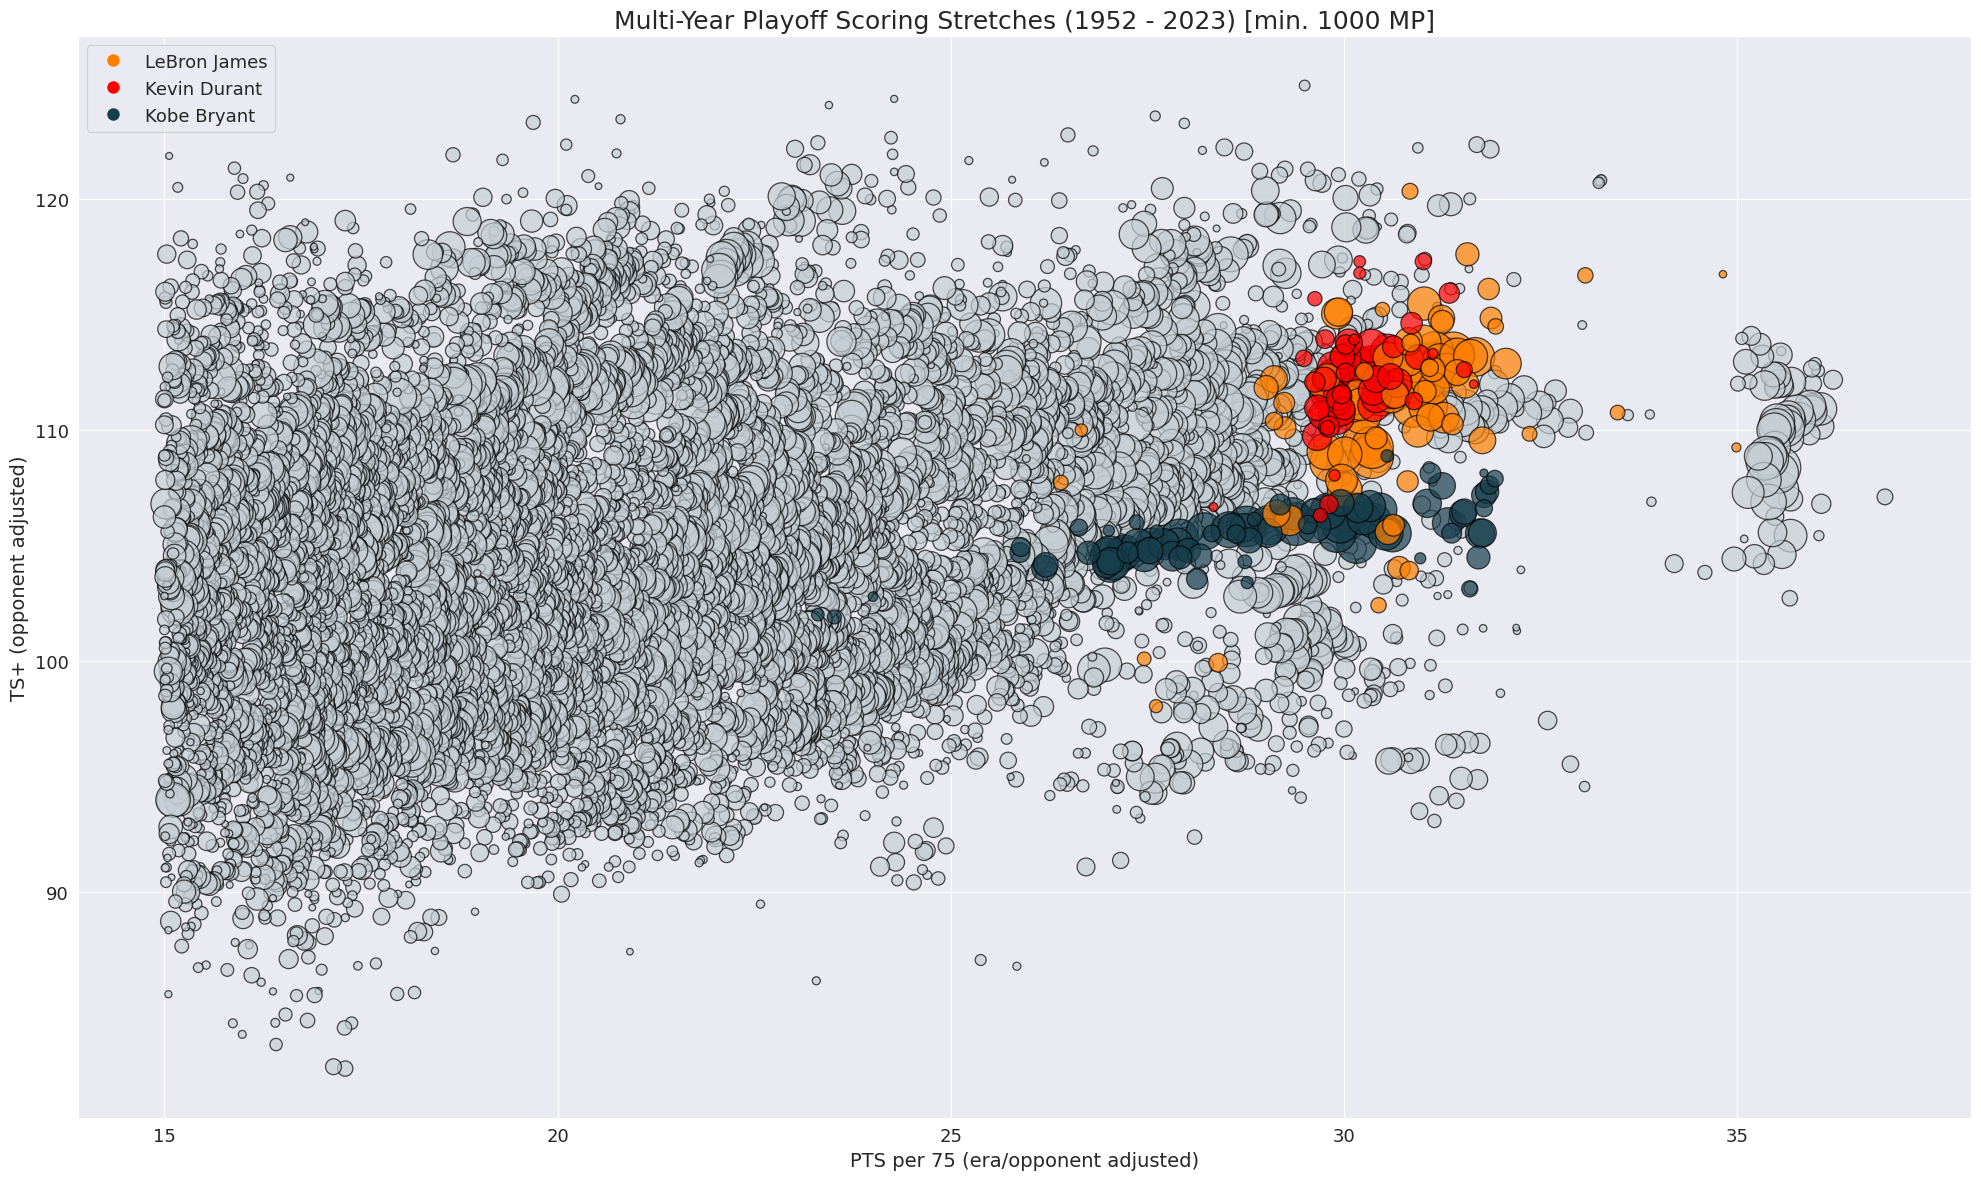

In [ ]:
plotScoring(["LeBron James", "Kevin Durant", "Kobe Bryant"], [], 15, 80, 140, 1000)

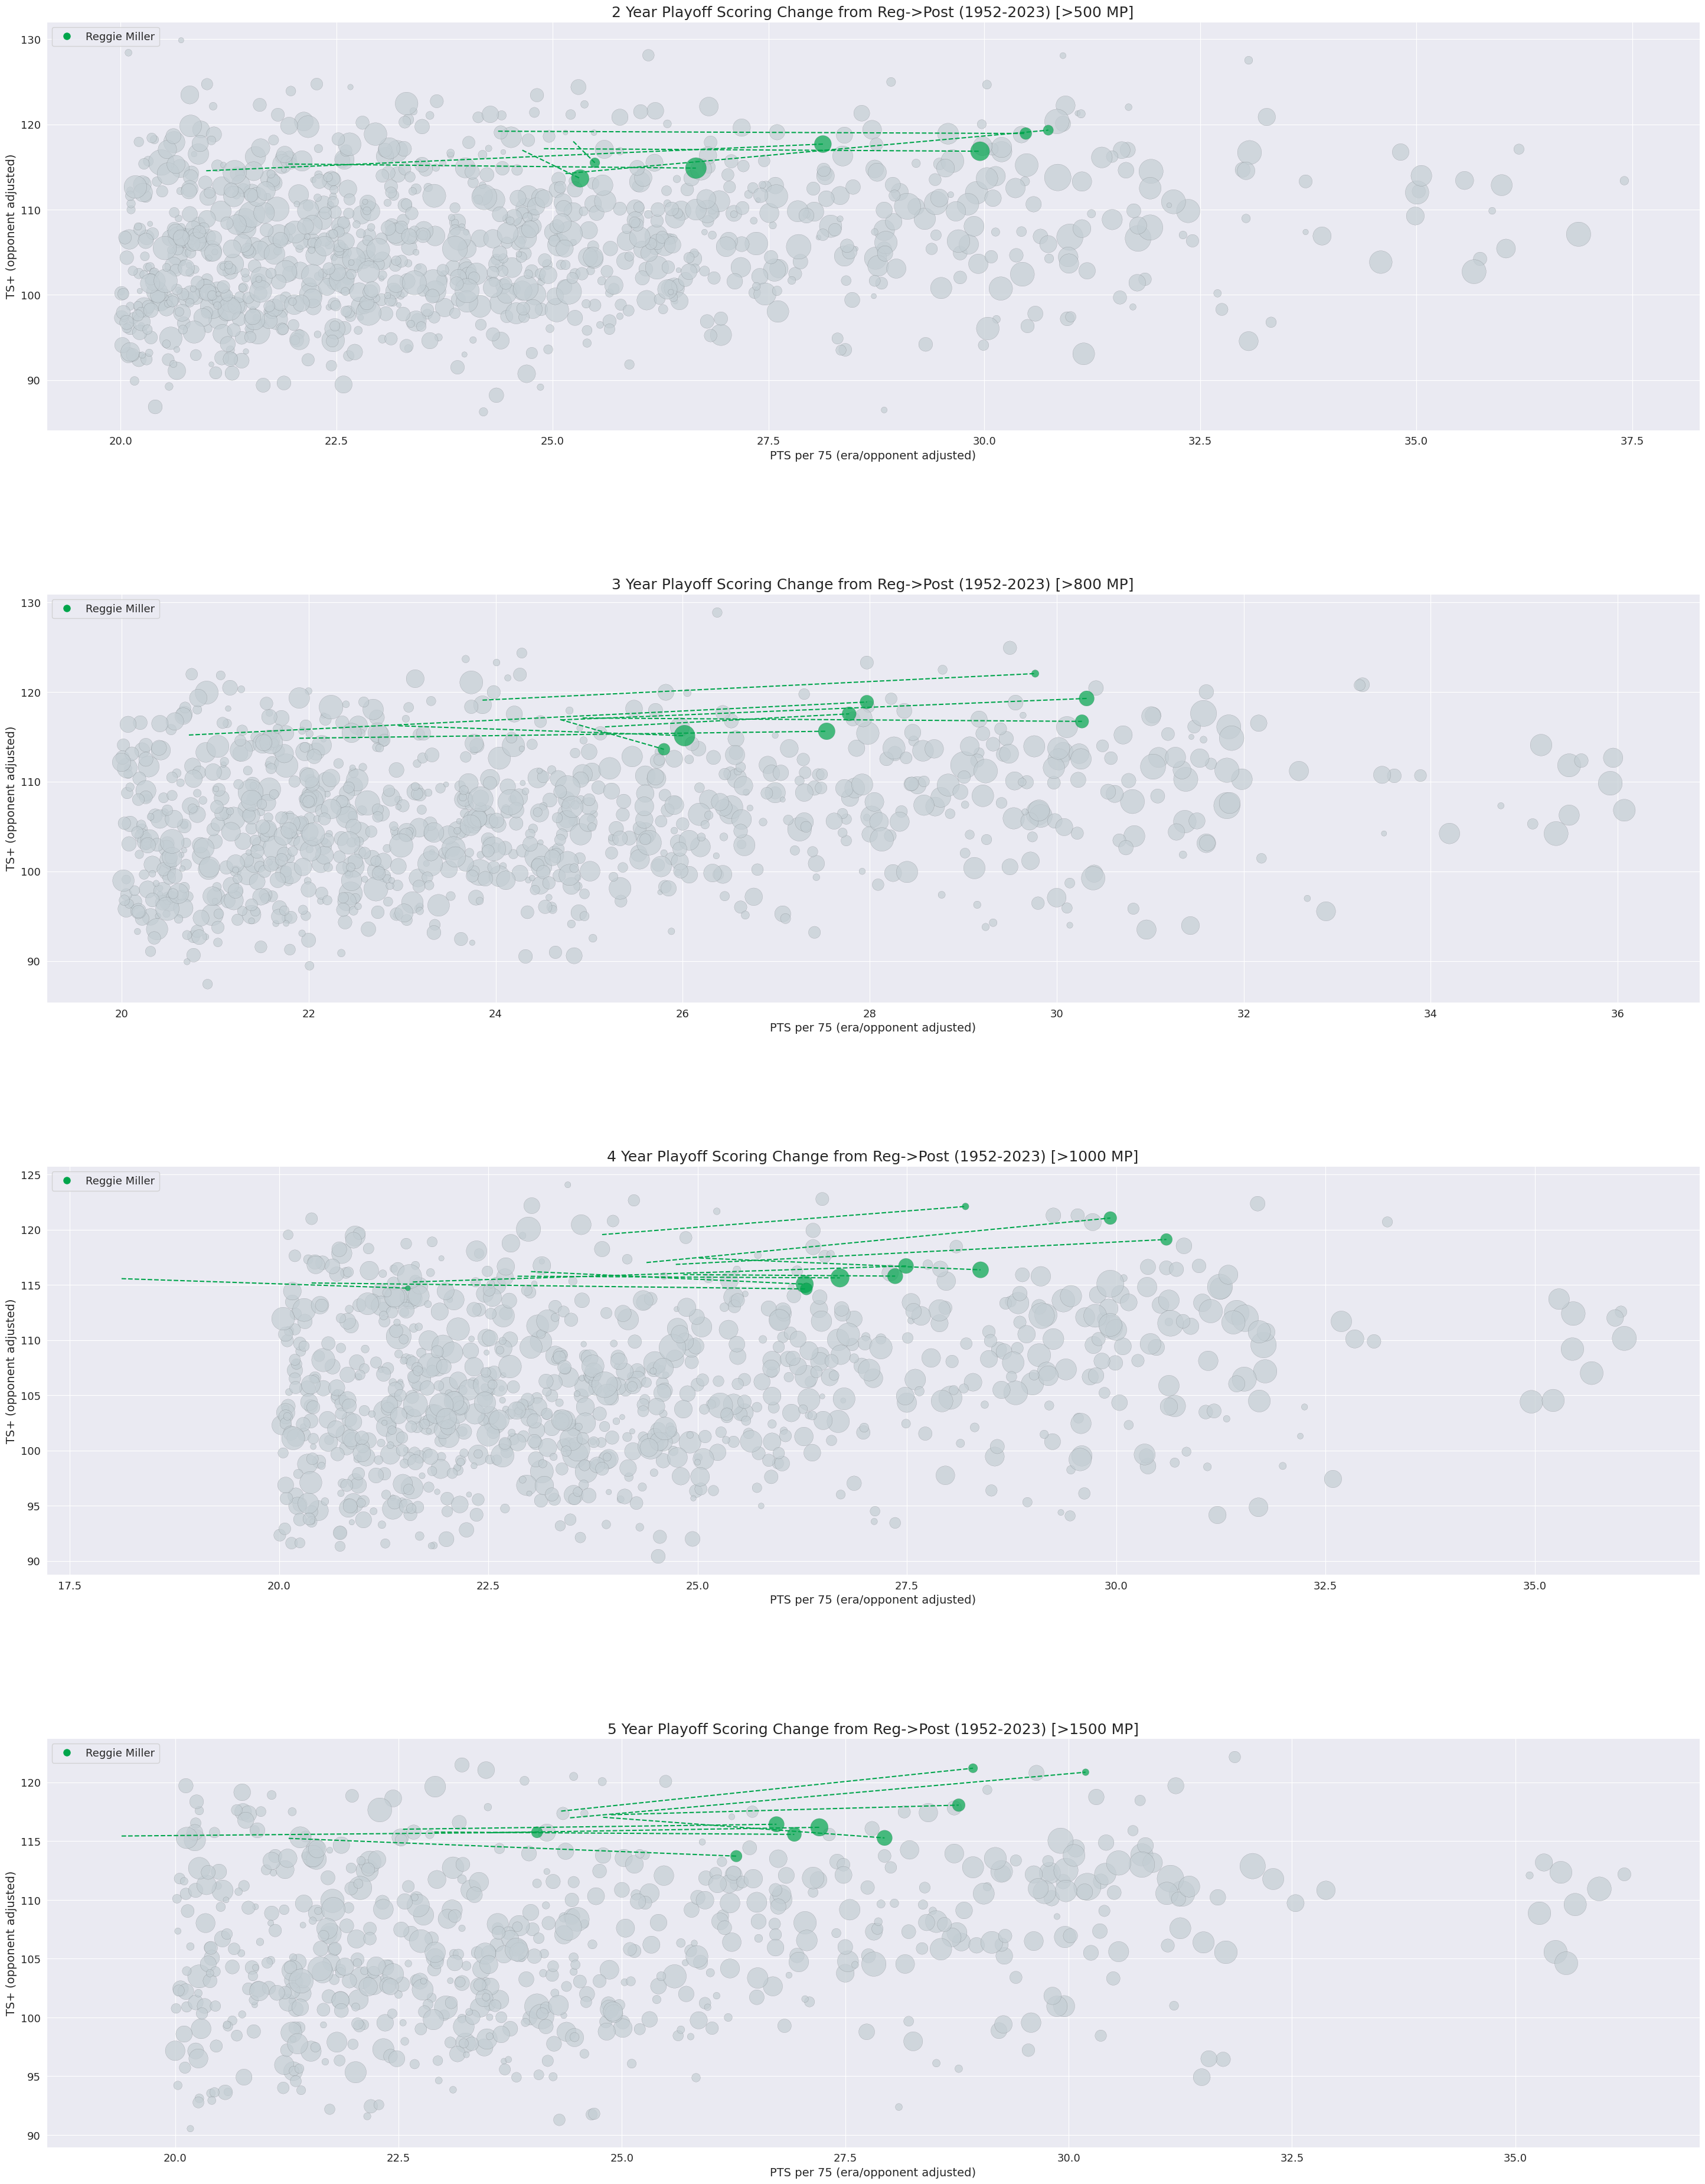

<Figure size 2000x1200 with 0 Axes>

<Figure size 2000x1200 with 0 Axes>

<Figure size 2000x1200 with 0 Axes>

<Figure size 2000x1200 with 0 Axes>

In [ ]:
plotScoringChangeWithLines(["Reggie Miller"], [], 20, 80, 130, 0, [500, 800, 1000, 1500])

In [ ]:
#@title Plot a Team's Scoring
def plotTeamScoring(first_year, last_year, team, c1, pts_floor, ts_floor, ts_ceiling, mp_floor, label):

  graph_data = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= mp_floor]

  graph_data['Year'] = graph_data['Year'].astype(int)
  graph_data = graph_data.dropna()

  first_tmp_team_df = graph_data[graph_data["Team"] == team]
  first_tmp_team_df = first_tmp_team_df[(first_tmp_team_df['Year'] >= first_year)]
  first_tmp_team_df = first_tmp_team_df[(first_tmp_team_df['Year'] <= last_year)]
  graph_data = graph_data[graph_data["Team"] != team]
  graph_data = pd.concat([graph_data, first_tmp_team_df], ignore_index=False)
  graph_data = graph_data[(graph_data['Year'] >= first_year)]
  graph_data = graph_data[(graph_data['Year'] <= last_year)]

  first_cond = (graph_data['Team']== team)
  graph_data['color'] = np.where(first_cond==True, c1, "#C4CED4")
  graph_data['MPG'] = graph_data['MP'] / graph_data['G']
  size = 100 * ((graph_data['MPG'] - (graph_data['MPG'].min() - 150)) / (graph_data['MPG'].max() - (graph_data['MPG'].min() - 150)))
  fig = plt.figure(figsize=(40,24), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.4, 'edgecolor':'k'})
  titlestring = f"Single Playoff Scoring Peaks ({first_year} - {last_year}) [min. {mp_floor} MP]"
  ax.set(title=titlestring, xlabel='PTS per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=f"{team} {first_year} - {last_year}", markerfacecolor=c1,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  ax.plot(x_pred, pred, color="k", linewidth=3)

  if label == 1:
    label_point_year(first_tmp_team_df['PTS'], first_tmp_team_df['TS+'], first_tmp_team_df['Year'], ax)
    label_point(first_tmp_team_df['PTS'], first_tmp_team_df['TS+']+0.15, first_tmp_team_df['Player'], ax)

  fig.savefig(f'{team}_Scoring', bbox_inches='tight')

In [ ]:
plotTeamScoring(1958, 1958, "BOS", "g", 15, 80, 140, 200, 1)

**PEAK FUNCTION DEFINITIONS**

In [ ]:
#@title X Year Peaks Functions

# returns if all values in a column are unique.
# used to determine if a player played for same team across x year stretch
def is_unique(s):
    a = s.to_numpy()
    return (a[0] == a).all()


# def x_yearpeak(source_df, valuestring, number_of_seasons_peak):
# returns a dataframe containing x year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts x year stretches of 'valuestring' AND the listed years from each x year stretch + minutes played across the 2 seasons.
# EX: xyearpeak(import_player_since74_per100_df, 'PTS', 3) returns 3 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2018-20', 'Kris Middleton', 'MIL' '23.32', '777' '15'
def x_yearpeak(source_df, valuestring, number_of_seasons_peak):
  x_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', f'{valuestring}', 'MP', 'G'])

  player_finished = []

  for idx, player in source_df.iterrows():

    # if player has not already been through function call
    if player['Player'] not in player_finished:
      single_player_df = source_df[(source_df['Player'] == player['Player'])]
      single_player_df = single_player_df.reset_index(drop=True)
      number_of_total_player_seasons = len(single_player_df.index)

      try:

        for season_index in range(0, number_of_total_player_seasons - (number_of_seasons_peak - 1)):

          years = ''
          non_consecutive_years = 0

          stretch_of_peak_seasons = single_player_df.iloc[season_index: season_index+number_of_seasons_peak].copy()
          mp = int(stretch_of_peak_seasons['MP'].sum())
          games = int(stretch_of_peak_seasons['G'].sum())
          stretch_of_peak_seasons[f'{valuestring}_Portion'] = stretch_of_peak_seasons[f'{valuestring}'] * (stretch_of_peak_seasons['MP'] / mp)
          valuestring_peak = stretch_of_peak_seasons[f'{valuestring}_Portion'].sum().round(2)

          if is_unique(stretch_of_peak_seasons['Team']):
            team = stretch_of_peak_seasons.iloc[0]['Team']
          else:
            team = 'TOT'

          prev_year = stretch_of_peak_seasons.iloc[0]['Year']
          for year in stretch_of_peak_seasons['Year']:
            if year - prev_year != 1 and year - prev_year != 0:
              stretch_of_peak_seasons["Year"] = stretch_of_peak_seasons["Year"].astype(str)
              years = ', '.join(stretch_of_peak_seasons["Year"])
              non_consecutive_years = 1
              break
            prev_year = year
          if non_consecutive_years == 0:
            years = f"{stretch_of_peak_seasons.iloc[0]['Year']} - {stretch_of_peak_seasons.iloc[number_of_seasons_peak-1]['Year']}"

          cols = ['Years', 'Player', 'Team', f'{valuestring}', 'MP', 'G']
          df_temp = pd.DataFrame([[years, stretch_of_peak_seasons.iloc[0]['Player'], team, valuestring_peak, mp, games]], columns=cols)
          x_year_peak = pd.concat([x_year_peak, df_temp], ignore_index=False)
          outfile = f"{number_of_seasons_peak}_year_peak_{valuestring}_data.csv"
          x_year_peak.to_csv(outfile, index=False)
        player_finished.append(stretch_of_peak_seasons.iloc[0]['Player'])
      except:
        continue


#@title X Year Peaks Functions

# returns if all values in a column are unique.
# used to determine if a player played for same team across x year stretch
def is_unique(s):
    a = s.to_numpy()
    return (a[0] == a).all()


# def x_yearpeak_2_values(source_df, valuestring, valuestring_2, number_of_seasons_peak):
# returns a dataframe containing x year stretches of 'valuestring' and 'valuestring_2' contained within pandas dataframe, 'df'.
def x_yearpeak_2_values(source_df, valuestring, valuestring_2, number_of_seasons_peak):
  x_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', f'{valuestring}', f'{valuestring_2}', 'MP', 'G'])

  player_finished = []

  for idx, player in source_df.iterrows():

    # if player has not already been through function call
    if player['Player'] not in player_finished:
      single_player_df = source_df[(source_df['Player'] == player['Player'])]
      single_player_df = single_player_df.reset_index(drop=True)
      number_of_total_player_seasons = len(single_player_df.index)

      try:

        for season_index in range(0, number_of_total_player_seasons - (number_of_seasons_peak - 1)):

          years = ''
          non_consecutive_years = 0

          stretch_of_peak_seasons = single_player_df.iloc[season_index: season_index+number_of_seasons_peak].copy()
          mp = int(stretch_of_peak_seasons['MP'].sum())
          games = int(stretch_of_peak_seasons['G'].sum())
          stretch_of_peak_seasons[f'{valuestring}_Portion'] = stretch_of_peak_seasons[f'{valuestring}'] * (stretch_of_peak_seasons['MP'] / mp)
          stretch_of_peak_seasons[f'{valuestring_2}_Portion'] = stretch_of_peak_seasons[f'{valuestring_2}'] * (stretch_of_peak_seasons['MP'] / mp)
          valuestring_peak = stretch_of_peak_seasons[f'{valuestring}_Portion'].sum().round(2)
          valuestring_peak_2 = stretch_of_peak_seasons[f'{valuestring_2}_Portion'].sum().round(2)

          if is_unique(stretch_of_peak_seasons['Team']):
            team = stretch_of_peak_seasons.iloc[0]['Team']
          else:
            team = 'TOT'

          prev_year = stretch_of_peak_seasons.iloc[0]['Year']
          for year in stretch_of_peak_seasons['Year']:
            if year - prev_year != 1 and year - prev_year != 0:
              stretch_of_peak_seasons["Year"] = stretch_of_peak_seasons["Year"].astype(str)
              years = ', '.join(stretch_of_peak_seasons["Year"])
              non_consecutive_years = 1
              break
            prev_year = year
          if non_consecutive_years == 0:
            years = f"{stretch_of_peak_seasons.iloc[0]['Year']} - {stretch_of_peak_seasons.iloc[number_of_seasons_peak-1]['Year']}"

          cols = ['Years', 'Player', 'Team', f'{valuestring}', f'{valuestring_2}', 'MP', 'G']
          df_temp = pd.DataFrame([[years, stretch_of_peak_seasons.iloc[0]['Player'], team, valuestring_peak, valuestring_peak_2, mp, games]], columns=cols)
          x_year_peak = pd.concat([x_year_peak, df_temp], ignore_index=False)
          outfile = f"{number_of_seasons_peak}_year_peak_{valuestring}_{valuestring_2}_data.csv"
          x_year_peak.to_csv(outfile, index=False)
        player_finished.append(stretch_of_peak_seasons.iloc[0]['Player'])
      except:
        continue

**PLAYER PEAK FUNCTIONS**

In [ ]:
#@title Run Scoring Peaks

stat = 'PTS'
stat_2 = 'TS+'

# 2
years = 2
x_yearpeak_2_values(era_opponent_adj_playoff_per_75_df, stat, stat_2 years)

# 3
years = 3
x_yearpeak_2_values(era_opponent_adj_playoff_per_75_df, stat, stat_2 years)

# 4
years = 4
x_yearpeak_2_values(era_opponent_adj_playoff_per_75_df, stat, stat_2 years)

# 5
years = 5
x_yearpeak_2_values(era_opponent_adj_playoff_per_75_df, stat, stat_2 years)

# 6
years = 6
x_yearpeak_2_values(era_opponent_adj_playoff_per_75_df, stat, stat_2 years)

# 7
years = 7
x_yearpeak_2_values(era_opponent_adj_playoff_per_75_df, stat, stat_2 years)

# 8
years = 8
x_yearpeak_2_values(era_opponent_adj_playoff_per_75_df, stat, stat_2 years)

# 9
years = 9
x_yearpeak_2_values(era_opponent_adj_playoff_per_75_df, stat, stat_2 years)

# 10
years = 10
x_yearpeak_2_values(era_opponent_adj_playoff_per_75_df, stat, stat_2 years)

In [ ]:
#@title Run BPM Peaks

stat = 'BPM'
stat_2 = 'OBPM'

# 2
years = 2
x_yearpeak_2_values(import_player_since74playoffs_advanced_df, stat, stat_2 years)

# 3
years = 3
x_yearpeak_2_values(import_player_since74playoffs_advanced_df, stat, stat_2 years)

# 4
years = 4
x_yearpeak_2_values(import_player_since74playoffs_advanced_df, stat, stat_2 years)

# 5
years = 5
x_yearpeak_2_values(import_player_since74playoffs_advanced_df, stat, stat_2 years)

# 6
years = 6
x_yearpeak_2_values(import_player_since74playoffs_advanced_df, stat, stat_2 years)

# 7
years = 7
x_yearpeak_2_values(import_player_since74playoffs_advanced_df, stat, stat_2 years)

# 8
years = 8
x_yearpeak_2_values(import_player_since74playoffs_advanced_df, stat, stat_2 years)

# 9
years = 9
x_yearpeak_2_values(import_player_since74playoffs_advanced_df, stat, stat_2 years)

# 10
years = 10
x_yearpeak_2_values(import_player_since74playoffs_advanced_df, stat, stat_2 years)

In [ ]:
#@title Run PBP Peaks
import_player_playoff_playbyplay_df = pd.read_csv('/content/nba_player_playoff_playbyplay_data.csv', encoding='utf8')
stat = 'OnCourt'
stat_2 = 'On-Off'

# 2
years = 2
x_yearpeak_2_values(import_player_playoff_playbyplay_df, stat, stat_2 years)

# 3
years = 3
x_yearpeak_2_values(import_player_playoff_playbyplay_df, stat, stat_2 years)

# 4
years = 4
x_yearpeak_2_values(import_player_playoff_playbyplay_df, stat, stat_2 years)

# 5
years = 5
x_yearpeak_2_values(import_player_playoff_playbyplay_df, stat, stat_2 years)

# 6
years = 6
x_yearpeak_2_values(import_player_playoff_playbyplay_df, stat, stat_2 years)

# 7
years = 7
x_yearpeak_2_values(import_player_playoff_playbyplay_df, stat, stat_2 years)

# 8
years = 8
x_yearpeak_2_values(import_player_playoff_playbyplay_df, stat, stat_2 years)

# 9
years = 9
x_yearpeak_2_values(import_player_playoff_playbyplay_df, stat, stat_2 years)

# 10
years = 10
x_yearpeak_2_values(import_player_playoff_playbyplay_df, stat, stat_2 years

**RUN YEAR MANUAL SUBSETS**

In [ ]:
#@title Manu Scoring numbers
# only 04 - 08 +/- accurate

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2003
tmp_df.loc[len(tmp_df)] = ['12.96', '.4107', '182', 'PHO', '2003', '10.53', '112.63']

tmp_df.loc[len(tmp_df)] = ['24.31', '.6364', '149', 'LAL', '2003', '-24.93', '86.63']

tmp_df.loc[len(tmp_df)] = ['18.77', '.5472', '158', 'DAL', '2003', '10.53', '112.63']

tmp_df.loc[len(tmp_df)] = ['16.05', '.4643', '171', 'NJN', '2003', '-24.93', '86.63']

# 2004
tmp_df.loc[len(tmp_df)] = ['21.32', '.5000', '106', 'MEM', '2004', '6.94', '116.75']

tmp_df.loc[len(tmp_df)] = ['27.24', '.5833', '173', 'LAL', '2004', '8.67', '100.00']

# 2005
tmp_df.loc[len(tmp_df)] = ['38.13', '.6420', '154', 'DEN', '2005', '18.88', '114.05']

tmp_df.loc[len(tmp_df)] = ['35.76', '.7000', '187', 'SEA', '2005', '7.79', '120.06']

tmp_df.loc[len(tmp_df)] = ['30.41', '.6033', '183', 'PHO', '2005', '12.23', '120.00']

tmp_df.loc[len(tmp_df)] = ['30.39', '.6139', '252', 'DET', '2005', '11.78', '104.64']

# 2006
tmp_df.loc[len(tmp_df)] = ['26.09', '.5779', '184', 'SAC', '2006', '1.14', '119.13']

tmp_df.loc[len(tmp_df)] = ['33.48', '.6271', '243', 'DAL', '2006', '2.70', '113.26']

# 2007
tmp_df.loc[len(tmp_df)] = ['25.19', '.4710', '138', 'DEN', '2007', '2.84', '107.89']

tmp_df.loc[len(tmp_df)] = ['27.37', '.5464', '197', 'PHO', '2007', '-1.07', '107.93']

tmp_df.loc[len(tmp_df)] = ['30.56', '.6143', '150', 'UTA', '2007', '8.27', '112.15']

tmp_df.loc[len(tmp_df)] = ['33.81', '.5635', '117', 'CLE', '2007', '20.62', '110.48']

# 2008
tmp_df.loc[len(tmp_df)] = ['29.35', '.5617', '155', 'PHO', '2008', '1.80', '108.71']

tmp_df.loc[len(tmp_df)] = ['33.04', '.6025', '244', 'NOH', '2008', '20.94', '106.21']

tmp_df.loc[len(tmp_df)] = ['20.72', '.5259', '160', 'LAL', '2008', '-37.92', '98.36']

# 2010
tmp_df.loc[len(tmp_df)] = ['31.75', '.5550', '199', 'DAL', '2010', '1.62', '108.91']

tmp_df.loc[len(tmp_df)] = ['26.32', '.5735', '153', 'PHO', '2010', '-7.18', '106.58']

# 2011
tmp_df.loc[len(tmp_df)] = ['31.21', '.5795', '174', 'MEM', '2011', '5.15', '106.06']

# 2012
tmp_df.loc[len(tmp_df)] = ['17.71', '.4583', '99', 'UTA', '2012', '12.05', '107.81']

tmp_df.loc[len(tmp_df)] = ['25.69', '.5490', '112', 'LAC', '2012', '3.67', '104.13']

tmp_df.loc[len(tmp_df)] = ['30.25', '.6667', '180', 'OKC', '2012', '-4.59', '109.54']

# 2013
tmp_df.loc[len(tmp_df)] = ['29.41', '.6250', '78', 'LAL', '2013', '32.22', '124.84']

tmp_df.loc[len(tmp_df)] = ['22.29', '.4471', '178', 'GSW', '2013', '15.79', '112.32']

tmp_df.loc[len(tmp_df)] = ['20.30', '.5714', '105', 'MEM', '2013', '9.21', '107.11']

tmp_df.loc[len(tmp_df)] = ['21.66', '.5548', '199', 'MIA', '2013', '-10.41', '105.08']

# 2014
tmp_df.loc[len(tmp_df)] = ['32.89', '.6050', '192', 'DAL', '2014', '9.78', '115.65']

tmp_df.loc[len(tmp_df)] = ['18.38', '.3893', '113', 'POR', '2014', '14.14', '116.67']

tmp_df.loc[len(tmp_df)] = ['32.73', '.6567', '137', 'OKC', '2014', '9.99', '117.27']

tmp_df.loc[len(tmp_df)] = ['32.53', '.6574', '143', 'MIA', '2014', '32.53', '128.35']


manual_data_df = tmp_df.copy()

print(manual_data_df)

In [ ]:
# @title Manu
tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg+'])
tmp_df = tmp_df.iloc[0:0]

# 2005
tmp_df.loc[len(tmp_df)] = ['38.13', '.6420', '154', 'DEN', '2005', '18.88', '114.05']

tmp_df.loc[len(tmp_df)] = ['35.76', '.7000', '187', 'SEA', '2005', '7.79', '120.06']

tmp_df.loc[len(tmp_df)] = ['30.41', '.6033', '183', 'PHO', '2005', '12.23', '120.00']

tmp_df.loc[len(tmp_df)] = ['30.39', '.6139', '252', 'DET', '2005', '11.78', '104.64']

# 2006
tmp_df.loc[len(tmp_df)] = ['26.09', '.5779', '184', 'SAC', '2006', '1.14', '119.13']

tmp_df.loc[len(tmp_df)] = ['33.48', '.6271', '243', 'DAL', '2006', '2.70', '113.26']

# 2007
tmp_df.loc[len(tmp_df)] = ['25.19', '.4710', '138', 'DEN', '2007', '2.84', '107.89']

tmp_df.loc[len(tmp_df)] = ['27.37', '.5464', '197', 'PHO', '2007', '-1.07', '107.93']

tmp_df.loc[len(tmp_df)] = ['30.56', '.6143', '150', 'UTA', '2007', '8.27', '112.15']

tmp_df.loc[len(tmp_df)] = ['33.81', '.5635', '117', 'CLE', '2007', '20.62', '110.48']

manual_data_df = tmp_df.copy()


# offfffffffffffffffffffffffffffff

# 2005

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg+'])
tmp_df = tmp_df.iloc[0:0]

tmp_df.loc[len(tmp_df)] = ['-100', '-100', '91', 'DEN', '2005', '-100', '100.00']

tmp_df.loc[len(tmp_df)] = ['-100', '-100', '101', 'SEA', '2005', '-100', '99.44']

tmp_df.loc[len(tmp_df)] = ['-100', '-100', '57', 'PHO', '2005', '-100', '105.10']

tmp_df.loc[len(tmp_df)] = ['-100', '-100', '89', 'DET', '2005', '-100', '98.62']

# 2006
tmp_df.loc[len(tmp_df)] = ['-100', '-100', '109', 'SAC', '2006', '-100', '114.43']

tmp_df.loc[len(tmp_df)] = ['-100', '-100', '103', 'DAL', '2006', '-100', '98.98']

manual_data_df = tmp_df.copy()

# 4+
tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg+'])
tmp_df = tmp_df.iloc[0:0]

tmp_df.loc[len(tmp_df)] = ['-100', '-100', '77', 'DEN', '2005', '-100', '110.27']

tmp_df.loc[len(tmp_df)] = ['-100', '-100', '69', 'SEA', '2005', '-100', '140.16']

tmp_df.loc[len(tmp_df)] = ['-100', '-100', '149', 'PHO', '2005', '-100', '120.20']

tmp_df.loc[len(tmp_df)] = ['-100', '-100', '171', 'DET', '2005', '-100', '104.15']

# 2006
tmp_df.loc[len(tmp_df)] = ['-100', '-100', '107', 'SAC', '2006', '-100', '118.18']

tmp_df.loc[len(tmp_df)] = ['-100', '-100', '102', 'DAL', '2006', '-100', '108.65']

manual_data_df = tmp_df.copy()





# offffffffffffffffffffffff

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg+'])
tmp_df = tmp_df.iloc[0:0]

tmp_df.loc[len(tmp_df)] = ['-100', '-100', '56', 'DEN', '2005', '-100', '91.75']

tmp_df.loc[len(tmp_df)] = ['-100', '-100', '56', 'SEA', '2005', '-100', '94.85']

tmp_df.loc[len(tmp_df)] = ['-100', '-100', '42', 'PHO', '2005', '-100', '102.78']

tmp_df.loc[len(tmp_df)] = ['-100', '-100', '53', 'DET', '2005', '-100', '98.75']

# 2006
tmp_df.loc[len(tmp_df)] = ['-100', '-100', '61', 'SAC', '2006', '-100', '114.41']

tmp_df.loc[len(tmp_df)] = ['-100', '-100', '54', 'DAL', '2006', '-100', '108.57']

manual_data_df = tmp_df.copy()

In [ ]:
#@title Kobe

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg+'])
tmp_df = tmp_df.iloc[0:0]

manual_data_df = tmp_df.copy()

#Kobe
tmp_df.loc[len(tmp_df)] = ['25.57', '.4997', '149', 'HOU', '1999', '36.35', '128.57']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

#Kobe
tmp_df.loc[len(tmp_df)] = ['26.28', '.5201', '168', 'SAS', '1999', '36.35', '128.57']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

#Kobe
tmp_df.loc[len(tmp_df)] = ['37.72', '.5565', '193', 'SAC', '2000', '36.35', '128.57']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['28.89', '.5476', '187', 'PHO', '2000', '36.35', '128.57']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['26.38', '.5235', '303', 'POR', '2000', '36.35', '128.57']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['18.03', '.4112', '176', 'IND', '2000', '36.35', '128.57']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['33.94', '.5462', '119', 'POR', '2001', '28.59', '122.17']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['40.00', '.588', '173', 'SAC', '2001', '11.15', '110.86']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['42.36', '.571', '168', 'SAS', '2001', '23.54', '116.24']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['27.83', '.501', '234', 'PHI', '2001', '7.47', '108.37']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['31.45', '.4688', '131', 'POR', '2002', '2.82', '102.42']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['33.42', '.486', '218', 'SAS', '2002', '6.38', '105.36']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['30.89', '.491', '308', 'SAC', '2002', '-1.00', '102.44']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['31.85', '.623', '174', 'NJN', '2002', '11.06', '116.96']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['35.77', '.5250', '270', 'MIN', '2003', '7.47', '111.99']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['39.27', '.533', '261', 'SAS', '2003', '-4.67', '104.25']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['30.05', '.507', '233', 'HOU', '2004', '7.37', '98.77']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['32.64', '.534', '264', 'SAS', '2004', '8.61', '101.86']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['31.81', '.519', '255', 'MIN', '2004', '3.72', '108.93']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['27.49', '.456', '231', 'DET', '2004', '-13.68', '91.97']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['32.45', '.5706', '314', 'PHO', '2006', '-9.33', '105.66']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['38.95', '.5660', '215', 'PHO', '2007', '-9.87', '105.70']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)


# Kobe rOffRtg

tmp_df.loc[len(tmp_df)] = ['41.88', '.5917', '157', 'DEN', '2008', '14.36', '118.75']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['40.7', '.6195', '247', 'UTA', '2008', '6.16', '118.40']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['38.42', '.585', '201', 'SAS', '2008', '7.11', '106.05']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['31.56', '.4902', '258', 'BOS', '2008', '-7.54', '103.89']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['34.34', '.5714', '203', 'UTA', '2009', '11.28', '113.28']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['38.55', '.5306', '266', 'HOU', '2009', '10.43', '111.65']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['41.8', '.6171', '252', 'DEN', '2009', '5.69', '116.39']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['40.60', '.5227', '219', 'ORL', '2009', '12.78', '112.28']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['33.73', '.5036', '221', 'OKC', '2010', '5.75', '107.66']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['40.25', '.6038', '164', 'UTA', '2010', '6.53', '118.87']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['42.26', '.6329', '249', 'PHO', '2010', '8.0', '127.41']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['38.31', '.5293', '288', 'BOS', '2010', '1.53', '104.02']
manual_data_df = pd.concat([manual_data_df, tmp_df], ignore_index=True)
tmp_df.drop(tmp_df.index,inplace=True)

manual_data_df = manual_data_df.reset_index(drop=True)

print(manual_data_df)

In [ ]:
#@title Adjusted Playoff TS+ of Manual Subset
def manual_adjust_scoring_efficiency(player_df, opp_ts_df, opp_defrtg_df, opp_literal_defrtg, player):

      final_season_df = pd.DataFrame(columns = ['Player', 'Year', 'PP75', 'TS+', 'NetRtg', 'OffRtg+', 'MP'])

      years_list = []

      player_df['PP75'] = player_df['PP75'].astype(float)
      player_df['PP75'] = player_df['PP75'] * .75


      player_df['TS%'] = player_df['TS%'].astype(float)

      opp_ts_df['Team'] = opp_ts_df['Team'].astype(str)
      opp_ts_df['Year'] = opp_ts_df['Year'].astype(int)
      opp_defrtg_df['Team'] = opp_defrtg_df['Team'].astype(str)
      opp_defrtg_df['Year'] = opp_defrtg_df['Year'].astype(int)
      opp_literal_defrtg['Team'] = opp_literal_defrtg['Team'].astype(str)
      opp_literal_defrtg['Year'] = opp_literal_defrtg['Year'].astype(int)
      player_df['Opp'] = player_df['Opp'].astype(str)
      player_df['Year'] = player_df['Year'].astype(int)

      for i, row in player_df.iterrows():

        current_opp = player_df.loc[i, 'Opp']
        current_year = player_df.loc[i, 'Year']

        era_adjustment_df = nba_per75_coeff[(nba_per75_coeff['Year'] == current_year)]
        player_df.loc[i,'PP75'] = player_df.loc[i,'PP75'] * float(era_adjustment_df['Coefficient'])

        opponent_ts = opp_ts_df[(opp_ts_df['Team'] == current_opp) & (opp_ts_df['Year'] == current_year)]
        opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

        opponent_def = opp_defrtg_df[(opp_defrtg_df['Team'] == current_opp) & ((opp_defrtg_df['Year'] == current_year))]
        pts_coeff = float(opponent_def['PTS_coeff'])

        opponent_literal_def = opp_literal_defrtg[(opp_literal_defrtg['Team'] == current_opp) & ((opp_literal_defrtg['Year'] == current_year))]
        opp_def_rtg = float(opponent_literal_def['DefRtg'])

        player_ts = player_df.loc[i, 'TS%']
        tsplus = (float(player_ts) / float(opponent_ts['TS% Allowed'])) * 100
        relOffRtg = float(row['OffRtg+']) / opp_def_rtg * 100

        sub_coeff = nba_per75_coeff[(nba_per75_coeff['Year'] == row['Year'])]
        row['PP75'] = float((row['PP75'] * sub_coeff['Coefficient']))



        player_df.loc[i,'TS+'] = tsplus
        player_df.loc[i,'PTS_coeff'] = pts_coeff
        player_df.loc[i,'OffRtg+'] = relOffRtg


        if player_df.loc[i, 'Year'] not in years_list:
          years_list.append(player_df.loc[i, 'Year'])

      tmp_series_df = pd.DataFrame(columns = ['Year', 'OPP', 'MP', 'TS%', 'PTS', 'PTS_coeff'])
      for year in years_list:
        tmp_sub_df = player_df[(player_df['Year'] == year)]

        total_pts = 0
        total_ts = 0
        total_mp = 0
        total_coeff = 0
        total_net = 0
        total_off = 0

        mp_list = []
        #MP
        for ind_mp in tmp_sub_df['MP']:
          ind_mp = float(ind_mp)
          mp_list.append(ind_mp)
          total_mp += ind_mp
          if total_mp == 0:
            total_mp = 1
        #TS
        iter = 0
        for ind_ts in tmp_sub_df['TS+']:
          ind_ts = float(ind_ts)
          total_ts += float(ind_ts) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1
         #PTS
        iter = 0
        for ind_pts in tmp_sub_df['PP75']:
          ind_pts = float(ind_pts)
          total_pts += float(ind_pts) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1
        iter = 0
        #coeff
        for ind_coeff in tmp_sub_df['PTS_coeff']:
          ind_coeff = float(ind_coeff)
          print(ind_coeff)
          total_coeff += float(ind_coeff) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1
        print(total_coeff)
        total_pts = total_pts * total_coeff


        # NetRtg
        iter = 0
        for ind_coeff in tmp_sub_df['NetRtg']:
          ind_net = float(ind_coeff)
          total_net += float(ind_coeff) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1

        # OffRtg
        iter = 0
        for ind_coeff in tmp_sub_df['OffRtg+']:
          ind_off = float(ind_coeff)
          total_off += float(ind_coeff) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1

        total_pts = '%.2f' % round(total_pts, 2)
        total_ts = '%.2f' % round(total_ts, 2)
        total_off = '%.2f' % round(total_off, 2)
        total_net = '%.2f' % round(total_net, 2)

        cols = ['Player', 'Year', 'PP75', 'TS+', 'NetRtg', 'OffRtg+', 'MP']
        df_temp = pd.DataFrame([[player, year, total_pts, total_ts, total_net, total_off, int(total_mp)]], columns=cols)
        print(df_temp)
        final_season_df = pd.concat([final_season_df, df_temp], ignore_index=True)
      print(final_season_df)
      outfile = f"NBA_Playoff_Manual_Adjusted_TS_df.csv"
      final_season_df.to_csv(outfile, index=False)

In [ ]:
#@title Inflate Scoring for Manual Subset
nba_per75_coeff['Year'] = nba_per75_coeff['Year'].astype(int)
manual_data_df['Year'] = manual_data_df['Year'].astype(float)
manual_data_df['PP75'] = manual_data_df['PP75'].astype(float)
manual_data_df['TS%'] = manual_data_df['TS%'].astype(float)
manual_data_df['MP'] = manual_data_df['MP'].astype(int)
manual_data_df['Opp'] = manual_data_df['Opp'].astype(str)
print(manual_data_df)

pd.options.mode.chained_assignment = None
team_ts_allowed_df = pd.read_csv('/content/nba_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
team_ts_allowed_df['TS% Allowed'] = team_ts_allowed_df['TS% Allowed'].astype(float)
team_ts_allowed_df['Year'] = team_ts_allowed_df['Year'].astype(int)

opp_literal_defrtg = pd.read_csv('/content/nba_Team_DefRtg_Allowed_df.csv', index_col=False, encoding='utf8')
opp_literal_defrtg['Year'] = opp_literal_defrtg['Year'].astype(int)


opponent_adj_pts_coeff = pd.read_csv('/content/nba_aba_opponent_adj_pts_coeff_74_23.csv', index_col=False, encoding='utf8')
opponent_adj_pts_coeff['Year'] = opponent_adj_pts_coeff['Year'].astype(int)

manual_adjust_scoring_efficiency(manual_data_df, team_ts_allowed_df, opponent_adj_pts_coeff, opp_literal_defrtg, 'Kobe Bryant')

#Manu Ginóbili

In [ ]:
#@title Manual X Year Peaks Functions

# returns if all values in a column are unique.
# used to determine if a player played for same team across x year stretch
def is_unique(s):
    a = s.to_numpy()
    return (a[0] == a).all()


# def x_yearpeak(source_df, valuestring, number_of_seasons_peak):
# returns a dataframe containing x year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts x year stretches of 'valuestring' AND the listed years from each x year stretch + minutes played across the 2 seasons.
# EX: xyearpeak(import_player_since74_per100_df, 'PTS', 3) returns 3 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2018-20', 'Kris Middleton', 'MIL' '23.32', '777' '15'
def x_yearpeak_manual(source_df, valuestring, valuestring_2, valuestring_3, valuestring_4, number_of_seasons_peak):
  x_year_peak = pd.DataFrame(columns = ['Years', 'Player', f'{valuestring}', f'{valuestring_2}', f'{valuestring_3}', f'{valuestring_4}', 'MP'])

  player_finished = []

  for idx, player in source_df.iterrows():

    # if player has not already been through function call
    if player['Player'] not in player_finished:
      single_player_df = source_df[(source_df['Player'] == player['Player'])]
      single_player_df = single_player_df.reset_index(drop=True)
      number_of_total_player_seasons = len(single_player_df.index)
      for season_index in range(0, number_of_total_player_seasons - (number_of_seasons_peak - 1)):

        years = ''
        non_consecutive_years = 0

        stretch_of_peak_seasons = single_player_df.iloc[season_index: season_index+number_of_seasons_peak].copy()
        mp = int(stretch_of_peak_seasons['MP'].sum())
        stretch_of_peak_seasons[f'{valuestring}_Portion'] = stretch_of_peak_seasons[f'{valuestring}'] * (stretch_of_peak_seasons['MP'] / mp)
        stretch_of_peak_seasons[f'{valuestring_2}_Portion'] = stretch_of_peak_seasons[f'{valuestring_2}'] * (stretch_of_peak_seasons['MP'] / mp)
        stretch_of_peak_seasons[f'{valuestring_3}_Portion'] = stretch_of_peak_seasons[f'{valuestring_3}'] * (stretch_of_peak_seasons['MP'] / mp)
        stretch_of_peak_seasons[f'{valuestring_4}_Portion'] = stretch_of_peak_seasons[f'{valuestring_4}'] * (stretch_of_peak_seasons['MP'] / mp)
        valuestring_peak = stretch_of_peak_seasons[f'{valuestring}_Portion'].sum().round(2)
        valuestring_peak_2 = stretch_of_peak_seasons[f'{valuestring_2}_Portion'].sum().round(2)
        valuestring_peak_3 = stretch_of_peak_seasons[f'{valuestring_3}_Portion'].sum().round(2)
        valuestring_peak_4 = stretch_of_peak_seasons[f'{valuestring_4}_Portion'].sum().round(2)


        prev_year = stretch_of_peak_seasons.iloc[0]['Year']
        for year in stretch_of_peak_seasons['Year']:
          if year - prev_year != 1 and year - prev_year != 0:
            stretch_of_peak_seasons["Year"] = stretch_of_peak_seasons["Year"].astype(str)
            years = ', '.join(stretch_of_peak_seasons["Year"])
            non_consecutive_years = 1
            break
          prev_year = year
        if non_consecutive_years == 0:
          years = f"{stretch_of_peak_seasons.iloc[0]['Year']} - {stretch_of_peak_seasons.iloc[number_of_seasons_peak-1]['Year']}"

        cols = ['Years', 'Player', f'{valuestring}', f'{valuestring_2}', f'{valuestring_3}', f'{valuestring_4}', 'MP']
        df_temp = pd.DataFrame([[years, stretch_of_peak_seasons.iloc[0]['Player'], valuestring_peak, valuestring_peak_2, valuestring_peak_3, valuestring_peak_4, mp]], columns=cols)
        x_year_peak = pd.concat([x_year_peak, df_temp], ignore_index=False)
        outfile = f"{number_of_seasons_peak}_year_peak_manual_data.csv"
        x_year_peak.to_csv(outfile, index=False)
      player_finished.append(stretch_of_peak_seasons.iloc[0]['Player'])

In [ ]:
# 2

final_season_df = pd.read_csv('/content/NBA_Playoff_Manual_Adjusted_TS_df.csv', index_col=False, encoding='utf8')
years = 3
stat = 'PP75'
x_yearpeak_manual(final_season_df, stat, stat, stat, stat, years)
import_player_PTS_peaks_df = pd.read_csv(f'{years}_year_peak_manual_data.csv', encoding='utf8')
print(import_player_PTS_peaks_df)

years = 3
stat = 'TS+'
x_yearpeak_manual(final_season_df, stat, stat, stat, stat, years)
import_player_PTS_peaks_df = pd.read_csv(f'{years}_year_peak_manual_data.csv', encoding='utf8')
print(import_player_PTS_peaks_df)

years = 2
stat = 'OffRtg+'
x_yearpeak_manual(final_season_df, stat, stat, stat, stat, years)
import_player_PTS_peaks_df = pd.read_csv(f'{years}_year_peak_manual_data.csv', encoding='utf8')
print(import_player_PTS_peaks_df)

In [ ]:
#@title Manual X Year Peaks
final_season_df = pd.read_csv('/content/NBA_Playoff_Manual_Adjusted_TS_df.csv', index_col=False, encoding='utf8')
print(final_season_df)
# 4
years = 3
stat = 'PP75'
x_yearpeak(final_season_df, stat, years)
import_player_PTS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_PTS_peaks_df.to_csv(outfile, index=False)
print(import_player_PTS_peaks_df)

years = 3
stat = 'TS+'
x_yearpeak(final_season_df, stat, years)
import_player_TS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_TS_peaks_df.to_csv(outfile, index=False)
print(import_player_TS_peaks_df)

In [ ]:
#@title (Series) Adjusted Playoff TS+ of Manual Subset
def manual_adjust_scoring_efficiency_series(player_df, opp_ts_df, opp_defrtg_df, opp_literal_defrtg, player):

      final_season_df = pd.DataFrame(columns = ['Player', 'Series', 'PP75', 'TS+', 'NetRtg', 'rOffRtg', 'MP'])

      series_list = []

      player_df['PP75'] = player_df['PP75'].astype(float)
      player_df['PP75'] = player_df['PP75'] * .75


      player_df['TS%'] = player_df['TS%'].astype(float)

      opp_ts_df['Team'] = opp_ts_df['Team'].astype(str)
      opp_ts_df['Year'] = opp_ts_df['Year'].astype(int)
      opp_defrtg_df['Team'] = opp_defrtg_df['Team'].astype(str)
      opp_defrtg_df['Year'] = opp_defrtg_df['Year'].astype(int)
      opp_literal_defrtg['Team'] = opp_literal_defrtg['Team'].astype(str)
      opp_literal_defrtg['Year'] = opp_literal_defrtg['Year'].astype(int)
      player_df['Opp'] = player_df['Opp'].astype(str)
      player_df['Year'] = player_df['Year'].astype(int)

      for i, row in player_df.iterrows():

        current_opp = player_df.loc[i, 'Opp']
        current_year = player_df.loc[i, 'Year']

        opponent_ts = opp_ts_df[(opp_ts_df['Team'] == current_opp) & (opp_ts_df['Year'] == current_year)]
        opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

        opponent_def = opp_defrtg_df[(opp_defrtg_df['Team'] == current_opp) & ((opp_defrtg_df['Year'] == current_year))]
        pts_coeff = float(opponent_def['PTS_coeff'])

        opponent_literal_def = opp_literal_defrtg[(opp_literal_defrtg['Team'] == current_opp) & ((opp_literal_defrtg['Year'] == current_year))]
        opp_def_rtg = float(opponent_literal_def['DefRtg'])

        player_ts = player_df.loc[i, 'TS%']
        tsplus = (float(player_ts) / float(opponent_ts['TS% Allowed'])) * 100
        relOffRtg = float(row['OffRtg']) - opp_def_rtg

        player_df.loc[i,'TS+'] = tsplus
        player_df.loc[i,'PTS_coeff'] = pts_coeff
        player_df.loc[i,'rOffRtg'] = relOffRtg


      for idx, row in player_df.iterrows():
        total_pts = 0
        total_ts = 0
        total_mp = 0
        total_coeff = 0
        total_net = 0
        total_off = 0

        total_mp = int(row['MP'])
        total_ts = float(row['TS+'])
        total_pts = float(row['PP75'])
        total_coeff = float(row['PTS_coeff'])
        total_pts = total_pts * total_coeff


        total_net = float(row['NetRtg'])
        total_off = float(row['rOffRtg'])

        total_pts = '%.2f' % round(total_pts, 2)
        total_ts = '%.2f' % round(total_ts, 2)
        total_off = '%.2f' % round(total_off, 2)
        total_net = '%.2f' % round(total_net, 2)

        series = str(row['Year'])
        series = series + " "
        series = series + str(row['Opp'])

        cols = ['Player', 'Series', 'PP75', 'TS+', 'NetRtg', 'rOffRtg', 'MP']
        df_temp = pd.DataFrame([[player, series, total_pts, total_ts, total_net, total_off, int(total_mp)]], columns=cols)
        final_season_df = pd.concat([final_season_df, df_temp], ignore_index=True)
      print(final_season_df)
      outfile = f"NBA_Playoff_Series_Manual_Adjusted_TS_df.csv"
      final_season_df.to_csv(outfile, index=False)

In [ ]:
#@title (Series) Inflate Scoring for Manual Subset
new_df = pd.DataFrame()
nba_per75_coeff['Year'] = nba_per75_coeff['Year'].astype(int)
manual_data_df['Year'] = manual_data_df['Year'].astype(float)
manual_data_df['PP75'] = manual_data_df['PP75'].astype(float)
for idx, row in manual_data_df.iterrows():
  sub_coeff = nba_per75_coeff[(nba_per75_coeff['Year'] == row['Year'])]
  row['PP75'] = float((row['PP75'] * sub_coeff['Coefficient']))
  listed_row = [manual_data_df.iloc[idx]]
  tmp_df = pd.DataFrame(listed_row)
  new_df = pd.concat([new_df, tmp_df], ignore_index=True)
new_df['Year'] = new_df['Year'].astype(int)
new_df['PP75'] = new_df['PP75'].astype(float)
new_df['TS%'] = new_df['TS%'].astype(float)
new_df['MP'] = new_df['MP'].astype(int)
new_df['Opp'] = new_df['Opp'].astype(str)

pd.options.mode.chained_assignment = None
team_ts_allowed_df = pd.read_csv('/content/nba_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
team_ts_allowed_df['TS% Allowed'] = team_ts_allowed_df['TS% Allowed'].astype(float)
team_ts_allowed_df['Year'] = team_ts_allowed_df['Year'].astype(int)

opp_literal_defrtg = pd.read_csv('/content/nba_Team_DefRtg_Allowed_df.csv', index_col=False, encoding='utf8')
opp_literal_defrtg['Year'] = opp_literal_defrtg['Year'].astype(int)


opponent_adj_pts_coeff = pd.read_csv('/content/nba_aba_opponent_adj_pts_coeff_74_23.csv', index_col=False, encoding='utf8')
opponent_adj_pts_coeff['Year'] = opponent_adj_pts_coeff['Year'].astype(int)

manual_adjust_scoring_efficiency(new_df, team_ts_allowed_df, opponent_adj_pts_coeff, opp_literal_defrtg, 'Manu Ginóbili')

#Manu Ginóbili

**REB/AST CHANGES**

In [ ]:
#@title Create Final DataFrame of Reg AST/REB Data

aba_68_73_df = pd.read_csv('/content/aba_68-73_reg_per75_data.csv', index_col=False, encoding='utf8')
aba_74_76_df = pd.read_csv('/content/aba_74-76_reg_per75_data.csv', index_col=False, encoding='utf8')
nba_52_73_df = pd.read_csv('/content/nba_52-73_reg_per75_data.csv', index_col=False, encoding='utf8')
nba_74_23_df = pd.read_csv('/content/nba_74-23_reg_per75_data.csv', index_col=False, encoding='utf8')

total_df = pd.DataFrame()

tmp_df = pd.DataFrame()
tmp_df['Player'] = aba_68_73_df['Player']
tmp_df['Year'] = aba_68_73_df['Year']
tmp_df['Tm'] = aba_68_73_df['Tm']
tmp_df['TRB'] = aba_68_73_df['TRB']
tmp_df['AST'] = aba_68_73_df['AST']
tmp_df['MP'] = aba_68_73_df['MP']
tmp_df['G'] = aba_68_73_df['G']
tmp_df['Year'] = aba_68_73_df['Year'].astype(int)
total_df = pd.concat([total_df, tmp_df], ignore_index=True)

tmp_df = pd.DataFrame()
tmp_df['Player'] = aba_74_76_df['Player']
tmp_df['Year'] = aba_74_76_df['Year']
tmp_df['Tm'] = aba_74_76_df['Tm']
tmp_df['TRB'] = aba_74_76_df['TRB']
tmp_df['AST'] = aba_74_76_df['AST']
tmp_df['MP'] = aba_74_76_df['MP']
tmp_df['G'] = aba_74_76_df['G']
tmp_df['Year'] = aba_74_76_df['Year'].astype(int)
total_df = pd.concat([total_df, tmp_df], ignore_index=True)

tmp_df = pd.DataFrame()
tmp_df['Player'] = nba_52_73_df['Player']
tmp_df['Year'] = nba_52_73_df['Year']
tmp_df['Tm'] = nba_52_73_df['Tm']
tmp_df['TRB'] = nba_52_73_df['TRB']
tmp_df['AST'] = nba_52_73_df['AST']
tmp_df['MP'] = nba_52_73_df['MP']
tmp_df['G'] = nba_52_73_df['G']
tmp_df['Year'] = nba_52_73_df['Year'].astype(int)
total_df = pd.concat([total_df, tmp_df], ignore_index=True)

tmp_df = pd.DataFrame()
tmp_df['Player'] = nba_74_23_df['Player']
tmp_df['Year'] = nba_74_23_df['Year']
tmp_df['Tm'] = nba_74_23_df['Tm']
tmp_df['TRB'] = nba_74_23_df['TRB']
tmp_df['AST'] = nba_74_23_df['AST']
tmp_df['MP'] = nba_74_23_df['MP']
tmp_df['G'] = nba_74_23_df['G']
tmp_df['Year'] = nba_74_23_df['Year'].astype(int)
total_df = pd.concat([total_df, tmp_df], ignore_index=True)

total_df = total_df.sort_values(['Player', 'Year'], ascending=[True, True])
print(total_df)
total_df.to_csv('reg_Rebound_Assist_df.csv', index=False)

In [ ]:
#@title Create Final DataFrame of Playoff AST/REB Data

adj_ts_list = pd.read_csv('/content/Playoff_Adjusted_TS_df.csv', index_col=False, encoding='utf8')

# NBA 1974-2023
nba_74_23 = pd.read_csv('nba_74-23_playoff_per75_data.csv', index_col=False, encoding='utf8')
nba_74_23['Player'] = nba_74_23['Player'].astype(str)
nba_74_23['Year'] = nba_74_23['Year'].astype(str)

# ABA 1974-76
aba_74_76 = pd.read_csv('aba_74-76_playoff_per75_data.csv', index_col=False, encoding='utf8')
aba_74_76['Player'] = aba_74_76['Player'].astype(str)
aba_74_76['Year'] = aba_74_76['Year'].astype(str)

# ABA 1968-73
aba_68_73 = pd.read_csv('aba_68-73_playoff_per75_data.csv', index_col=False, encoding='utf8')
aba_68_73['Player'] = aba_68_73['Player'].astype(str)
aba_68_73['Year'] = aba_68_73['Year'].astype(str)

# NBA 1952-73
nba_52_73 = pd.read_csv('nba_52-73_playoff_per75_data.csv', index_col=False, encoding='utf8')
nba_52_73['Player'] = nba_52_73['Player'].astype(str)
nba_52_73['Year'] = nba_52_73['Year'].astype(str)


# NBA 1974-2022
names = [x for x in nba_74_23.columns]
adjusted_playoff_per_75_df = pd.DataFrame(columns=names)
trb_ast = pd.DataFrame()

for index, adj_player_season in adj_ts_list.iterrows():

  adj_player_season['Player'] = str(adj_player_season['Player'])
  adj_player_season['Year'] = str(adj_player_season['Year'])

  current_player = adj_player_season.loc['Player']
  current_year = adj_player_season.loc['Year']
  smaller_start_adj_list = nba_74_23[(nba_74_23['Player'] == current_player) & ((nba_74_23['Year'] == current_year))]
  adjusted_playoff_per_75_df = pd.concat([adjusted_playoff_per_75_df, smaller_start_adj_list], ignore_index=True)

only_needed_columns = pd.DataFrame()
only_needed_columns['Player'] = adjusted_playoff_per_75_df['Player']
only_needed_columns['Year'] = adjusted_playoff_per_75_df['Year']
only_needed_columns['Team'] = adjusted_playoff_per_75_df['Tm']
only_needed_columns['AST'] = adjusted_playoff_per_75_df['AST']
only_needed_columns['TRB'] = adjusted_playoff_per_75_df['TRB']
only_needed_columns['MP'] = adjusted_playoff_per_75_df['MP']
only_needed_columns['G'] = adjusted_playoff_per_75_df['G']

trb_ast = pd.concat([trb_ast, only_needed_columns], ignore_index=True)


# NBA 1952-73
names = [x for x in nba_52_73.columns]
adjusted_playoff_per_75_df = pd.DataFrame(columns=names)

for outer_index, adj_player_season in adj_ts_list.iterrows():

  adj_player_season['Player'] = str(adj_player_season['Player'])
  adj_player_season['Year'] = str(adj_player_season['Year'])

  current_player = adj_player_season.loc['Player']
  current_year = adj_player_season.loc['Year']
  smaller_start_adj_list = nba_52_73[(nba_52_73['Player'] == current_player) & ((nba_52_73['Year'] == current_year))]
  adjusted_playoff_per_75_df = pd.concat([adjusted_playoff_per_75_df, smaller_start_adj_list], ignore_index=True)

only_needed_columns = pd.DataFrame()
only_needed_columns['Player'] = adjusted_playoff_per_75_df['Player']
only_needed_columns['Year'] = adjusted_playoff_per_75_df['Year']
only_needed_columns['Team'] = adjusted_playoff_per_75_df['Tm']
only_needed_columns['AST'] = adjusted_playoff_per_75_df['AST']
only_needed_columns['TRB'] = adjusted_playoff_per_75_df['TRB']
only_needed_columns['MP'] = adjusted_playoff_per_75_df['MP']
only_needed_columns['G'] = adjusted_playoff_per_75_df['G']

trb_ast = pd.concat([trb_ast, only_needed_columns], ignore_index=True)

# ABA 1968-73
names = [x for x in aba_68_73.columns]
adjusted_playoff_per_75_df = pd.DataFrame(columns=names)

for outer_index, adj_player_season in adj_ts_list.iterrows():

  adj_player_season['Player'] = str(adj_player_season['Player'])
  adj_player_season['Year'] = str(adj_player_season['Year'])

  current_player = adj_player_season.loc['Player']
  current_year = adj_player_season.loc['Year']
  smaller_start_adj_list = aba_68_73[(aba_68_73['Player'] == current_player) & ((aba_68_73['Year'] == current_year))]
  adjusted_playoff_per_75_df = pd.concat([adjusted_playoff_per_75_df, smaller_start_adj_list], ignore_index=True)

only_needed_columns = pd.DataFrame()
only_needed_columns['Player'] = adjusted_playoff_per_75_df['Player']
only_needed_columns['Year'] = adjusted_playoff_per_75_df['Year']
only_needed_columns['Team'] = adjusted_playoff_per_75_df['Tm']
only_needed_columns['AST'] = adjusted_playoff_per_75_df['AST']
only_needed_columns['TRB'] = adjusted_playoff_per_75_df['TRB']
only_needed_columns['MP'] = adjusted_playoff_per_75_df['MP']
only_needed_columns['G'] = adjusted_playoff_per_75_df['G']

trb_ast = pd.concat([trb_ast, only_needed_columns], ignore_index=True)

# ABA 1974-76
names = [x for x in aba_74_76.columns]
adjusted_playoff_per_75_df = pd.DataFrame(columns=names)

for outer_index, adj_player_season in adj_ts_list.iterrows():

  adj_player_season['Player'] = str(adj_player_season['Player'])
  adj_player_season['Year'] = str(adj_player_season['Year'])

  current_player = adj_player_season.loc['Player']
  current_year = adj_player_season.loc['Year']
  smaller_start_adj_list = aba_74_76[(aba_74_76['Player'] == current_player) & ((aba_74_76['Year'] == current_year))]
  adjusted_playoff_per_75_df = pd.concat([adjusted_playoff_per_75_df, smaller_start_adj_list], ignore_index=True)

only_needed_columns = pd.DataFrame()
only_needed_columns['Player'] = adjusted_playoff_per_75_df['Player']
only_needed_columns['Year'] = adjusted_playoff_per_75_df['Year']
only_needed_columns['Team'] = adjusted_playoff_per_75_df['Tm']
only_needed_columns['AST'] = adjusted_playoff_per_75_df['AST']
only_needed_columns['TRB'] = adjusted_playoff_per_75_df['TRB']
only_needed_columns['MP'] = adjusted_playoff_per_75_df['MP']
only_needed_columns['G'] = adjusted_playoff_per_75_df['G']

trb_ast = pd.concat([trb_ast, only_needed_columns], ignore_index=True)
outfile = f"playoff_Rebound_Assist_df.csv"
trb_ast.to_csv(outfile, index=False)

In [ ]:
#@title Functional declaration of playoff scoring changes (career) (REB/AST)
# output file containing change in scoring rate and efficiency from regular season to playoffs (Entire Career)
# use only regular seasons in which a player made the playoffs
def regToPlayoffsProductionRebAst(reg_df, playoff_db):

  new_df = pd.DataFrame(columns = ['Player','REB_post', 'AST_post', 'REB_change', 'AST_change', 'MP_post'])
  headers_list = ['Player', 'REB_post', 'AST_post', 'REB_change', 'AST_change', 'MP_post']
  players_finished = []
  used_years = []

  for idx, row in playoff_db.iterrows():
    used_years = []
    if row['Player'] not in players_finished:
      player_playoff_db = playoff_db[(playoff_db.Player == row["Player"])]
      for use_idx, use_row in player_playoff_db.iterrows():
        used_years.append(use_row['Year'])
      player_reg_db = reg_df[reg_df['Year'].isin(used_years)]
      player_reg_db = player_reg_db[(player_reg_db.Player == row["Player"])]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use_reb_ast(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, pts_post, ts_post, pts_change, ts_change, mp_post]
      players_finished.append(row['Player'])
  outfile = f"Career_REB_AST_Scoring_Change.csv"
  columns_titles = ['Player', 'REB_change', 'AST_change', 'REB_post', 'AST_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('REB_change', ascending=False)

  new_df['AST_change'] = new_df['AST_change'].round(2)
  new_df['REB_change'] = new_df['REB_change'].round(2)
  new_df['REB_post'] = new_df['REB_post'].round(2)
  new_df['AST_post'] = new_df['AST_post'].round(2)

  new_df.to_csv(outfile, index=False)

In [ ]:
# @title Run Reg->Playoffs REB/AST changes / print positive career changes
reg_reb = pd.read_csv('reg_Rebound_Assist_df.csv')
reb_Ast = pd.read_csv('/content/TRB_AST.csv')

regToPlayoffsProductionRebAst(reg_reb, reb_Ast)

both = pd.read_csv('/content/Career_REB_AST_Scoring_Change.csv')
all = both[(both['REB_change'] < 0) & (both['AST_change'] < 0)]
print(all)
all.to_csv('reb_ast_post.csv', index=False)

both = pd.read_csv('/content/Career_Playoff_Scoring_Change.csv')
all = both[(both['PTS_change'] < 0) & (both['TS+_change'] < 0) & (both['MP_post'] > 4000)]
print(all)
all.to_csv('pts_post.csv', index=False)

pts = pd.read_csv('pts_post.csv')
reb = pd.read_csv('reb_ast_post.csv')

for idx, row in pts.iterrows():
  for jdx, row2 in reb.iterrows():
    if row['Player'] == row2['Player']:
      print(row['Player'], row['PTS_change'], row['TS+_change'], row2['REB_change'], row2['AST_change'], row['MP_post'])

**MISC**

----------------------------------

----------------------------------

----------------------------------

----------------------------------

In [ ]:
#@title Print Playoffs
def printPlayoffs(df, player):

  player_df = df[(df['Player'] == player)]
  print(player_df)

def printPlayoffStretches(df, player, mp_min):

  player_df = df[(df['Player'] == player)]
  player_df = player_df[(player_df['MP'] >= mp_min)]
  print(player_df)

In [ ]:
all = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')

printPlayoffStretches(all, 'Tony Parker', 2000)

printPlayoffs(era_opponent_adj_playoff_per_75_df, 'Tony Parker')

In [ ]:
#@title Print Series
series_data_52_22_df = pd.read_csv('/content/series_data_52_22.csv', encoding='utf8', index_col=False)
tmp = series_data_52_22_df[(series_data_52_22_df['PTS/G']) >= 33]
tmp = tmp.sort_values('Year', ascending=True)

tmp = tmp[(tmp['Year']) >= 1976]
tmp = tmp[(tmp['TS+']) >= 110]
tmp = tmp[(tmp['MP']) >= 100]
#tmp = tmp[(tmp['Player'] == 'Manu Ginóbili')]
print(tmp)

In [ ]:
#@title manualRegToPlayoffs
# def threeYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every three year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def manualRegToPlayoffs(player, reg_df, playoff_db, year_list):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])

  player_reg_db = pd.DataFrame()
  player_playoff_db = pd.DataFrame()

  len_dif = len(year_list)
  for i in range(0, len_dif):
    year = year_list[i]
    tmp_db = reg_df[(reg_df.Player == player) & (reg_df.Year == year)]
    player_reg_db = pd.concat([player_reg_db, tmp_db], ignore_index=False)
    tmp_db = playoff_db[(playoff_db.Player == player) & (playoff_db.Year == year)]
    player_playoff_db = pd.concat([player_playoff_db, tmp_db], ignore_index=False)

  (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(player, player_reg_db, player_playoff_db)
  new_df.loc[len(new_df)] = [name, year_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  print(new_df)

In [ ]:
era_adj_reg_per_75_df = pd.read_csv('/content/era_adjusted_reg_per75_data.csv')
era_opponent_adj_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

manualRegToPlayoffs("Tim Duncan", era_adj_reg_per_75_df, era_opponent_adj_playoff_per_75_df, [1998, 1999, 2001, 2002, 2003, 2004, 2005, 2007])

In [ ]:
#@title Manual comparisons function
sorted_playoffs_pts = era_opponent_adj_playoff_per_75_df.copy()
sorted_reg_pts = era_adj_reg_per_75_df.copy()

player_a = sorted_playoffs_pts[(sorted_playoffs_pts.Player == "Kobe Bryant") & ((sorted_playoffs_pts.Year == 2001) | (sorted_playoffs_pts.Year == 2007)  | (sorted_playoffs_pts.Year == 2003) | (sorted_playoffs_pts.Year == 2008) | (sorted_playoffs_pts.Year == 2009) | (sorted_playoffs_pts.Year == 2010) | (sorted_playoffs_pts.Year == 2006))]
player_b = sorted_playoffs_pts[(sorted_playoffs_pts.Player == "Kevin Durant") & ((sorted_playoffs_pts.Year == 2012) | (sorted_playoffs_pts.Year == 2017)  | (sorted_playoffs_pts.Year == 2018) | (sorted_playoffs_pts.Year == 2019) | (sorted_playoffs_pts.Year == 2021))]

#player_b = sorted_reg_pts[(sorted_reg_pts.Player == "Damian Lillard") & ((sorted_reg_pts.Year == 2014) | (sorted_reg_pts.Year == 2015)  | (sorted_reg_pts.Year == 2016) | (sorted_reg_pts.Year == 2016) | (sorted_reg_pts.Year == 2017) | (sorted_reg_pts.Year == 2019) | (sorted_reg_pts.Year == 2020) | (sorted_reg_pts.Year == 2021))]

#player_a = sorted_pts[(sorted_pts.Player == "Kawhi Leonard") & ((sorted_pts.Year == 2012) | (sorted_pts.Year == 2014)  | (sorted_pts.Year == 2019) | (sorted_pts.Year == 2016) | (sorted_pts.Year == 2015) | (sorted_pts.Year == 2017) | (sorted_pts.Year == 2020) | (sorted_pts.Year == 2021))]

#player_a = sorted_playoffs_pts[(sorted_playoffs_pts.Player == "Klay Thompson") & ((sorted_playoffs_pts.Year == 2013) | (sorted_playoffs_pts.Year == 2014)  | (sorted_playoffs_pts.Year == 2015) | (sorted_playoffs_pts.Year == 2016) | (sorted_playoffs_pts.Year == 2017) | (sorted_playoffs_pts.Year == 2018) | (sorted_playoffs_pts.Year == 2019))]
#player_b = sorted_playoffs_pts[(sorted_playoffs_pts.Player == "Kobe Bryant")]
#player_a = df[(df.Player == a)]
#player_b = df[(df.Player == b)]
total_mp_a = 0
total_pts_a = 0
total_ts_a = 0

total_mp_b = 0
total_pts_b = 0
total_ts_b = 0
mp_list_a = []
mp_list_b = []

# find total minutes a
for row in player_a['MP']:
  mp_list_a.append(row)
  total_mp_a += row
print(player_a.iat[0, 3], "\nminutes: ", total_mp_a)

# find total PTS a
i = 0
for row in player_a['PTS']:
  total_pts_a += row * (mp_list_a[i] / total_mp_a)
  i = i + 1

# find total TS+ a
i = 0
for row in player_a['TS+']:
  total_ts_a += row * (mp_list_a[i] / total_mp_a)
  i = i + 1

print("PTS per 75: ", total_pts_a)
print("TS+: ",total_ts_a)

# find total minutes
for row in player_b['MP']:
  mp_list_b.append(row)
  total_mp_b += row
print("\n")
print(player_b.iat[0, 3], "\nminutes: ", total_mp_b)

# find total PTS
i = 0
for row in player_b['PTS']:
  total_pts_b += row * (mp_list_b[i] / total_mp_b)
  i = i + 1

# find total TS+
i = 0
for row in player_b['TS+']:
  total_ts_b += row * (mp_list_b[i] / total_mp_b)
  i = i + 1

print("PTS per 75: ", total_pts_b)
print("TS+: ",total_ts_b)




In [ ]:
#@title def reg_playoff_comp(a, dfa, dfb)
# def reg_playoff_comp(a, dfa, dfb)
# print the change in scoring rate and effieciency for player from regular season, dfa, to postseason, dfb
def reg_playoff_comp(a, dfa, dfb):

  player_a = dfa[(dfa.Player == a)]
  player_b = dfb[(dfb.Player == a)]
  total_mp_a = 0
  pts_list_a = []
  ts_list_a = []

  total_mp_b = 0
  pts_list_b = []
  ts_list_b = []

  mp_list_a = []
  mp_list_b = []


  # find total PTS a
  i = 0
  for row in player_a['PTS']:
    pts_list_a.append(row)
    i = i + 1

  # find total TS+ a
  i = 0
  for row in player_a['TS%+']:
    ts_list_a.append(row)
    i = i + 1

  # find total minutes
  for row in player_b['MP']:
    mp_list_b.append(row)
    total_mp_b += row
  print("\n")
  print(player_b.iat[0, 3], "\nPlayoffs\n\nminutes: ", total_mp_b)

  # find total PTS
  i = 0
  for row in player_b['PTS']:
    pts_list_b.append(row)
    i = i + 1

  # find total TS+
  i = 0
  for row in player_b['TS%+']:
    ts_list_b.append(row)
    i = i + 1
    j = i

  i = 0

  total_pts = 0
  total_ts = 0
  while i <= j-1:
    total_pts += ((pts_list_b[i] - pts_list_a[i]) * (mp_list_b[i] / total_mp_b))
    print(pts_list_b[i] - pts_list_a[i])
    print(((pts_list_b[i] - pts_list_a[i]) * (mp_list_b[i] / total_mp_b)))
    total_ts += ((ts_list_b[i] - ts_list_a[i]) * (mp_list_b[i] / total_mp_b))
    i = i + 1

  print("\n\nRegular Season to Playoffs Change\n")
  if total_pts > 0:
    form_string = "PTS per 75: +{}".format(total_pts)
    print(form_string)
  else:
    print("PTS per 75: ", total_pts)
  if total_ts > 0:
    form_string = "TS+ {}".format(total_ts)
    print(form_string)
  else:
    print("TS+: ",total_ts)

In [ ]:
#@title Edit Text
with open('/content/tmpurllist.txt', 'r') as f, open('better_format', 'w') as f1:
  Lines = f.readlines()

  count = 0
  # Strips the newline character
  for line in Lines:
    if "Player" in line:
      continue
    else:
      new_line = re.sub('/pla', r',/pla', line)
      print(new_line)
    f1.write(new_line)

In [ ]:
#@title Tableau Change

# plots the approx_scoring_percentile of two players in bar graph form
change_3 = pd.read_csv('/content/Three_Year_Scoring_Change.csv', encoding='utf8', index_col=False)


change_3 = change_3[(change_3['PTS per 75_post'] >= 15)]
change_3 = change_3[(change_3['MP_post'] >= 1000)]
graph_data =  change_3.copy()
change_3['Color'] = 0

for idx, row in change_3.iterrows():
  pts = row['PTS_change']
  ts = row['TS+_change']
  pts_percentile = stats.percentileofscore(graph_data['PTS_change'], pts)
  ts_percentile = stats.percentileofscore(graph_data['TS+_change'], ts)
  approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
  change_3.at[idx, 'Color'] = approx_scoring_val

change_3['Color'].round(2)
change_3.to_csv("3_Year_Scoring_Change_Tableau.csv", index=False)

In [ ]:
#@title Tableau

# plots the approx_scoring_percentile of two players in bar graph form
change_3 = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8', index_col=False)

series = pd.read_csv('/content/series_data_52_23.csv', encoding='utf8', index_col=False)
series = series[(series['MP'] >= 120)]
series = series[(series['PTS/G'] >= 15)]

change_3 = change_3[(change_3['PTS'] >= 15)]
change_3 = change_3[(change_3['MP'] >= 1300)]
change_3['Color'] = 0

for idx, row in change_3.iterrows():
  pts = row['PTS']
  ts = row['TS+']
  pts_percentile = stats.percentileofscore(series['PTS/G'], pts)
  ts_percentile = stats.percentileofscore(series['TS+'], ts)
  approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
  change_3.at[idx, 'Color'] = approx_scoring_val


change_3 = change_3.sort_values('Color', ascending=False)
change_3 = change_3.drop_duplicates('Player', keep='first')
change_3['Color'] = change_3['Color'].round(2)
change_3.to_csv("2500_MP_Scoring_Peaks_Tableau.csv", index=False)

In [ ]:
single_change = pd.read_csv('/content/Career_Playoff_Scoring_Change.csv', encoding='utf8')
single_change = single_change[(single_change['MP_post'] >= 2000)]
single_change = single_change[(single_change['PTS per 75_post'] >= 15)]

graph_data =  single_change.copy()
single_change['Color'] = 0

for idx, row in single_change.iterrows():
  pts = row['PTS_change']
  ts = row['TS+_change']
  pts_percentile = stats.percentileofscore(graph_data['PTS_change'], pts)
  ts_percentile = stats.percentileofscore(graph_data['TS+_change'], ts)
  approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
  single_change.at[idx, 'Color'] = approx_scoring_val

single_change['Color'] = single_change['Color'].round(2)
single_change.to_csv('Career.csv', index=False)

In [ ]:
years = "2003, 2010, 2011, 2013, 2015, 2016, 2017, 2018, 2020"
i = 0
adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

team_rtg = pd.read_csv('/content/nba_Playoff_rOffRtg_rDefRtg_1957_2023_df.csv')
years_list = []
while i <= 11:
  try:
    year1 = years.split()[i]
    year1 = year1.replace(',', '')
    print(year1)
    year1 = int(year1)
    years_list.append(year1)
    i = i + 1
  except:
    break

only_kobe = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df['Player'] == 'LeBron James')]
only_kobe = only_kobe[(only_kobe['Year'].isin(years_list))]

teams = pd.DataFrame()
teams['Team'] = only_kobe['Team']
teams['Year'] = only_kobe['Year']

teams_df = pd.DataFrame()

for idx, row in teams.iterrows():
  team_rtgs = team_rtg[(team_rtg['Team'] == row['Team']) & ((team_rtg['Year'] == row['Year']))]
  teams_df = pd.concat([teams_df, team_rtgs], ignore_index=True)
print(len(teams))
print(len(only_kobe))

mp = int(teams_df['MP'].sum())
teams_df['OffRtg+_Portion'] = teams_df['OffRtg+'] * (teams_df['MP'] / mp)
offrtg_peak = teams_df['OffRtg+_Portion'].sum().round(2)

teams_df['DefRtg+_Portion'] = teams_df['DefRtg+'] * (teams_df['MP'] / mp)
defrtg_peak = teams_df['DefRtg+_Portion'].sum().round(2)

offrtg_peak = offrtg_peak.round(1)
defrtg_peak = defrtg_peak.round(1)

2003
2010
2011
2013
2015
2016
2017
2018
2020
8
8


In [ ]:
# @title Add OffRtg+ and DefRtg+ to Playoff Scoring
def appendTeamRatingsToPlayerScoring(team_rating_df, scoring_df):

  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  single_playoffs = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for index, row in scoring_df.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring not in years:
        i = 0
        years_list = []
        while i <= 11:
          try:
            year = years.split()[i]
            year = year.replace(',', '')
            year = int(year)
            years_list.append(year)
            i = i + 1
          except:
            break

        only_player = single_playoffs[(single_playoffs['Player'] == row['Player'])]
        only_player = only_player[(only_player['Year'].isin(years_list))]

        teams = pd.DataFrame()
        teams['Team'] = only_player['Team']
        teams['Year'] = only_player['Year']

        teams_df = pd.DataFrame()
        for idx, row in teams.iterrows():
          team_rtgs = team_rtg[(team_rtg['Team'] == row['Team']) & ((team_rtg['Year'] == row['Year']))]
          teams_df = pd.concat([teams_df, team_rtgs], ignore_index=True)
        if len(teams_df) != len(only_player):
          scoring_df.loc[index, 'OffRtg+'] = float("nan")
          scoring_df.loc[index, 'DefRtg+'] = float("nan")
        else:
          mp = int(teams_df['MP'].sum())
          teams_df['OffRtg+_Portion'] = teams_df['OffRtg+'] * (teams_df['MP'] / mp)
          offrtg_peak = teams_df['OffRtg+_Portion'].sum().round(2)

          teams_df['DefRtg+_Portion'] = teams_df['DefRtg+'] * (teams_df['MP'] / mp)
          defrtg_peak = teams_df['DefRtg+_Portion'].sum().round(2)

          offrtg_peak = offrtg_peak.round(1)
          defrtg_peak = defrtg_peak.round(1)

          scoring_df.loc[index, 'OffRtg+'] = offrtg_peak
          scoring_df.loc[index, 'DefRtg+'] = defrtg_peak


      else:
        years_list = []
        first_year = years.split()[0]
        first_year = first_year.replace(',', '')
        last_year = years.split()[2]
        first_year = int(first_year)
        last_year = int(last_year)

        i = first_year + 1
        years_list.append(first_year)
        while i < last_year:
          years_list.append(i)
          i = i + 1
        years_list.append(last_year)

        only_player = single_playoffs[(single_playoffs['Player'] == row['Player'])]
        only_player = only_player[(only_player['Year'].isin(years_list))]

        teams = pd.DataFrame()
        teams['Team'] = only_player['Team']
        teams['Year'] = only_player['Year']

        teams_df = pd.DataFrame()
        for idx, row in teams.iterrows():
          team_rtgs = team_rtg[(team_rtg['Team'] == row['Team']) & ((team_rtg['Year'] == row['Year']))]
          teams_df = pd.concat([teams_df, team_rtgs], ignore_index=True)

        if len(teams_df) != len(only_player):
          scoring_df.loc[index, 'OffRtg+'] = float("nan")
          scoring_df.loc[index, 'DefRtg+'] = float("nan")
        else:

          mp = int(teams_df['MP'].sum())
          teams_df['OffRtg+_Portion'] = teams_df['OffRtg+'] * (teams_df['MP'] / mp)
          offrtg_peak = teams_df['OffRtg+_Portion'].sum().round(2)

          teams_df['DefRtg+_Portion'] = teams_df['DefRtg+'] * (teams_df['MP'] / mp)
          defrtg_peak = teams_df['DefRtg+_Portion'].sum().round(2)

          offrtg_peak = offrtg_peak.round(1)
          defrtg_peak = defrtg_peak.round(1)

          scoring_df.loc[index, 'OffRtg+'] = offrtg_peak
          scoring_df.loc[index, 'DefRtg+'] = defrtg_peak

  print(scoring_df)
  scoring_df = scoring_df.dropna()
  scoring_df.to_csv('All_Scoring_Stretches_With_Team_Rtgs_500min.csv', index=False)

In [ ]:
all = pd.read_csv('/content/All_Scoring_Stretches_500min.csv')

team = pd.read_csv('/content/nba_Playoff_rOffRtg_rDefRtg_1957_2023_df.csv')
appendTeamRatingsToPlayerScoring(team, all)

In [ ]:
change_3 = pd.read_csv('/content/All_Scoring_Stretches_With_Team_Rtgs_500min.csv')
change_3 = change_3[(change_3['PTS'] >= 20)]
change_3 = change_3[(change_3['MP'] >= 1500)]
change_3.to_csv("1500_MP_Scoring_Peaks_Tableau.csv", index=False)